# Descripción principal de la actividad a resolver

1. el cliente desea saber:

* Los motivos de los crímenes y si tienen algo que ver con la edad, la raza y el área.
* Sobre todo, piden a los expertos padawan que predigan, a base de un modelo de regresión no tan costoso, cómo poder anticiparse al crimen.

2. Utilizar los recursos para realizar la actividad adjuntados en la descripción de la actividad.

3. Realizar los objetivos:

* Validar modelos de regresión lineal.
* Comparar el valor de R cuadrado.
* Constrastar:
    - Regresión lineal (tomando todas las características del modelo).
    - Regresión lineal (tomando 68 características basadas en la matriz de correlación).
    - Regresión lineal (tomando 23 características basadas en el valor p).
    - Regresión polinomial (tomando 23 características basadas en el valor p).
    - Regresión de Ridge (tomando 23 características basadas en el valor p).
    - Regresión lineal ponderada (tomando 23 características basadas en el valor p).
    - Regresión de XG boost (Tomando 23 características basadas en el valor p).
    - Regresión de Gradient Boosting (tomando 23 características basadas en el valor p).
    - Regresión Light GBM (tomando 23 características basadas en el valor p).

# Resumen del desarrollo

El presente trabajo esta divido en 2 partes: 

1. La primera parte análiza los valores nulos en el dataframe, seguido de una segnuda parte que se encarga de la limpieza de los valores nulos del dataframe y la tercera parte presenta un  análisis exploratorio de las variables independientes y dependiente 
2. Desarrollo y conclusiones de los modelos 

In [1]:
# análisis de datos
import pandas as pd # data panel

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np # algebra linear
import matplotlib.pyplot  as plt #plot

# scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler


import warnings
warnings.simplefilter(action='ignore') 


import seaborn as sns
import matplotlib.ticker as ticker

from statsmodels.stats.outliers_influence import variance_inflation_factor

# !pip install category_encoders
from category_encoders.one_hot import OneHotEncoder

import statsmodels.api as sm
# https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/09_regression.html
import seaborn as sns
from scipy import stats
# pruebas de heterocedasticidad 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

### Helpers

In [2]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [3]:
def stats_regression(X, y):
    
    """
    Estructura y resultados de los 
    modelos en función a los datos
    """
    #Agregamos la constante y realizamos la regresión lineal
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    result = model.fit()
    print(result.summary2())
    
    #almacenamos los resultados en un df
    model_results = pd.DataFrame(result.params, columns = ['params'])
    model_results['z-value'] = result.pvalues
    model_results['errores estandar'] = result.bse
    model_results = model_results.sort_values(by = 'z-value', ascending = True)  
    
    # Imprimimos los valores
    print('\n')
    print('Métricas del modelo de regresión')
    print('\n')
    print('R2:', result.rsquared)
    print('R2 AJUSTED: ', result.rsquared_adj)
    print('Akaikes information criteria:', result.aic)
    print('Bayesian information criteria:', result.bic)
    print('mean squared error (MSE) model', result.mse_model)
    print('mean squared error (MSE) residuals', result.mse_resid)
    print('log likelihood:', result.llf)
    print('The uncentered total sum of squares divided by the number of observations:', result.mse_total)
    print('The total (weighted) sum of squares centered about the mean:', result.centered_tss)
    
    # Análisis Residual
    """
    Análisis Residuals de los modelos creados
    Información recuperada de: https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/09_regression.html
    """
    print('\n')
    print('Histograma y distribución de los residuos')
    print('\n')
    mu, std = stats.norm.fit(result.resid)
    fig, ax = plt.subplots()
    # plot the residuals
    sns.histplot(x=result.resid, ax=ax, stat="density", linewidth=0, kde=True)
    ax.set(title="Distribution of residuals", xlabel="residual")

    # plot corresponding normal curve
    xmin, xmax = plt.xlim() # the maximum x values from the histogram above
    x = np.linspace(xmin, xmax, 100) # generate some x values
    p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
    sns.lineplot(x=x, y=p, color="orange", ax=ax)
    plt.show()
    print('mu, std:', mu, '', std)
    
    print('\n')
    print('Boxplot de los residuos')
    print('\n')
    sns.boxplot(x=result.resid, showmeans=True)
    plt.title('Boxplot residual')
    plt.xlabel('valores residuales')
    plt.ylabel('Residuos')
    plt.show()
    
    print('\n')
    print('Q-Q plot de los residuos')
    print('\n')
    """
    En estadística, una gráfica Q-Q es una gráfica de probabilidad, 
    un método gráfico para comparar dos distribuciones de probabilidad
    trazando sus cuantiles entre sí. (Wikipedia)
    
    La gráfica cuantil-cuantil (q-q) es una técnica gráfica para 
    determinar si dos conjuntos de datos provienen de poblaciones
    con una distribución común.(National Institute of Standards and Technology)
    """
    sm.qqplot(result.resid, line='s');
    plt.title('Distribución de probabilidad de los cuantiles')
    plt.show()
    
    
    # Análisis de la distribución de los residuos 
    """
    Para que un modelo sea considerado adecuado, es necesario que sus residuos
    estén normalmente distribuidos es decir están normal e independientemente
    distribuidos con media 0 y varianza mínima.   
    
    Jarque Bera: La prueba de Jarque-Bera es una prueba de bondad de ajuste que
    determina si los datos de la muestra tienen o no asimetría y curtosis que
    coincidan con una distribución normal. El estadístico de prueba de la prueba 
    de Jarque-Bera es siempre un número positivo y si está lejos de cero, indica
    que los datos de la muestra no tienen una distribución normal. (Statology)
    
    Chi^2: El valor p Sig (2 colas) le indica si su correlación fue significativa
    en un nivel alfa elegido. El valor p es la probabilidad de que vea un valor r
    dado solo por casualidad. Si su valor p es pequeño, entonces la correlación es 
    significativa. (StaticsWho)
    
    Skew: En el campo de las estadísticas, usamos la asimetría para describir la 
    simetría de una distribución.
    
    Kurtosis: La curtosis es una medida de si una distribución es o no de cola
    pesada o de cola ligera en relación con una distribución normal.
    """
    print('\n')
    print('Pruebas estadisticas de la distribución de los residuos:')
    print('\n')
    name_stats = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test_stats = sms.jarque_bera(result.resid)
    print(lzip(name_stats, test_stats))
    
    # Prueba de Breush-Pagan
    print('\n')
    print('Prueba Breusch-Pagan Lagrange Multiplier test for heteroscedasticity:')
    print('\n')
    """
    En estadística, el test de Breusch-Pagan se utiliza para determinar la 
    heterocedasticidad en un modelo de regresión lineal. Analiza si la varianza
    estimada de los residuos de una regresión dependen de los valores de las
    variables independientes. (Wikipedia)
    
    Uno de los supuestos clave de la regresión lineal es que los residuos
    se distribuyen con la misma varianza en cada nivel de la variable predictora.
    Este supuesto se conoce como homocedasticidad. Cuando se viola este supuesto,
    decimos que hay heterocedasticidad en los residuos. Cuando esto ocurre,
    los resultados de la regresión se vuelven poco fiables. (Statology)
    """
    # Prueba de Breush-Pagan:
    # Si el test-F confirma que las variables independientes son significativas,
    # entonces se puede rechazar la hipótesis nula de homocedasticidad.
    name_bp = [ "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",]
    test_bp = sms.het_breuschpagan(result.resid, result.model.exog)
    print(lzip(name_bp, test_bp))
    
    
    # Goldfeld-Quandt test
    print('\n')
    print('Goldfeld-Quandt test:')
    print('\n') 
    """
    La prueba de Goldfeld-Quandt se utiliza para determinar si la
    heterocedasticidad está presente en un modelo de regresión. La
    heterocedasticidad se refiere a la dispersión desigual de residuos en 
    diferentes niveles de una variable de respuesta en un modelo de regresión.
    Si hay heterocedasticidad, esto viola uno de los supuestos clave de la 
    regresión lineal de que los residuos están igualmente dispersos en 
    cada nivel de la variable de respuesta.
    """
    name_gq = ["F statistic", "p-value"]
    test_gq = sms.het_goldfeldquandt(result.resid, result.model.exog)
    print(lzip(name_gq, test_gq))
    print('\n')
    # Filtro de las variables 
    # 68 variables 
    filtro = list(model_results['z-value'].iloc[:68].index)
    print(' 68 variables seleccionadas según su significancia estadistica:')
    print(model_results['z-value'].iloc[:68].index)
    print('\n')
    filtro1 = list(model_results['z-value'].iloc[:24].index)
    print(' 23 variables seleccionadas según su significancia estadistica:')
    print(model_results['z-value'].iloc[:24].index)

In [4]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Primera Parte: Análisis inicial del dataset

1. Creamos la variable que almacena el dataset
2. Obtenemos la información de la estructura de las variables según su tipo
3. Buscamos conocer el tipo de estructura de las variables (categóricas, enteros, flotantes)
   
        3.1 Categóricas: 2
        3.2 Enteros: 29
        3.3 Flotantes: 116
        
4. Análizamos mediante el Gráfico 1. la distribución porcentual de los valores nulos.
    
        4.1 Variables cuyo porcentaje de valores nulos es mayor e igual a 15 %: 
        
           'PolicCars'
           'LemasGangUnitDeploy'
           'PolicOperBudg' 
           'PolicAveOTWorked'
           'NumKindsDrugsSeiz' 
           'OfficAssgnDrugUnits' 
           'PctPolicMinor'
           'PctPolicAsian'
           'PctPolicHisp'
           'PctPolicBlack'
           'PctPolicWhite'
           'RacialMatchCommPol'
           'PolicPerPop'
           'PolicReqPerOffic'
           'LemasTotReqPerPop' 
           'LemasTotalReq'
           'LemasSwFTFieldPerPop'
           'LemasSwFTFieldOps'
           'LemasSwFTPerPop'
           'LemasSwornFT'
           'PolicBudgPerPop' 
           'LemasPctPolicOnPatr' 
           'communityCode'
           'countyCode

In [5]:
df = pd.read_csv('crimedata.csv', encoding = 'latin-1', na_values = "?")
print('cantidad de filas:', df.shape[0])
print('cantidad de columnas:', df.shape[1])
print('cantidad de registros en el df:', (df.shape[0] * df.shape[1]))
print('valores nulos:', df.isna().sum().sum())


cantidad de filas: 2215
cantidad de columnas: 147
cantidad de registros en el df: 325605
valores nulos: 44592


In [6]:
# Información sobre las variables Categóricas
objList = list(df.select_dtypes(include = "object").columns)
print("Cantidad de variables object:", len(objList))
print("OBJECT VARIABLES:\n {} ".format(objList))

Cantidad de variables object: 2
OBJECT VARIABLES:
 ['Êcommunityname', 'state'] 


In [7]:
# Información sobre las variables INT
intList = list(df.select_dtypes(include = "int").columns)
print('Cantidad de variables int:', len(intList))
print("OBJECT VARIABLES:\n {} ".format(intList))

Cantidad de variables int: 29
OBJECT VARIABLES:
 ['fold', 'population', 'numbUrban', 'medIncome', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'HispPerCap', 'NumUnderPov', 'NumKidsBornNeverMar', 'NumImmig', 'MedNumBR', 'HousVacant', 'MedYrHousBuilt', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart', 'OwnOccQrange', 'RentLowQ', 'RentMedian', 'RentHighQ', 'RentQrange', 'MedRent', 'NumInShelters', 'NumStreet', 'murders'] 


In [8]:
# Información sobre las variables FLOAT
floatList = list(df.select_dtypes(include = "float").columns)
print('Cantidad de variables float:', len(floatList))
print("Variables Float:\n {} ".format(floatList))

Cantidad de variables float: 116
Variables Float:
 ['countyCode', 'communityCode', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'pctUrban', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'OtherPerCap', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'PctKidsBornNeverMar', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOc

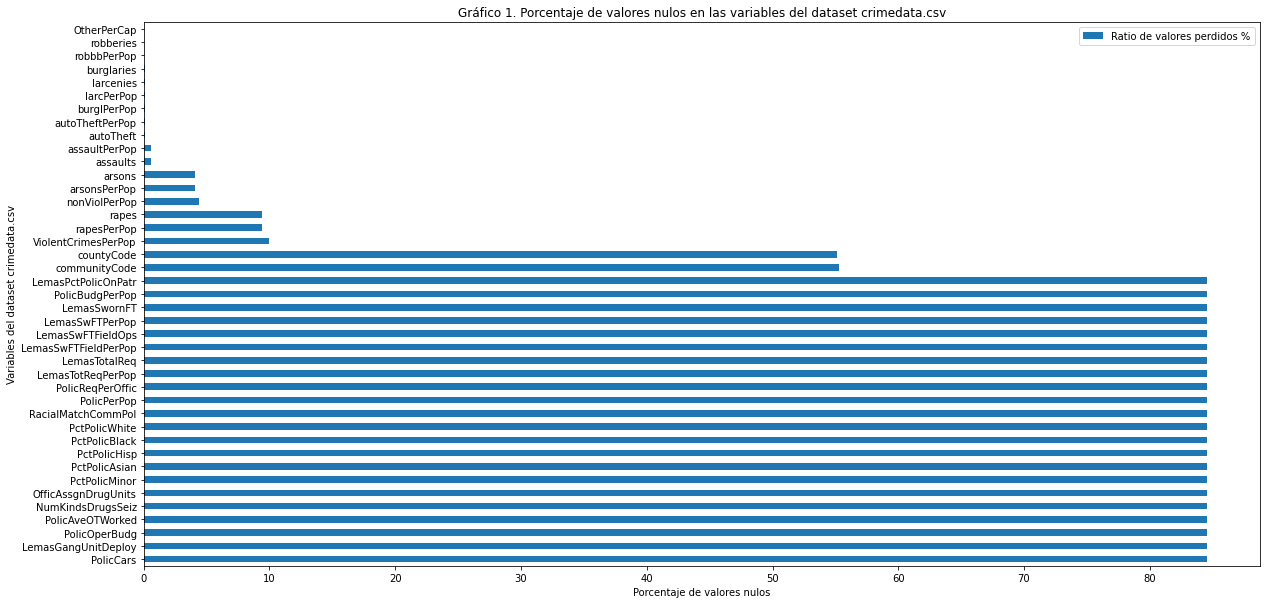

In [10]:
# Gŕafico 1. Porcentaje de valores nulos
if df.isnull().sum().sum() != 0:
    na_df = (df.isnull().sum() / len(df)) * 100 
    na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending = False)
    missing_data = pd.DataFrame({'Ratio de valores perdidos %': na_df})
    missing_data.plot(kind = "barh")
    plt.title('Gráfico 1. Porcentaje de valores nulos en las variables del dataset crimedata.csv')
    plt.xlabel('Porcentaje de valores nulos')
    plt.ylabel('Variables del dataset crimedata.csv')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show()

In [11]:
(missing_data[missing_data['Ratio de valores perdidos %'] > 15].index)

Index(['PolicCars', 'LemasGangUnitDeploy', 'PolicOperBudg', 'PolicAveOTWorked',
       'NumKindsDrugsSeiz', 'OfficAssgnDrugUnits', 'PctPolicMinor',
       'PctPolicAsian', 'PctPolicHisp', 'PctPolicBlack', 'PctPolicWhite',
       'RacialMatchCommPol', 'PolicPerPop', 'PolicReqPerOffic',
       'LemasTotReqPerPop', 'LemasTotalReq', 'LemasSwFTFieldPerPop',
       'LemasSwFTFieldOps', 'LemasSwFTPerPop', 'LemasSwornFT',
       'PolicBudgPerPop', 'LemasPctPolicOnPatr', 'communityCode',
       'countyCode'],
      dtype='object')

## Segunda Parte: Limpieza de los datos 

1. Almacenamos una copia del dataset original para poder realizar los cambios referidos a la limpieza de los datos
2. Eliminamos las variables cuyo valor porcentual de valores nulos **es mayor a 15%** (se pueden revisar las variables en el punto 4.1 de la primera parte)
3. Estructuramos una nueva variable independiente para la criminalidad, el dataset categóriza a los crimenes como violentos y no violentos, pero esto es solo una clafisicación ya que ambas son consideradas crimenes, por ende, decidimos crear dos variables las cual alberga la sumatoria de los crimenes violentos y no violentos divido entre la población y expresado porcentualmente, respectivamente, seguimos la lógica explicada en el repositorio del dataset. 

~~~
The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in missing values for per capita violent crime. Many of these omitted communities were from the midwestern USA (Minnesota, Illinois, and Michigan have many of these).

The per capita nonviolent crime variable was calculated using the sum of crime variables considered non-violent crimes in the United States: burglaries, larcenies, auto thefts and arsons. (There are many other types of crimes, these only include FBI 'Index Crimes')

Recuperado de: http://archive.ics.uci.edu/ml/datasets/Communities%20and%20Crime%20Unnormalized) 
~~~


4. También hemos podido analizar que dentro de la estructura del dataset existen variables númericas que tienen una representación porcentual como variable, decidimos eliminar las variables númericas y continuar con las porcentuales, si seguimos trabajando con ambas el nivel de multicolinialidad aumentará.
    

In [12]:
df1 = df.copy()
df1.isna().sum().sum()

44592

In [13]:
# VCrimes = crimenes violentos
# NVCrimes = crimenes no violentos
df1['VCrimes'] = ((df1.murders + df1.rapes + df1.robberies + df1.assaults) / df1.population) * 100000
df1['NVCrimes'] = ((df1.burglaries + df1.larcenies + df1.autoTheft + df1.arsons) / df1.population) *  100000  
df1['Crimes'] = df1.VCrimes + df1.NVCrimes

In [14]:
# exluimos las variables que no serán seleccionada según el exploratory data analysis y correlación
df1.drop(['Êcommunityname','fold','countyCode', 'communityCode', 'LemasSwornFT', 'numbUrban', 'pctUrban', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop','NumInShelters', 'NumStreet',
          'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'LemasPctOfficDrugUn','PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite','agePct12t21', 'agePct12t29', 'PctRecentImmig',
          'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian','PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctKids2Par', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg','OwnOccHiQuart','RentHighQ',
          'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz','PctYoungKids2Par', 'PctTeen2Par', 'assaults','burglaries','larcenies','autoTheft', 'arsons','murdPerPop', 'rapesPerPop', 'robbbPerPop', 
          'assaultPerPop', 'burglPerPop', 'larcPerPop','autoTheftPerPop', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop', 'LemasPctPolicOnPatr', 
          'LemasGangUnitDeploy', 'PolicBudgPerPop','murders','rapes','robberies','perCapInc', 'NumUnderPov', 'NumUnderPov', 'NumKidsBornNeverMar', 'PctImmigRecent','PctImmigRec5', 'PctImmigRec8', 
          'numbUrban', 'PctImmigRec10', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'MedNumBR', 'HousVacant', 'OwnOccQrange', 'RentQrange', 'MedRent', 'PctForeignBorn', 'PctSameCity85', 'PctSameState85', 
      'murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop', 'burglPerPop', 'autoTheftPerPop', 'arsonsPerPop'], axis=1, inplace = True)

In [15]:
# Conocemos cuantas variables perdimos
print('Perdida de columnas:', df.shape[1] - df1.shape[1])

# Rellenamos los valores nulos por 0
df1 = df1.fillna(0)
print('Valores nulos:', df1.isna().sum().sum())

Perdida de columnas: 74
Valores nulos: 0


In [16]:
for column_name in df1.columns:
    column = df1[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)
    

Count of zeros in column  state  is :  0
Count of zeros in column  population  is :  0
Count of zeros in column  householdsize  is :  0
Count of zeros in column  racepctblack  is :  2
Count of zeros in column  racePctWhite  is :  0
Count of zeros in column  racePctAsian  is :  0
Count of zeros in column  racePctHisp  is :  0
Count of zeros in column  agePct16t24  is :  0
Count of zeros in column  agePct65up  is :  0
Count of zeros in column  medIncome  is :  0
Count of zeros in column  pctWWage  is :  0
Count of zeros in column  pctWFarmSelf  is :  24
Count of zeros in column  pctWInvInc  is :  0
Count of zeros in column  pctWSocSec  is :  0
Count of zeros in column  pctWPubAsst  is :  0
Count of zeros in column  pctWRetire  is :  0
Count of zeros in column  medFamInc  is :  0
Count of zeros in column  whitePerCap  is :  0
Count of zeros in column  blackPerCap  is :  48
Count of zeros in column  indianPerCap  is :  170
Count of zeros in column  AsianPerCap  is :  37
Count of zeros in c

In [17]:
df1.drop(df1.loc[df1['Crimes']==0].index, inplace=True)

In [18]:
len(df1[['Crimes']])

1902

In [19]:
df1.shape

(1902, 73)

## Tercera Parte: Exploratory data analysis

1. Resumen estadistico mediante 'describe' de pandas para nuestras variables filtradas.
2. Análisis de los crimines por estado 
3. Distribución de los crimines por estado
4. Análisis de la distribución de los datos (Outliers) e histogramas.
     <br>4.1 Análisis de la variable dependiente</br>
     4.2 Análisis de las variables independientes

5. Correlación entre las variables independientes.
6. Como encontramos una alta correlación en 47 variables; 7 inversamente proporcional y 40 proporcionales, buscaremos aplicar VIF (Variance Inflation Factor) para encontrar la multicolinealidad entre las variables.

In [20]:
df1.describe().T

count           mean            std           min  \
population             1902.0   52482.256046  206064.881735  10005.000000   
householdsize          1902.0       2.712077       0.347385      1.600000   
racepctblack           1902.0       9.380505      13.963913      0.000000   
racePctWhite           1902.0      83.448465      16.371499      2.680000   
racePctAsian           1902.0       2.821435       4.737298      0.060000   
racePctHisp            1902.0       8.714664      15.447037      0.120000   
agePct16t24            1902.0      13.966803       5.888208      4.640000   
agePct65up             1902.0      11.980478       4.853808      1.660000   
medIncome              1902.0   33947.199790   13497.931524  12908.000000   
pctWWage               1902.0      78.182818       7.845352     31.680000   
pctWFarmSelf           1902.0       0.888086       0.689080      0.000000   
pctWInvInc             1902.0      43.464774      12.802307      9.020000   
pctWSocSec             1902.0      26.582329       8.252940      4.810000   
pctWPubAsst            1902.0       6.760142       4.485985      0.500000   
pctWRetire             1902.0      16.085431       4.582003      3.460000   
medFamInc              1902.0   39760.022082   14321.991451  14257.000000   
whitePerCap            1902.0   16615.332282    6380.182346   5472.000000   
blackPerCap            1902.0   11579.884858    9372.631292      0.000000   
indianPerCap           1902.0   12324.828601   15516.105810      0.000000   
AsianPerCap            1902.0   14294.170347    9625.410754      0.000000   
OtherPerCap            1902.0    9475.369611    8071.773073      0.000000   
HispPerCap             1902.0   11040.528391    5775.311335      0.000000   
PctPopUnderPov         1902.0      11.674858       8.477675      0.640000   
PctLess9thGrade        1902.0       9.432124       6.890343      0.200000   
PctNotHSGrad           1902.0      22.661046      11.078186      2.090000   
PctBSorMore            1902.0      23.032119      12.544985      1.630000   
PctUnemployed          1902.0       6.013281       2.708624      1.320000   
PctEmploy              1902.0      61.865326       8.096844     24.820000   
PctEmplManu            1902.0      17.793991       8.093333      2.050000   
PctEmplProfServ        1902.0      24.469642       6.656727      8.690000   
PctOccupManu           1902.0      13.699453       6.410331      1.370000   
PctOccupMgmtProf       1902.0      28.279858       9.313270      6.480000   
MalePctDivorce         1902.0       9.173170       2.813713      2.130000   
MalePctNevMarr         1902.0      30.654516       8.043528     12.060000   
FemalePctDiv           1902.0      12.394332       3.285900      3.350000   
TotalPctDiv            1902.0      10.868686       3.016200      2.830000   
PersPerFam             1902.0       3.131688       0.252214      2.290000   
PctFam2Par             1902.0      74.030231      10.309906     32.240000   
PctWorkMomYoungKids    1902.0      60.326761       7.908582     24.420000   
PctWorkMom             1902.0      68.740273       6.559828     41.950000   
PctKidsBornNeverMar    1902.0       3.113149       3.062146      0.000000   
NumImmig               1902.0    6462.246583   58377.437369     20.000000   
PctSpeakEnglOnly       1902.0      86.300673      14.761101      6.150000   
PctNotSpeakEnglWell    1902.0       2.601178       4.457456      0.000000   
PctLargHouseFam        1902.0       5.514653       3.992304      0.960000   
PctLargHouseOccup      1902.0       4.020478       3.362004      0.440000   
PersPerOccupHous       1902.0       2.619290       0.328322      1.580000   
PctPersOwnOccup        1902.0      65.562419      14.164922     13.930000   
PctPersDenseHous       1902.0       4.399932       5.938305      0.150000   
PctHousLess3BR         1902.0      45.848465      14.120329      3.060000   
PctHousOccup           1902.0      92.687913       5.286131     37.470000   
PctHousOwnOcc       

En el presente análisis estadistico de las variables podemos observar que existen variables con valores atipicos muy altos, esto podrá generar incongruencias en el modelo, sin embargo, se deben tomar por la importancia técnica en el modelo.

In [21]:
df1.describe(include = 'object').T

count unique top freq
state  1902     44  CA  278

**ANÁLISIS DE LA VARIABLE DEPENDIENTE**

In [22]:
var_dependiente = np.array(df1[['Crimes']])
var_dependiente

array([[ 1460.76794658],
       [ 2119.10219262],
       [ 7865.3217012 ],
       ...,
       [ 5605.65439922],
       [ 5669.15184174],
       [10215.23980898]])

In [26]:

# Agrupamos la clasificación de los crimenes para su analisis por estado
crimedata_state_violent = df1.groupby('state').agg({'VCrimes':'mean'})[['VCrimes']].reset_index()
crimedata_state_nonviolent = df1.groupby('state').agg({'NVCrimes':'mean'})[['NVCrimes']].reset_index()
crimedata_state_violent.dropna(inplace=True)
crimedata_state_nonviolent.dropna(inplace=True)

Podemos observar que el estado de DC liderá la media de crimines violentos, mientras que FL liderá la media en crimenes no violentos. También podemos observar que los estados IL y KS no tienen información sobre criminalidad en el presente dataset.

In [27]:
crimedata_state_violent.sort_values(by = 'VCrimes', ascending = False).head(1)

state      VCrimes
7    DC  2782.666008

In [28]:
crimedata_state_violent.sort_values(by = 'VCrimes', ascending = False).tail(1)

state    VCrimes
23    ND  88.029982

In [29]:
crimedata_state_nonviolent.sort_values(by = 'NVCrimes', ascending = False).head(1)

state     NVCrimes
9    FL  8691.161477

In [30]:
crimedata_state_nonviolent.sort_values(by = 'NVCrimes', ascending = False).tail(1)

state     NVCrimes
16    MA  2886.544579

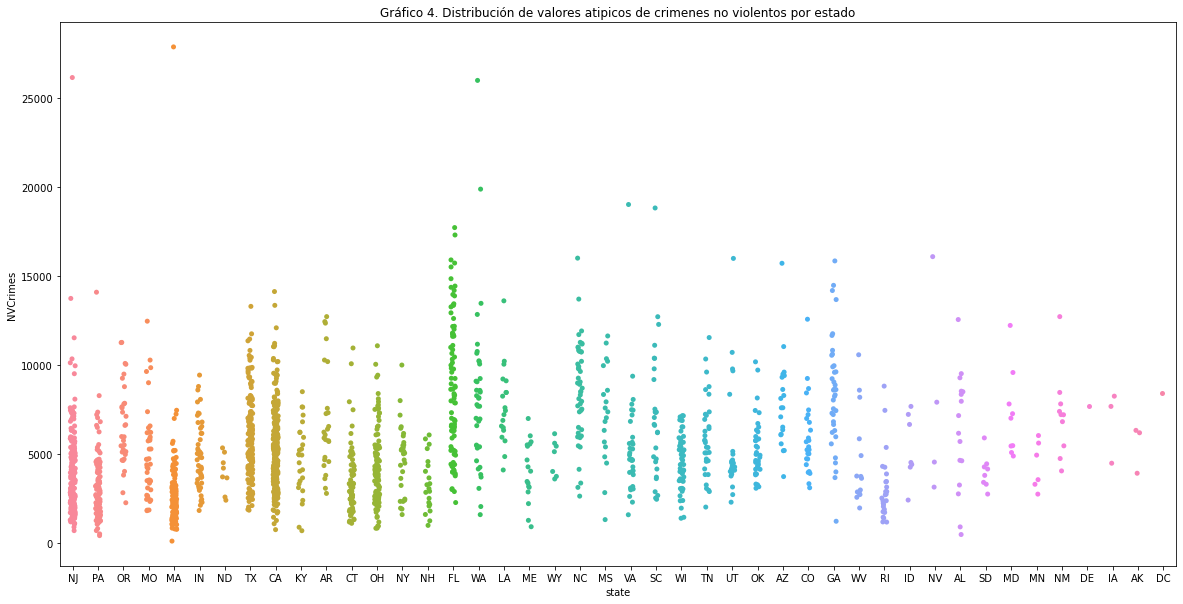

In [31]:
#distribución de los crimines no violentos por estado 
sns.stripplot(x='state', y='NVCrimes', data=df1, jitter=True)
plt.title('Gráfico 4. Distribución de valores atipicos de crimenes no violentos por estado')
plt.show()

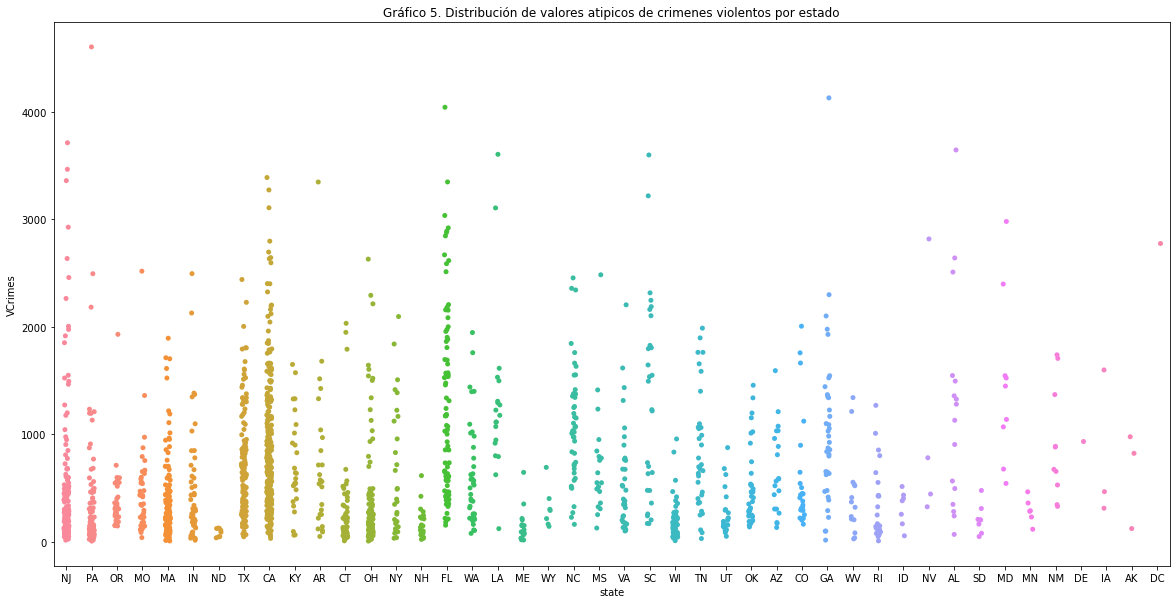

In [32]:
#distribución de los crimines violentos por estado 
sns.stripplot(x='state', y='VCrimes', data=df1, jitter=True)
plt.title('Gráfico 5. Distribución de valores atipicos de crimenes violentos por estado')
plt.show()

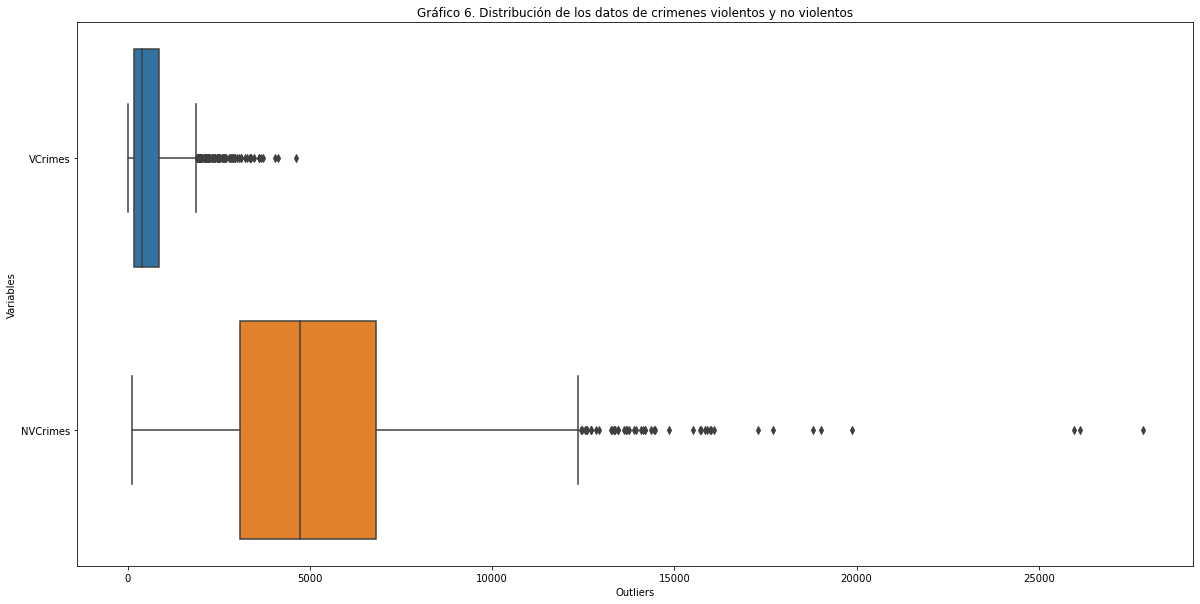

In [33]:
sns.boxplot(data=df1[["VCrimes", "NVCrimes"]], orient="h")
plt.title('Gráfico 6. Distribución de los datos de crimenes violentos y no violentos')
plt.xlabel('Outliers')
plt.ylabel('Variables')
plt.show()

Podemos afirmar que en nuestro modelo las variables independientes y la dependiente contienen valores atipicos que pueden influir en las métricas de nuestros modelos.

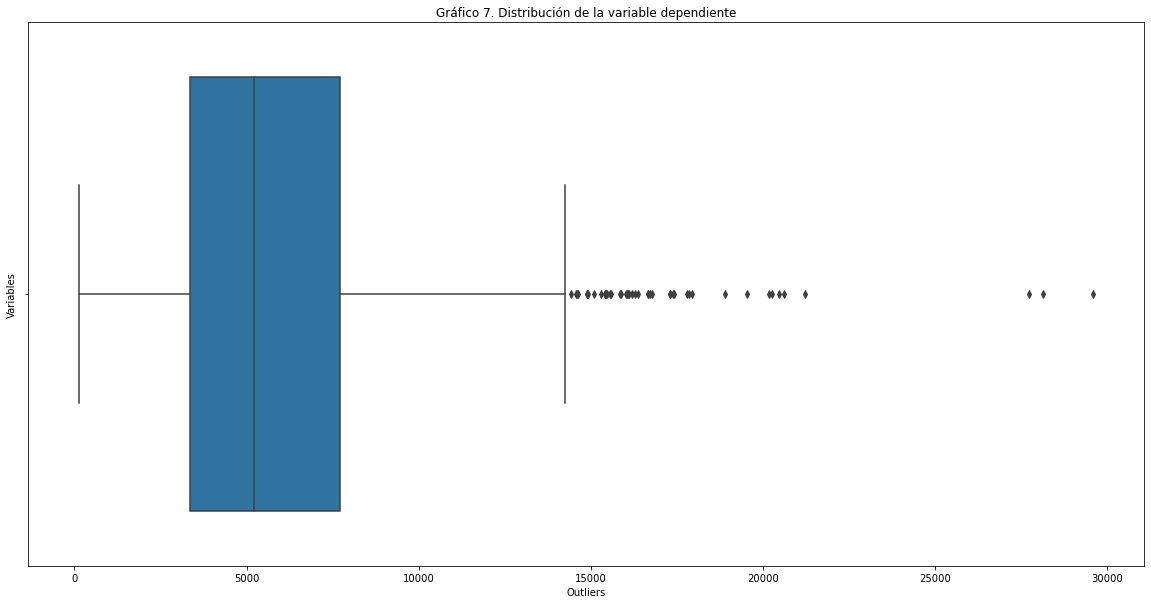

In [34]:
sns.boxplot(df1['Crimes'], orient="h")
plt.title('Gráfico 7. Distribución de la variable dependiente')
plt.xlabel('Outliers')
plt.ylabel('Variables')
plt.show()

**ANÁLISIS DE LAS VARIABLES INDEPENDIENTES**

In [35]:
# filtramos, excluimos estado y la clasificación de crimenes
df_independiente = df1[[ 'population', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct16t24', 'agePct65up', 'medIncome',
       'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst',
       'pctWRetire', 'medFamInc', 'whitePerCap', 'blackPerCap', 'indianPerCap',
       'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'PctPopUnderPov',
       'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu',
       'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv',
       'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctWorkMomYoungKids',
       'PctWorkMom', 'PctKidsBornNeverMar', 'NumImmig', 'PctSpeakEnglOnly',
       'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup',
       'PersPerOccupHous', 'PctPersOwnOccup', 'PctPersDenseHous',
       'PctHousLess3BR', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
       'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb',
       'OwnOccLowQuart', 'OwnOccMedVal', 'RentLowQ', 'RentMedian',
       'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg',
       'PctBornSameState', 'PctSameHouse85', 'LandArea', 'PopDens',
       'PctUsePubTrans', 'Crimes']]

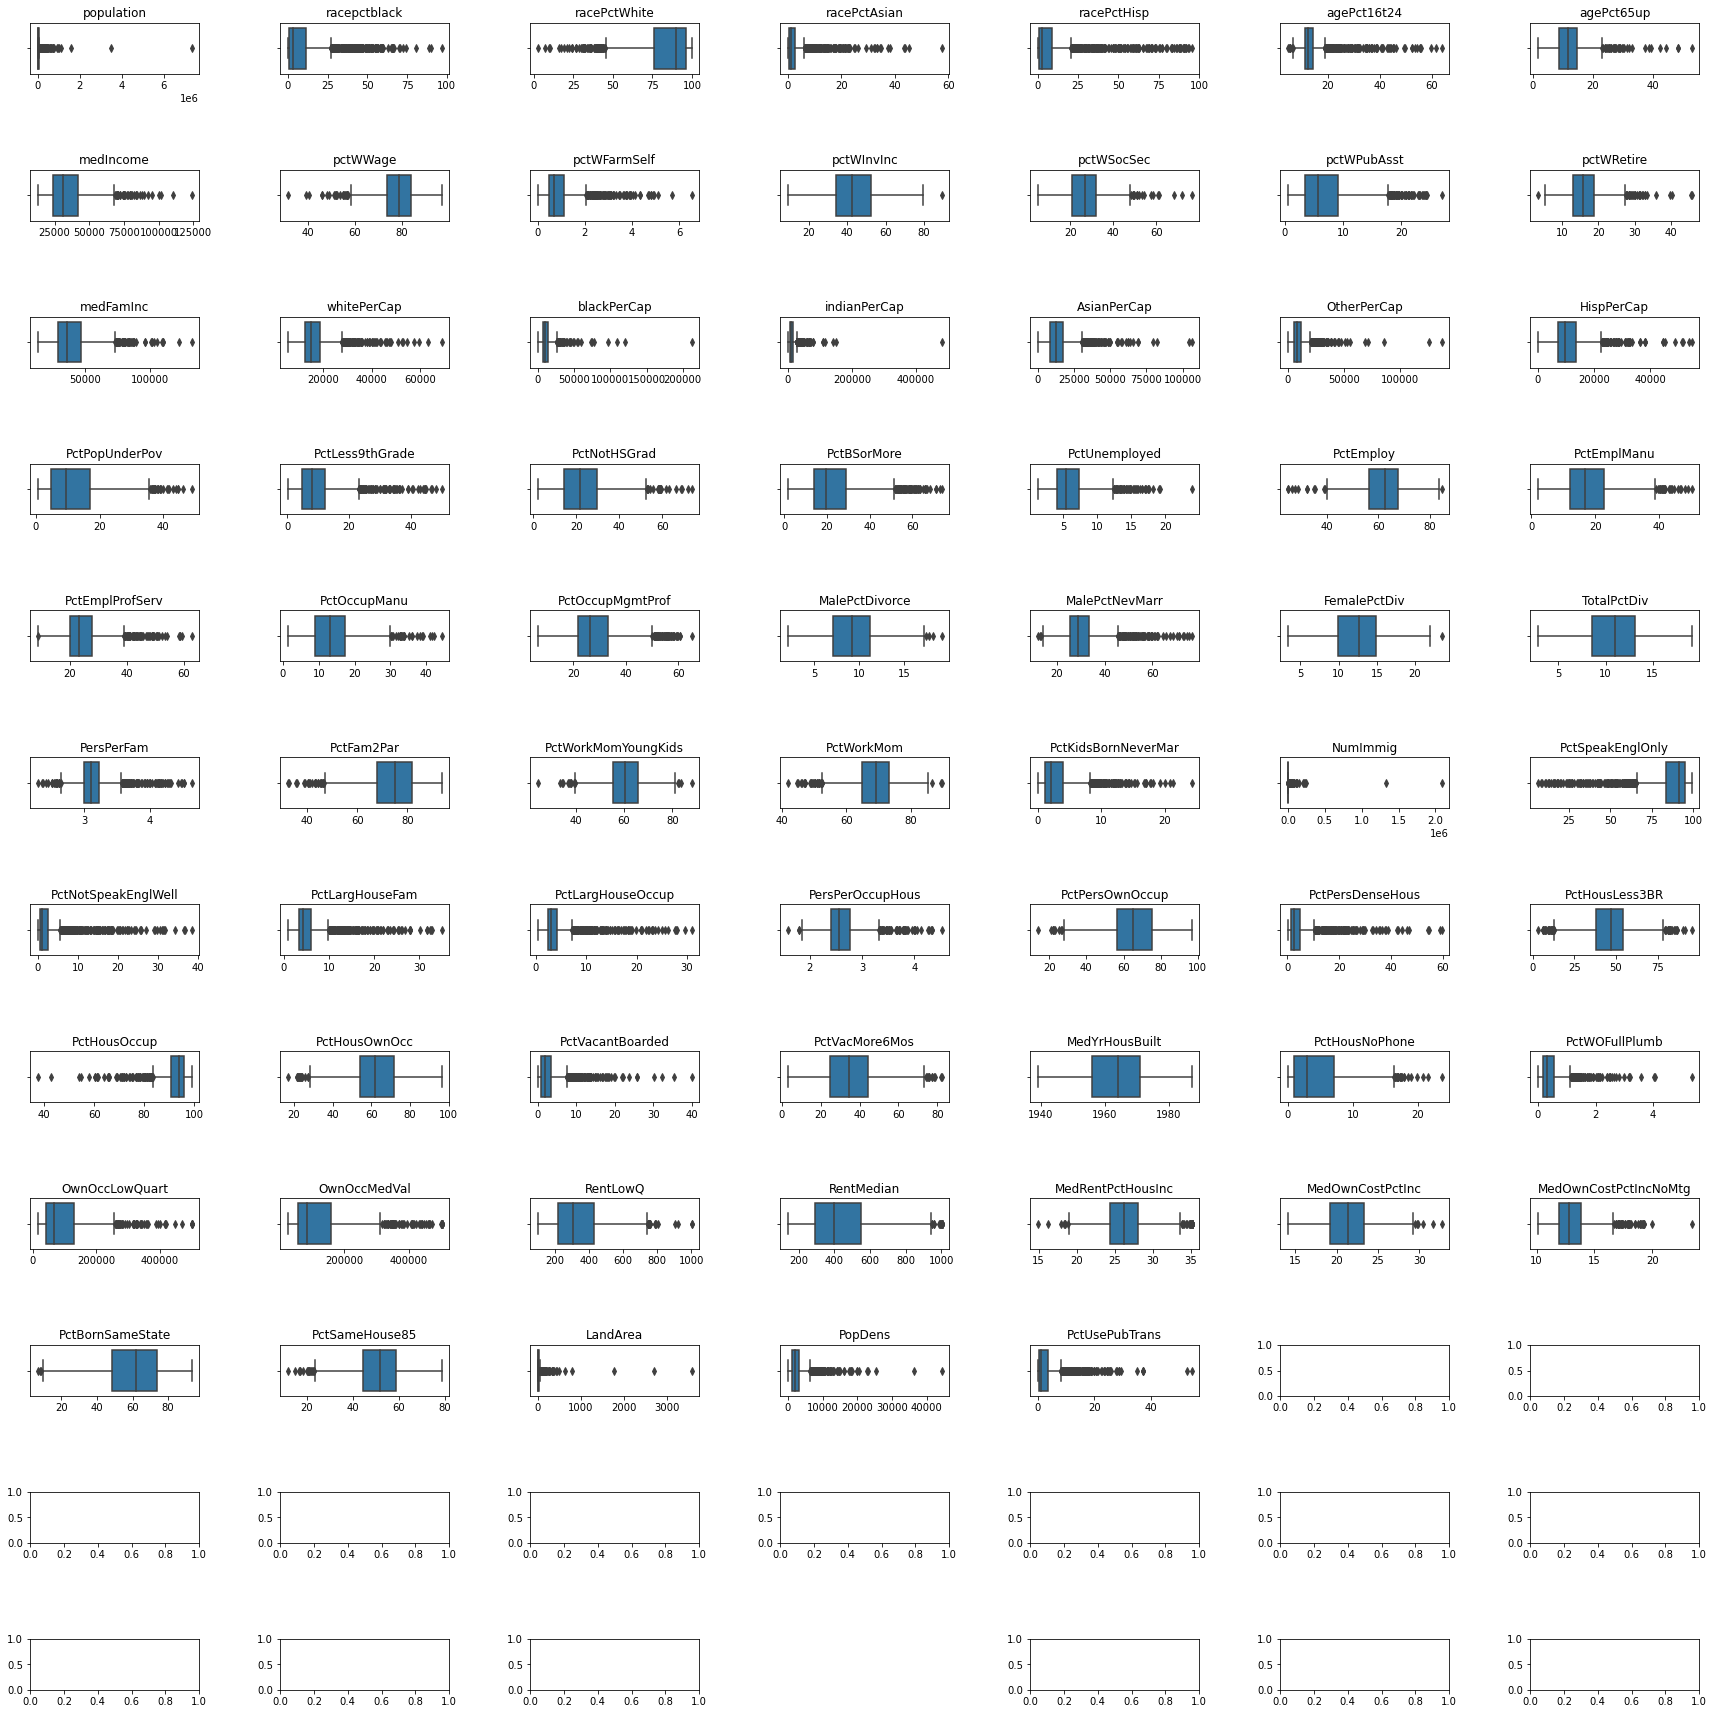

In [36]:
#  outliers
fig, axes = plt.subplots(nrows = 12, ncols = 7, figsize=(25, 25), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = df_independiente.columns[:-1]  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    data = df_independiente[[col, 'Crimes']]  # select the data
    sns.boxplot(data=data, x=col, ax=ax)
    fig.tight_layout(pad = 5.0)
    ax.set(title=f'{col}', xlabel=None)
    
fig.delaxes(axes[80])  # delete the empty subplot
plt.show()

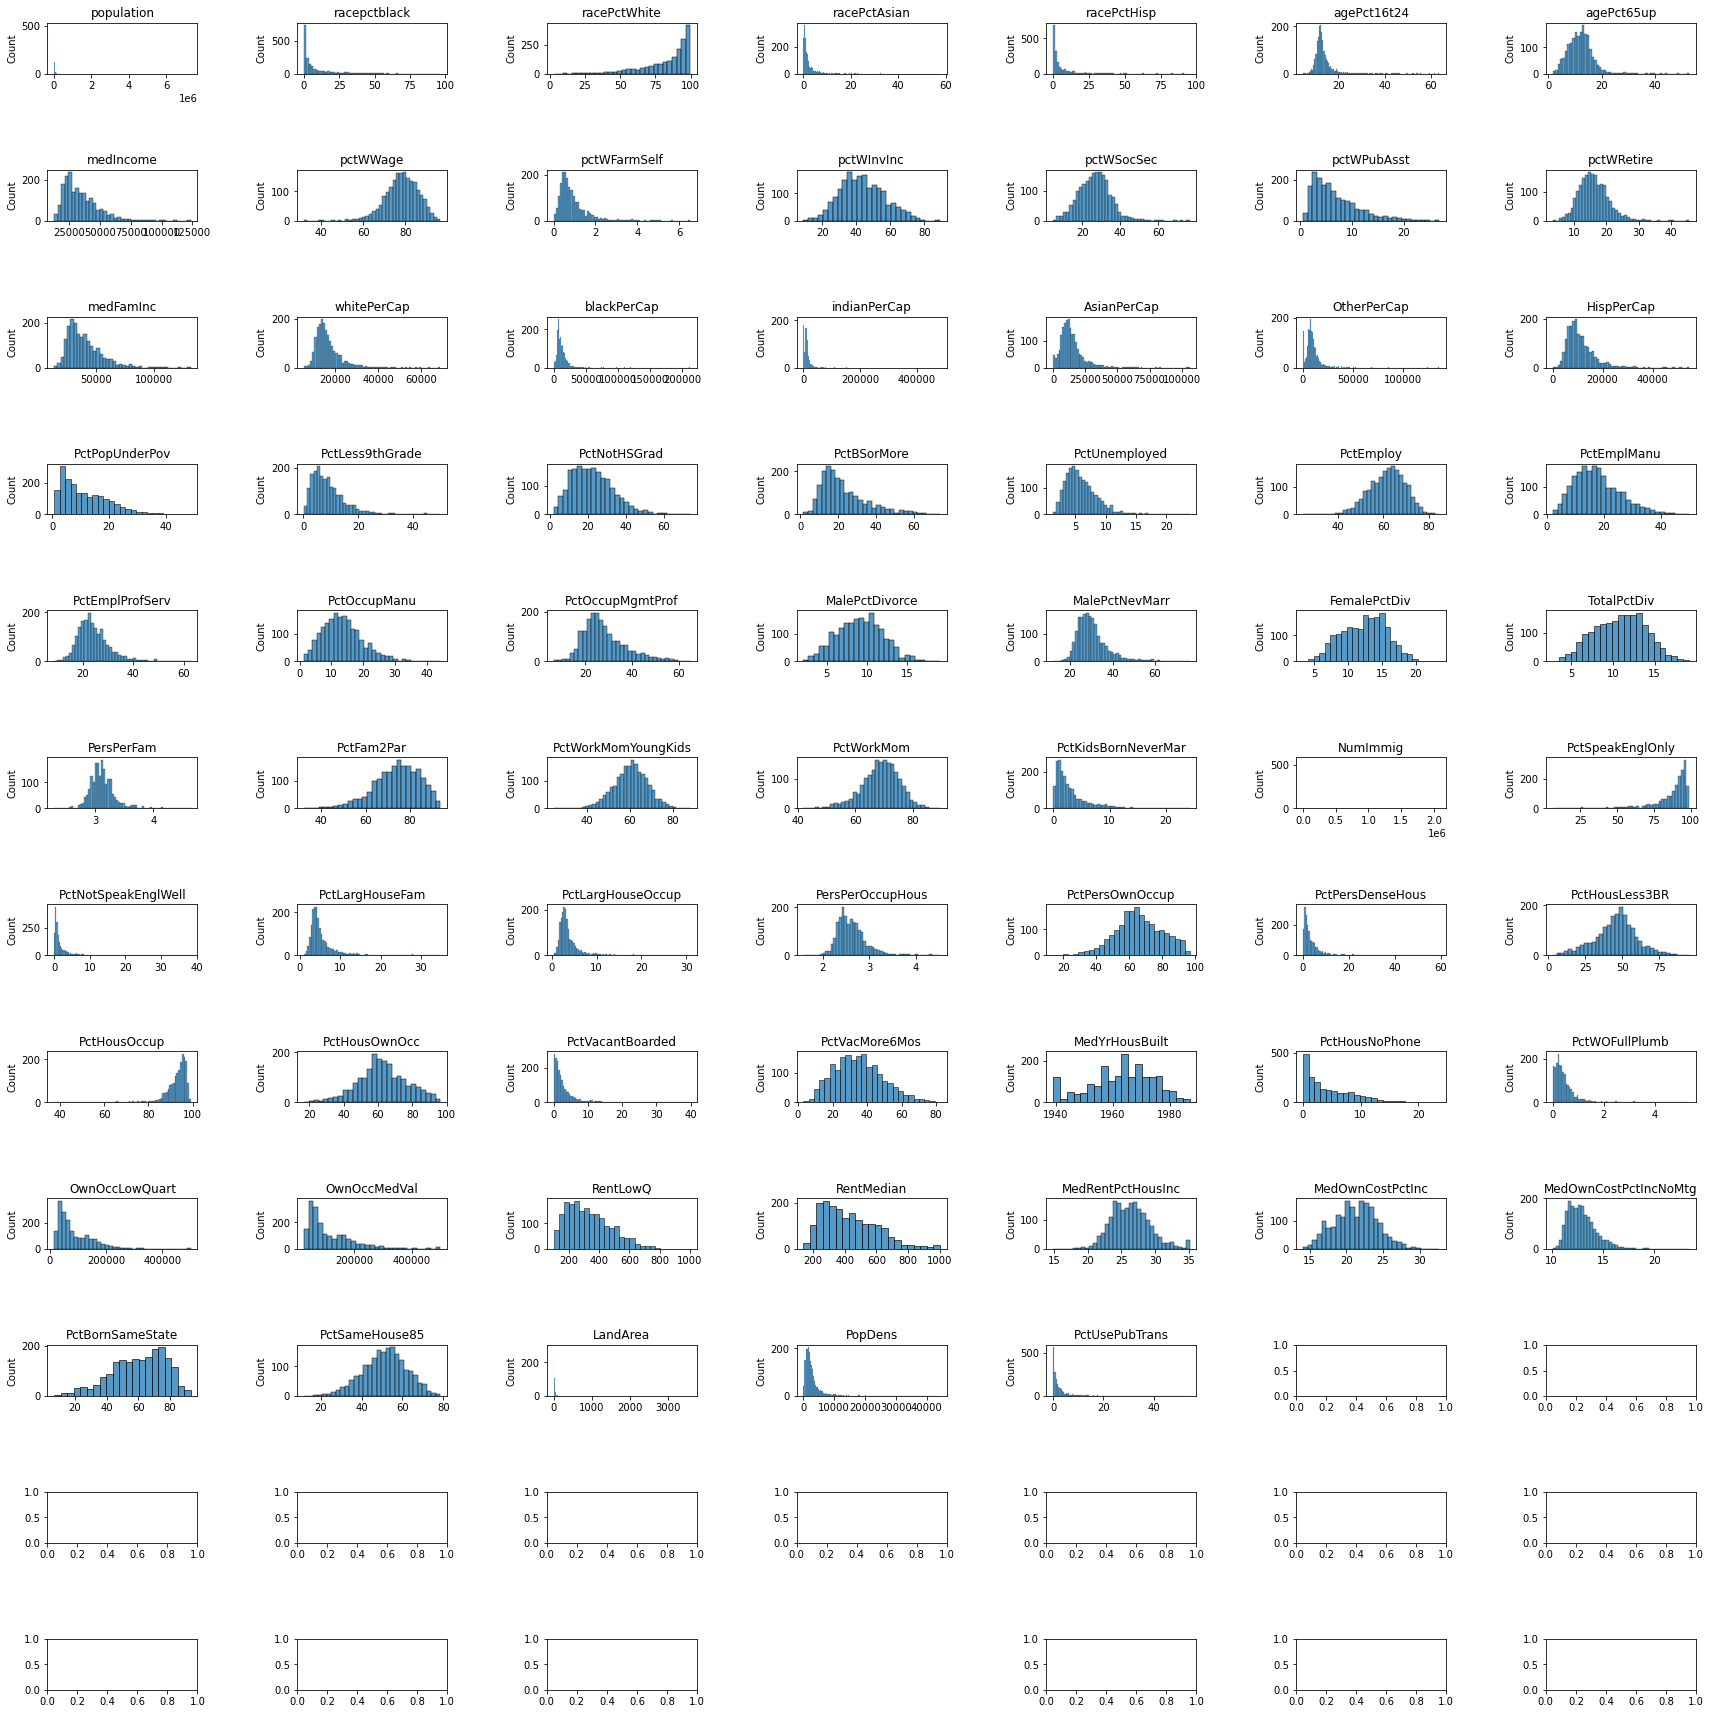

In [37]:
#  Histograma
fig, axes = plt.subplots(nrows = 12, ncols = 7, figsize=(25, 25), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = df_independiente.columns[:-1]  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    data = df_independiente[[col, 'Crimes']]  # select the data
    sns.histplot(data=data, x=col, ax=ax)
    fig.tight_layout(pad = 5.0)
    ax.set(title=f'{col}', xlabel=None)
    
fig.delaxes(axes[80])  # delete the empty subplot
plt.show()

In [38]:
# correlación entre variables
corr = df_independiente.corr()
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
data = {'Porcentaje de Correlacion': sol}
correlacion = pd.DataFrame(data)
proporcional = correlacion[correlacion['Porcentaje de Correlacion'] > .8].sort_values(by = 'Porcentaje de Correlacion', ascending = True)
inversa = correlacion[correlacion['Porcentaje de Correlacion'] < -0.8].sort_values(by = 'Porcentaje de Correlacion', ascending = True)
print('variables con alta correlación (mayor al 80%) y proporcionales:', proporcional.shape[0])
print('variables con alta correlación (mayor al 80%) e inversamente proporcionales:', inversa.shape[0])
print('existe multicoleanilidad')

variables con alta correlación (mayor al 80%) y proporcionales: 40
variables con alta correlación (mayor al 80%) e inversamente proporcionales: 7
existe multicoleanilidad


In [39]:
# definimos una función para poder pintar el df de correlación 
cmap = sns.diverging_palette(220, 20, as_cmap=True)

def magnify(): 
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# estilo del dataframe
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '20px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### **Computing Variance inflation factor** 

En estadística, el factor de inflación de la varianza (VIF) es la razón (cociente) de la varianza de estimar algún parámetro en un modelo que incluye muchos otros términos (parámetros) por la varianza de un modelo construido usando solo un término. Cuantifica la gravedad de la multicolinealidad en un análisis de regresión de mínimos cuadrados ordinarios. Proporciona un índice que mide cuánto aumenta la varianza (el cuadrado de la desviación estándar de la estimación) de un coeficiente de regresión estimado debido a la colinealidad. 

In [40]:
# primer VIF
vif = calc_vif(df_independiente).sort_values('VIF', ascending = False)
print('Variables que mantienen una multicolinealidad menor:', len(vif.loc[vif['VIF'] < 5]))
vif1 = vif.loc[vif['VIF'] < 5]
vif1

Variables que mantienen una multicolinealidad menor: 9


variables       VIF
9       pctWFarmSelf  4.506573
18       AsianPerCap  4.446273
67    PctUsePubTrans  4.318958
55    PctWOFullPlumb  3.941243
16       blackPerCap  3.843878
51  PctVacantBoarded  3.616046
19       OtherPerCap  3.148624
17      indianPerCap  1.780656
65          LandArea  1.329141

# Resumen de la segunda parte

Este segundo segmento esta dividido por 4 partes, la primera parte se encarga del pre procesado de los datos, normalizamos los datos con MinMaxScaler() y aplicamos One Hot Encoding a la variable 'State', la segunda parte esta compuesto por 6 modelos, la tercera parte trae consigo 3 modelos ensambladores sin normalizar (por teoría los árboles de descisiones no se ven afectados por la distribución de la media que afecta a los modelos clásicos generando heterocedasticidad) y la cuarta parte las conclusiones del trabajo.

**Referencia sobre el uso de statsmodels vs sklearn para el análisis exploratorio y automatico:**

[Is Python a viable language to do statistical analysis in?](https://datascience.stackexchange.com/questions/76824/is-python-a-viable-language-to-do-statistical-analysis-in/76841#76841)
            
[Linear Regression in Scikit-learn vs Statsmodels](https://medium.com/@hsrinivasan2/linear-regression-in-scikit-learn-vs-statsmodels-568b60792991)
        
Tras un análisis de los dos documentos referenciados como equipo decidimos desarrollar las regresiones lineales con sus distintas aplicaciones bajo la librería **statsmodels** la cual contiene soporte para los primeros 6 modelos.

Los siguientes 3 modelos se desarrollaron con **sklearn**. 
       
1. El primer paso para el desarrollo es el debate con el equipo de analistas ¿A qué se refiere área?... quizá se debe a la variable landscape... sin embargo, distintos estudios (o antecedentes) que estudian la criminalidad toman la variable de localizacion de la denuncia del crimen que puede ser Región, ciudad, distrito o comuna (clasificados mayormente así en LATAM), por ende, decidimos eliminar variables como el **código de los estados** y **comunnityname**, ambas variables daban relación a área o localización de la denuncia crimen, pero el alto nivel de valores nulos imposibilita su uso. Por consiguiente, seleccionamos la variable estado como una variable que influye en los indices estadisticos y resultados de investigaciones. No es lo mismo realizar un crimen violento en un distrito cuya área es pequeña con una densidad poblacional menor, en comparación con una capital o ciudad influyente, por creemos que el estado forma parte determinante en la influencia de criminalidad y la aplicación de One Hot Encoding nos permitirá incluir en el estudio.

    Logramos encontrar en los modelos clásicos de regresión lineal y ensamblados que existen estados que son significativos en la predicción de cometer un crimen. Esta significancia apoya nuestra hipotesis ¿es posible que un estado permita explicar un crimen? Sí. Al ser relacionados con estados influyentes la probabilidad de denuncia del crimen violento aumenta, asi mismo, cuando hay una mayor masa poblacional existe la posibilidad de un aumento en la probabilidad de asalto.
    
    **¿Cómo influyo One Hot Encoding (OhE)?**
    
    La aplicación de One Hot Encoding muchas veces puede llevarnos a la [trampa de las variables dummie](https://www.learndatasci.com/glossary/dummy-variable-trap/), aumentando la multicolinealidad de nuestro modelo e influyendo en los estimadores y métricas de nuestros modelos.
        
2. Decidimos utilizar **statsmodels** por su estructura y diseño. Como se comento anteriormente estos modelos clásicos están orientados al análisis exploratorio sin un enfoque de automatización, por ende, 
    nos permitirá calcular métricas requeridas como AIC, BIC, RMSE, distribución de las variables.
    
    La primera conclusión del análisis de los residuos es que los 4 primeros modelos mantienen una misma distribución de los errores, esto puede ser provocado por la aplicación de OHE y la trampa de las variables dummies, y los outilers, sin embargo, consideramos que 57 valores de outliers no generaran un cambio significativo en nuestro modelo.
    
    

    <br>  **Regresión lineal con todas las variables**
    
    Dentro del análisis principal podemos encontrar que desarrollar un modelo con todas las variables nos da como resultado un R2 ajustado de 64%, es decir, nuestras variables independientes explican en un 64 la posibilidad de que realice un crimen. 
    Con respecto al análisis residual, podemos observar en el histograma de los residuos su distribución en conjunto al Q-Q plot, observamos que existe heterocedasticidad, y se da porque posiblemente estemos cayendo en la trampa de las variables dummies. Sin embargo como parte de la investigación es importante como los datos se comportan en un modelo afectado por este supuesto y luego el análisis contra un modelo no afectado por el supuesto como minimos cuadrados ponderados o un modelo ensamblado basado en [arboles de decisiones](https://datascience.stackexchange.com/questions/31402/multicollinearity-in-decision-tree).</br> 
    <br> **Regresión lineal con 68 las variables**
    
    El R2 ajustado disminuyó, posiblemente, la disminución de las variables influyen en la explicación y su relación, los errores se mantienen similares al primer modelo, los test de heterocedasticidad confirman esta desviación de los valores de su media. </br>
    
    <br>**Regresión lineal con 23 las variables**
    
     Seguimos reduciendo las variables en función a su significancia, y a la ves, se reduce nuestro coeficiente de correlación ajustado, es interesante que una disminuución de aproximadamente 45 variables disminuya en en el R2 ajustado un 5%. Por más que alguna de esas 45 variables tenga un alto nivel de significancia es posible que no mantenga un relación proporcional o inversa con los crimenes, podemos revisar el test Goldfeld-Quant el cual afirma la hipótesis alternativa confirmando la presencia de heterocedasticidad. (Referencia: https://www.statology.org/goldfeld-quandt-test-in-r/) 

    <br>**Regresión Polinomial con 23 las variables**
    
    Primero debemos tener en cuenta la estructura matemática de los modelos y su aplicación; La regresión polinomial es una técnica que podemos usar para ajustar un modelo de regresión cuando la relación entre la(s) variable(s) predictora(s) y la variable de respuesta no es lineal. Sin embargo los crimenes no son exponenciales si bien es cierto tienen un crecimiento tiende a ser más lineal ya que estos no paran, pero no puede crecer de manera desproporcionado porque en los países existen leyes, policias, entre otros factores que estos tengan este crecimiento. Por ende, decidimos establecer el modelo con el primer grado de un polinomio, lo cual replicará al modelo anterior obteniendo los mismos resultados.
    
    <br> **Regresión Ridge con 23 las variables**
    
     Los métodos conocidos como regularización o shrinkage, consisten en ajustar el modelo incluyendo todos los predictores pero aplicando una penalización que fuerce a que las estimaciones de los coeficientes de regresión tiendan a cero. Con esto se intenta evitar overfitting, reducir varianza, atenuar el efecto de la correlación entre predictores y minimizar la influencia en el modelo de los predictores menos relevantes. (Recuperado de: https://www.cienciadedatos.net/documentos/31_seleccion_de_predictores_subset_selection_ridge_lasso_dimension_reduction#:~:text=La%20principal%20diferencia%20pr%C3%A1ctica%20entre,no%20llega%20a%20excluir%20ninguno.)
     
     Podemos observar el cuadro adjunto que la aplicación de esta penalización que penaliza la suma de los coeficientes elevados al cuadrado y tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. Influye de manera negativa en el modelo disminuyendo el coeficiente de correlación a 15% y manteniendo valores altos en los test heterocedasticos.. El método de mínimos cuadrados ponderados se puede utilizar cuando se viola el supuesto de mínimos cuadrados ordinarios de varianza constante en los errores (lo que se denomina heterocedasticidad).
    
    <br> **Regresión linal con mínimos cuadrados ponderados con 23 las variables**
    
    Hasta el momento el mejor modelo que hemos obtenido utilizando la librería statsmodels bajo la premisa de un análisis exploratorio del comportamiento de las variables su relación y métricas, este modelo tiene el mejor perfomance en las métricas como AIC y BIC, el coeficiente de correlación ajustado es de unu 87%, es decir, utilizar minimos cuadrados ponderados con 23 variables es beneficioso cuando encontramos el supuesto de la heterocedasticidad. Y esto es por su estructura matemática. El método de mínimos cuadrados ponderados se puede utilizar cuando se viola el supuesto de mínimos cuadrados ordinarios de varianza constante en los errores (lo que se denomina heterocedasticidad).Sin embargo, algunos aspectos de los datos (como la varianza no constante o los valores atípicos) pueden requerir un método diferente para estimar la línea de regresión. 
    
    Si nos detenemos de nuevo en el análisis de las variables podemos detectar outliers y heterocedasticidad. La estructura matemática de este modelo es apropiado. </br>
    
  **Obteniendo un cuadro resumen de los siguientes resultados:**
    
    
       
|Modelos|R2-AJUSTADO|AIC|BIC|RMSE|Jarque-Bera|breusch-Pagan|Goldfeld-Quandt|
|--------|----|-----|-----|----------|------------|----------------|----|
|**Regresión Lineal t. Var.**|0.6484597569010611|34625.076565077376|35252.30128554828|4453102.544203663|33949.50124227895|94.27646077907372|0.8686617145292834|
|**Regresión Lineal 68 Var.**|0.6237261786022648|34666.39912256634|35049.39474834061|4651998.081689829|25238.890997441562|81.36386251842248|0.9243440204314664|
|**Regresión Lineal 23 Var.**|0.5712752793147804|34824.606146429694|34957.822016264225|5173457.979966532|13375.54251318823|66.21735903364197|0.9533928973960347|
|**Regresión Polinomial 23 Var.** |0.5712752793147804|34824.606146429694|34957.822016264225|562879695.9156499|13375.54251318823|66.21735903364197|0.9533928973960347|
|**Regresión Ridge 23 Var.**|0.15257941255708263|38687.80572039565|39455971.80451441|39455971.80451441|1717.265167985761|1081.7222477124537|0.9432378326570405|
|**Regresión Lineal Ponderada 23 Var.**|0.876003215963872|35055.41317784618|35183.078386437606|5843968.7903385535|10714.05257716969|192.43739779603717|0.9432378326570408|

  

3. Modelos: Segunda Parte

Los modelos ensamblados basados en arboles de decisiones nos permiten utilizar primero los datos sin escalar, no necesitamos escalarlos porque no queremos resolver el problema del suspuesto de la homocedasticidad/heterocedasticidad.

Los modelos se sobre entrenan de manera significativa con pocos nodos, es decir, la selección de las 23 variables no generan un impacto significativo en la modelización y la búsqueda de un resultado eficiente en un modelo con un perfomance de automatización y una estructura actualizada.


    - Regresión de XG boost (Tomando 23 características basadas en el valor p).
        
       - Model Accuracy: 0.568
       - The mean squared error (MSE) on test set: 5857863.4580
       
    
    - Regresión de Gradient Boosting (tomando 23 características basadas en el valor p).
       
       
       - Model Accuracy: 0.556
       - The mean squared error (MSE) on test set: 6018181.4504
    
    - Regresión Light GBM (tomando 23 características basadas en el valor p).
    
        
       - Model Accuracy: 55.25
       - The mean squared error (MSE) on test set: 6069660.2373

 Estos modelos orientados a la automatización se desarrollaron con el apoyo de la librería de sklearn y sus *API'S* correspondiente. 
    
4. Conclusiones
   

    1. El requerimiento de la aplicación  de modelos clásicos y automatizados nos permiten comprender que si tenemos un buen análisis descriptivo o exploratorio de los datos podemos seleccionar un modelo óptimo en función a su estructura matemática. Sin embargo, esto incide en los  costos empresariales, la oferta de profesionales preparados para este tipo de análisis y conocimiento estructural de las matemáticas de los modelos es escaza, por consiguiente, en un modelo de oferta y demanda de capital humano realizar estos modelos en un tiempo determinado ya de por sí puede ser costoso **empresarialmente**

    2. El modelo con un mayor coeficiente de correlación ajustado es el modelo cuya estructura matemática penaliza los supuestos de homocedasticidad y heterocedasticidad.
    3. No siempre los modelos ensamblados nos darán los mejores resultados, muchos de los problemas de negocio se suelen solucionar con modelos más sencillos.
    4. El análisis exploratorio con los modelos de statsmodels nos permiten conocer la distribución de los errores, multicoleanilidad, sesgo, kurtosis, entre otros test, que permiten la selección o filtro de nuevas variables para uun mejor perfomance de los modelos
    5. Consideramos que la aplicación de la normalización mediante MinMax() no es la más eficiente, cuando tenemos outliers bien marcados como nosotros en nuestro modelo se suele recomendar la aplicación de la normalización mediante RobustScaler(), ambos métodos se encuentran en la librería SK-Learn.
    6. Los estados son variables importantes en los dos tipos de modelos.
    7. La variable más significativa y que más se repitio en todos los modelos es la variable de los niños que nacieron fuera del matrimonio, exactamente no sabemos que indicador mide esta variable. Sin embargo, si la tomamos desde el punto de vista de los antecedentes. Los niños que nacen fuera de un matrimonio tienen un alto indice de incidencia en vivir en albergues y/o lugares precarios con ausencia de los padres, en USA este tipo de problema estructural, genera una influencia en los crimenes. Lo vemos de la siguiente forma: los niños que van a un albergue al cumplir los 18 tienen que salir, sin un respaldo económico ni familiar, aumentando la probabilidad de que estos niños caigan en la incidencia de criminalidad violenta o no. 
    8. Si deseamos una regresión en donde disminuyamos la posibilidad de caer en el supuesto de la homocedasticidad podemos programar un VIF (Variation inflation factor) el cual mide la multicolinealidad entre las variables, nosotros solo por análisis descriptivo descubrimos que un modelo bajo en multicolinealidad solo debe mantener 9 variables, estas también son interesantes ya que selecciona **RAZA, PORCENTAJE DE PERSONAS QUE USAN TRANSPORTE PUBLICO y el ÁREA.**






### Pre procesamiento de los datos 

1. Escalado 
2. One Hot Encoding (OHE) a la variable state

In [100]:
Y  = np.array(df1.Crimes)

AttributeError: 'DataFrame' object has no attribute 'Crimes'

In [108]:
len(encoded)

1902

In [42]:
# One Hot Encoder para la variable categórica
ohe = OneHotEncoder()
var_dummie_state = df1['state']
encoded = pd.DataFrame(ohe.fit_transform(var_dummie_state))

In [43]:
# eliminamos la variable estado para aplicar el merge 
df1.drop(['state', 'Crimes', 'VCrimes', 'NVCrimes'], axis=1, inplace = True)

In [44]:
# merge del df con ohe y el df con el resto de variables independientes
X = pd.merge(encoded, df1, left_index=True, right_index=True)

In [45]:
from sklearn.preprocessing import MinMaxScaler
mmx = MinMaxScaler()
names_columns_x = list(X.columns)
xscale = pd.DataFrame(mmx.fit_transform(X), columns = names_columns_x)

In [107]:
encoded

state_1  state_2  state_3  state_4  state_5  state_6  state_7  state_8  \
0           1        0        0        0        0        0        0        0   
1           0        1        0        0        0        0        0        0   
2           0        0        1        0        0        0        0        0   
5           0        0        0        1        0        0        0        0   
6           0        0        0        0        1        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
2210        0        0        0        0        0        0        0        0   
2211        0        0        0        0        0        0        0        0   
2212        0        0        0        0        0        0        0        0   
2213        0        0        0        0        0        0        0        1   
2214        0        0        0        0        0        0        0        0   

      state_9  state_10  state_11  state_12  state_13  state_14  state_15  \
0           0         0         0         0         0         0         0   
1           0         0         0         0         0         0         0   
2           0         0         0         0         0         0         0   
5           0         0         0         0         0         0         0   
6           0         0         0         0         0         0         0   
...       ...       ...       ...       ...       ...       ...       ...   
2210        1         0         0         0         0         0         0   
2211        0         0         0         0         0         0         0   
2212        1         0         0         0         0         0         0   
2213        0         0         0         0         0         0         0   
2214        1         0         0         0         0         0         0   

      state_16  state_17  state_18  state_19  state_20  state_21  state_22  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
5            0         0         0         0         0         0         0   
6            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
2210         0         0         0         0         0         0         0   
2211         0         0         1         0         0         0         0   
2212         0         0         0         0         0         0         0   
2213         0         0         0         0         0         0         0   
2214         0         0         0         0         0         0         0   

      state_23  state_24  state_25  state_26  state_27  state_28  state_29  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
5            0         0         0         0         0         0         0   
6            0         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
2210         0         0         0         0         0         0         0   
2211         0         0         0         0         0         0         0   
2212         0         0         0         0         0         0         0   
2213         0         0         0         0         0         0         0   
2214         0         0         0         0         0         0         0   

      state_30  state_31  state_32  state_33  state_34  state_35  state_36  \
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2           

## Modelo 1: Regresión lineal con todas las variables

                         Results: Ordinary least squares
Model:                    OLS                  Adj. R-squared:         0.626     
Dependent Variable:       y                    AIC:                    34625.0766
Date:                     2022-09-19 12:30     BIC:                    35252.3013
No. Observations:         1902                 Log-Likelihood:         -17200.   
Df Model:                 112                  F-statistic:            29.46     
Df Residuals:             1789                 Prob (F-statistic):     0.00      
R-squared:                0.648                Scale:                  4.4531e+06
---------------------------------------------------------------------------------
                        Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
---------------------------------------------------------------------------------
const                  1566.1121  4350.3677  0.3600 0.7189  -6966.2244 10098.4486
state_1                -152.3835   353.43

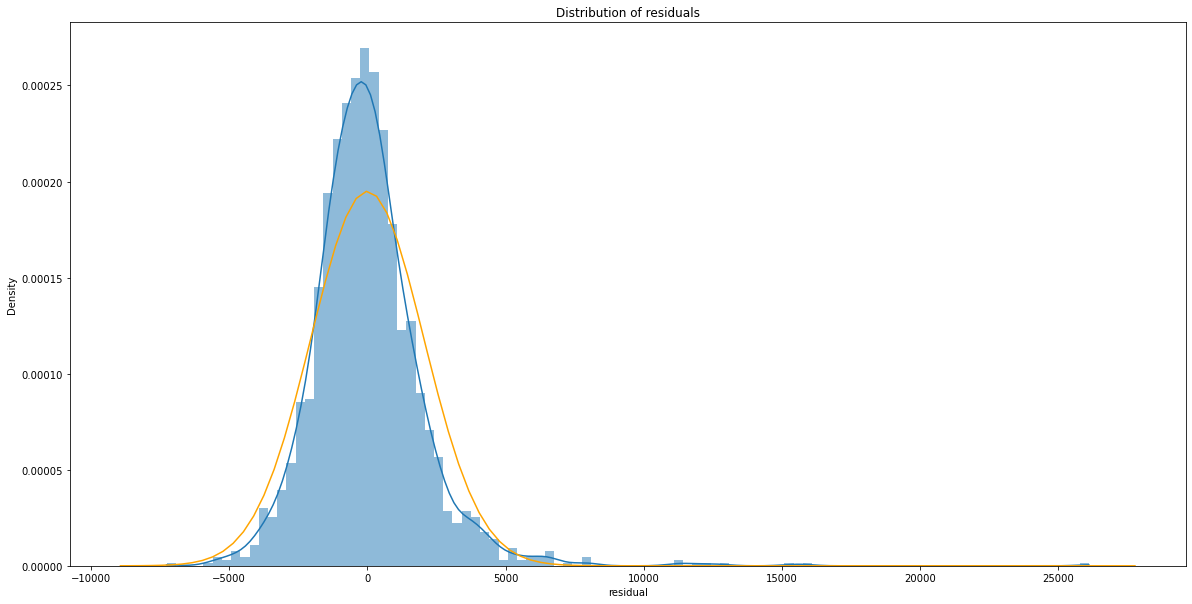

mu, std: 1.5290222178701972e-11  2046.5919520206992


Boxplot de los residuos




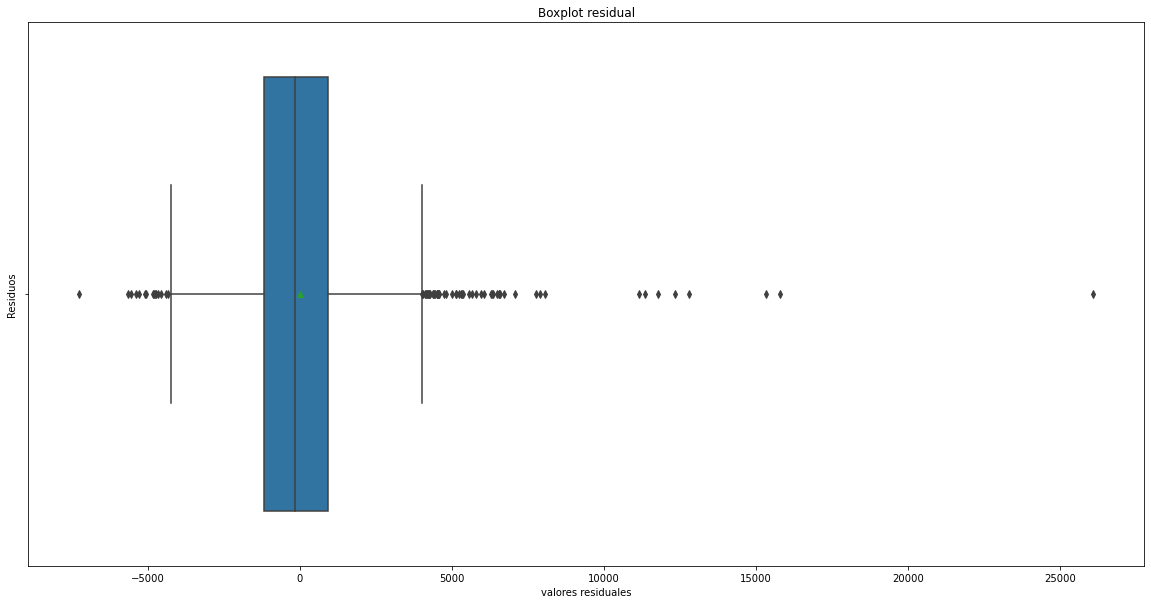



Q-Q plot de los residuos




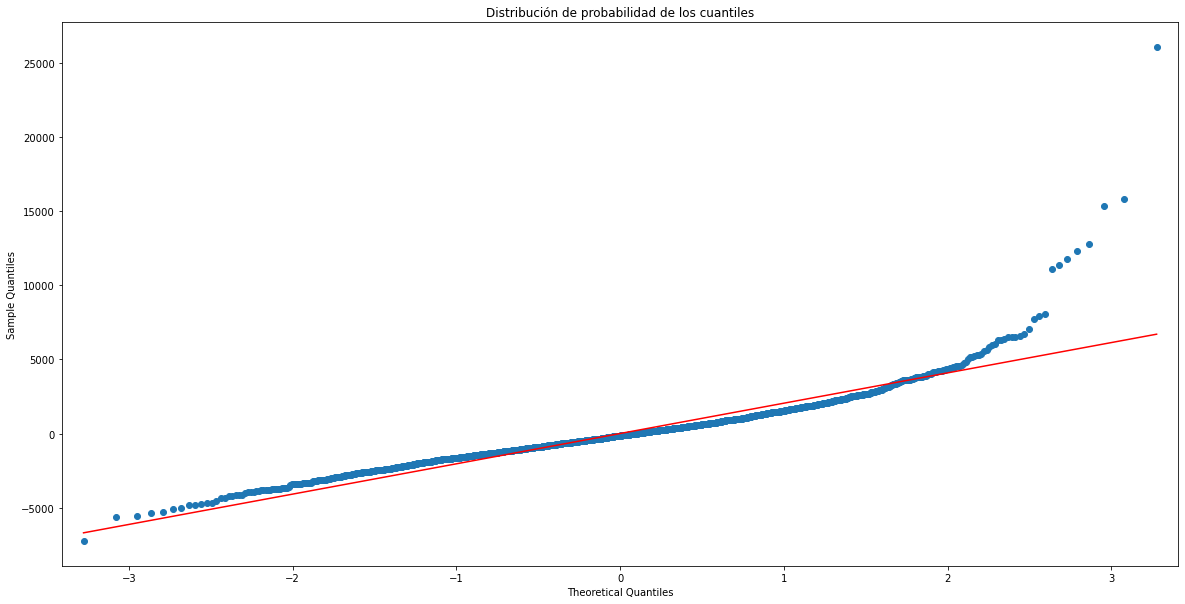



Pruebas estadisticas de la distribución de los residuos:


[('Jarque-Bera', 33949.50124227895), ('Chi^2 two-tail prob.', 0.0), ('Skew', 2.3516102550272713), ('Kurtosis', 23.156006314580537)]


Prueba Breusch-Pagan Lagrange Multiplier test for heteroscedasticity:


[('Lagrange multiplier statistic', 94.27646077907372), ('p-value', 0.8991595094299257), ('f-value', 0.8330356259961507), ('f p-value', 0.8943330078242753)]


Goldfeld-Quandt test:


[('F statistic', 0.8686617145292834), ('p-value', 0.9792122554137744)]


 68 variables seleccionadas según su significancia estadistica:
Index(['state_16', 'PopDens', 'state_17', 'state_21', 'MalePctNevMarr',
       'state_2', 'PctLess9thGrade', 'state_29', 'PctHousOccup',
       'PctVacMore6Mos', 'state_27', 'householdsize', 'state_14', 'PctEmploy',
       'PctHousLess3BR', 'state_13', 'PctNotHSGrad', 'RentLowQ',
       'PctOccupMgmtProf', 'pctWRetire', 'LandArea', 'pctWSocSec', 'state_5',
       'whitePerCap', 'PctEmplManu', 'state_23', 'state

In [48]:
stats_regression(xscale, Y)

## Modelo 2: Regresión lineal con 68 variables

In [49]:
X2 = xscale[['state_16', 'PopDens', 'state_17', 'state_21', 'MalePctNevMarr',
       'state_2', 'PctLess9thGrade', 'state_29', 'PctHousOccup',
       'PctVacMore6Mos', 'state_27', 'householdsize', 'state_14', 'PctEmploy',
       'PctHousLess3BR', 'state_13', 'PctNotHSGrad', 'RentLowQ',
       'PctOccupMgmtProf', 'pctWRetire', 'LandArea', 'pctWSocSec', 'state_5',
       'whitePerCap', 'PctEmplManu', 'state_23', 'state_22', 'state_12',
       'PctKidsBornNeverMar', 'MedYrHousBuilt', 'state_3', 'state_24',
       'PctNotSpeakEnglWell', 'OtherPerCap', 'state_33',
       'MedOwnCostPctIncNoMtg', 'state_11', 'state_32', 'state_10',
       'blackPerCap', 'PctBSorMore', 'PctBornSameState', 'state_6',
       'agePct65up', 'state_42', 'PctSpeakEnglOnly', 'PctUnemployed',
       'state_44', 'PctPersOwnOccup', 'pctWInvInc', 'population', 'state_18',
       'state_36', 'state_19', 'pctWFarmSelf', 'racepctblack', 'OwnOccMedVal',
       'MedOwnCostPctInc', 'state_38', 'PctWorkMom', 'PctLargHouseFam',
       'state_35', 'PersPerOccupHous', 'AsianPerCap', 'PersPerFam', 'state_34',
       'PctUsePubTrans', 'PctHousOwnOcc']]

                         Results: Ordinary least squares
Model:                    OLS                  Adj. R-squared:         0.610     
Dependent Variable:       y                    AIC:                    34666.3991
Date:                     2022-09-19 12:30     BIC:                    35049.3947
No. Observations:         1902                 Log-Likelihood:         -17264.   
Df Model:                 68                   F-statistic:            44.68     
Df Residuals:             1833                 Prob (F-statistic):     0.00      
R-squared:                0.624                Scale:                  4.6520e+06
---------------------------------------------------------------------------------
                         Coef.     Std.Err.    t    P>|t|     [0.025     0.975]  
---------------------------------------------------------------------------------
const                  16429.1507 2312.7376  7.1038 0.0000  11893.2732 20965.0282
state_16                2559.7581  351.39

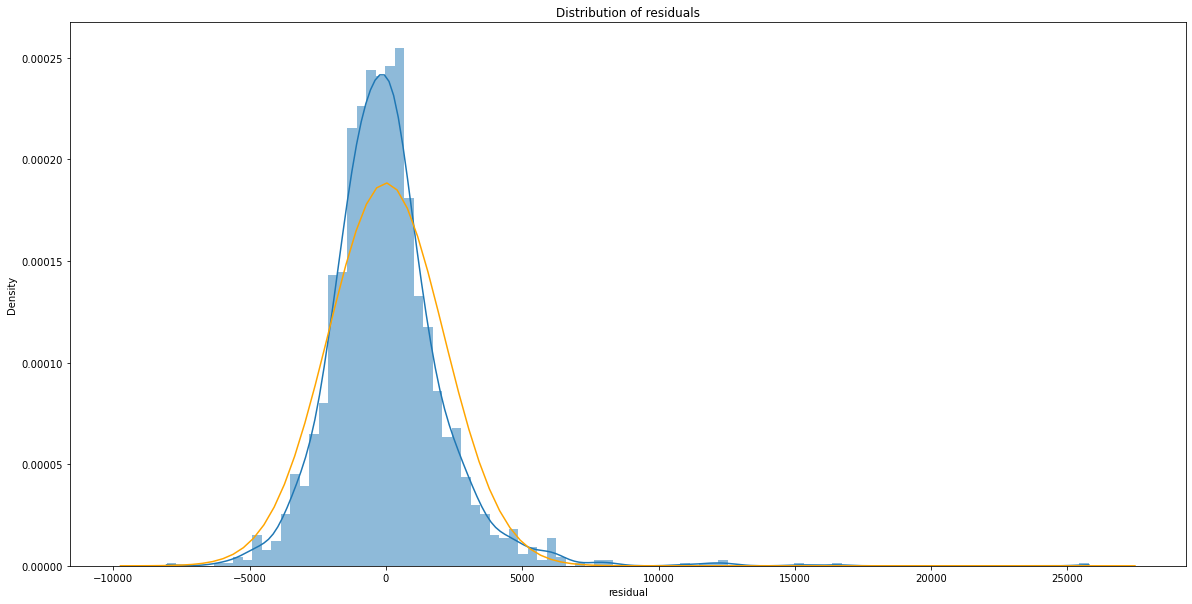

mu, std: 2.7344135134691446e-11  2117.365047492156


Boxplot de los residuos




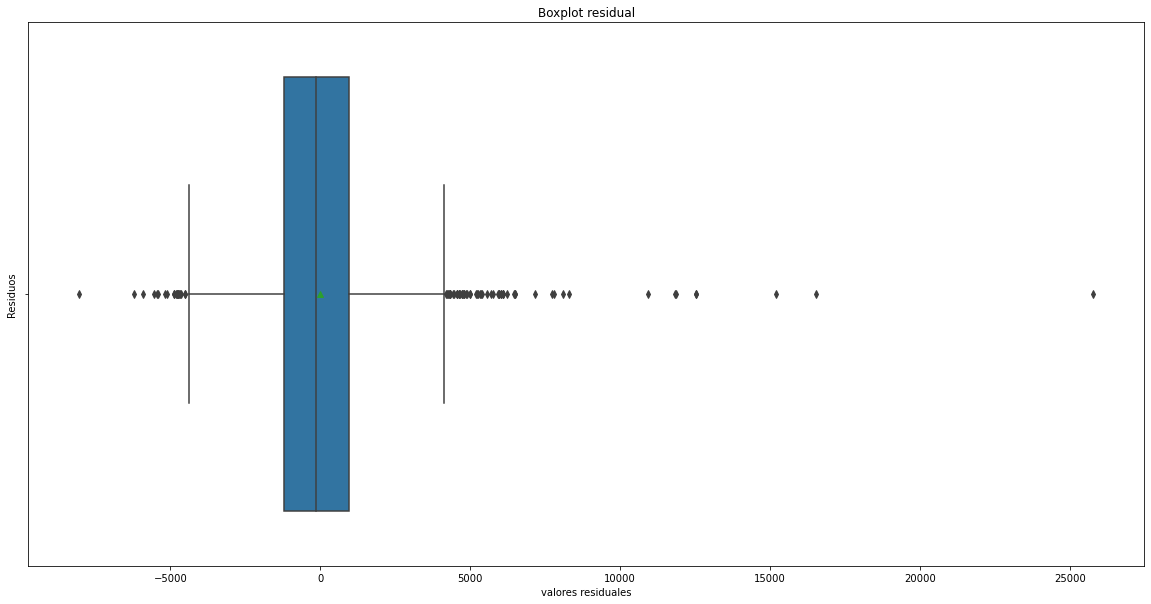



Q-Q plot de los residuos




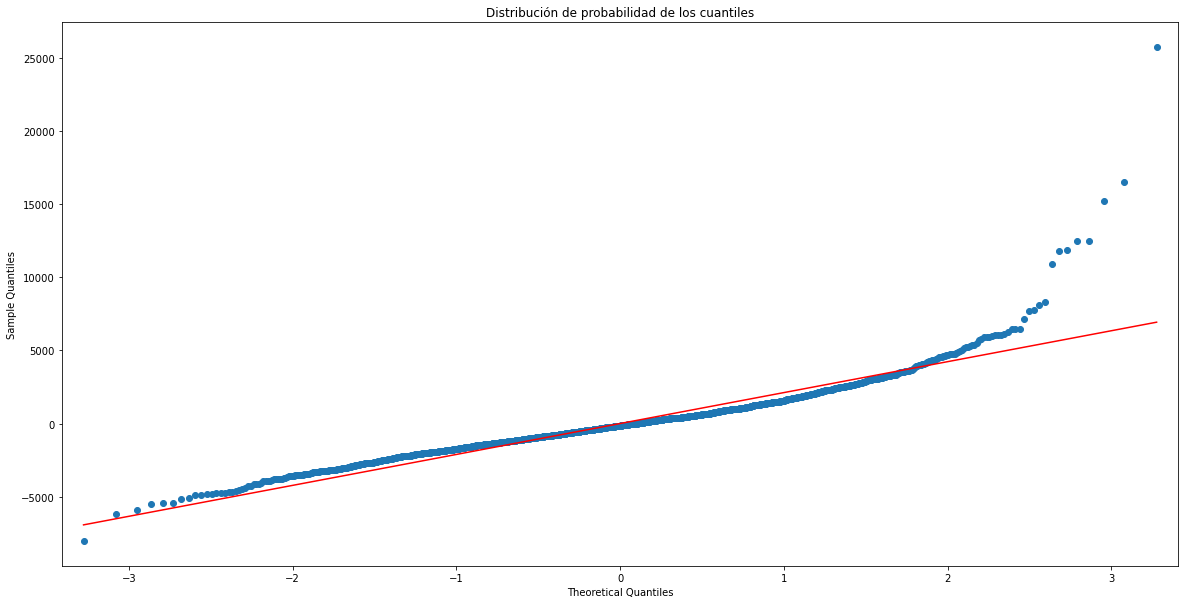



Pruebas estadisticas de la distribución de los residuos:


[('Jarque-Bera', 25238.890997441562), ('Chi^2 two-tail prob.', 0.0), ('Skew', 2.129235490089193), ('Kurtosis', 20.33024049470311)]


Prueba Breusch-Pagan Lagrange Multiplier test for heteroscedasticity:


[('Lagrange multiplier statistic', 81.36386251842248), ('p-value', 0.12823391641460863), ('f-value', 1.204652956554681), ('f p-value', 0.12495179990662982)]


Goldfeld-Quandt test:


[('F statistic', 0.9243440204314664), ('p-value', 0.8786117272514288)]


 68 variables seleccionadas según su significancia estadistica:
Index(['state_16', 'const', 'state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu', 'whitePerCap

In [50]:
stats_regression(X2, Y)

## Modelo 3: Regresión lineal 23 variables más significativas

In [51]:
X3 = xscale[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]

                        Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.566     
Dependent Variable:      y                    AIC:                    34824.6061
Date:                    2022-09-19 12:30     BIC:                    34957.8220
No. Observations:        1902                 Log-Likelihood:         -17388.   
Df Model:                23                   F-statistic:            108.8     
Df Residuals:            1878                 Prob (F-statistic):     0.00      
R-squared:               0.571                Scale:                  5.1735e+06
--------------------------------------------------------------------------------
                        Coef.     Std.Err.    t    P>|t|     [0.025     0.975]  
--------------------------------------------------------------------------------
const                 16832.7762 1076.4407 15.6374 0.0000  14721.6307 18943.9218
state_16               2034.4869  280.1302  7.2626 0.

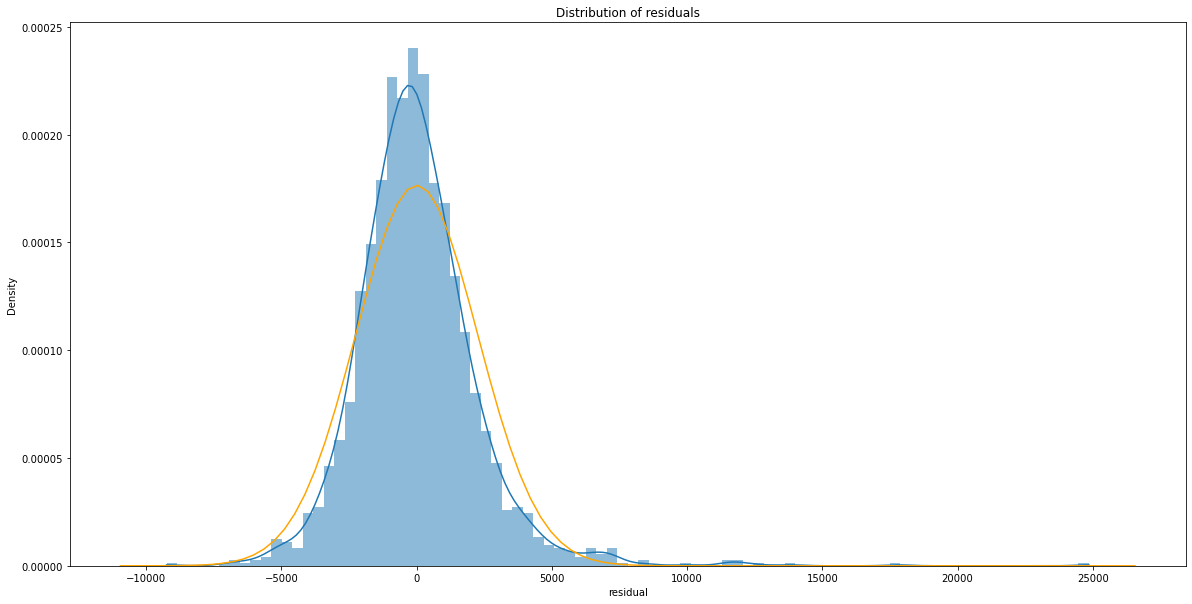

mu, std: 2.838465062946426e-11  2260.1278178656144


Boxplot de los residuos




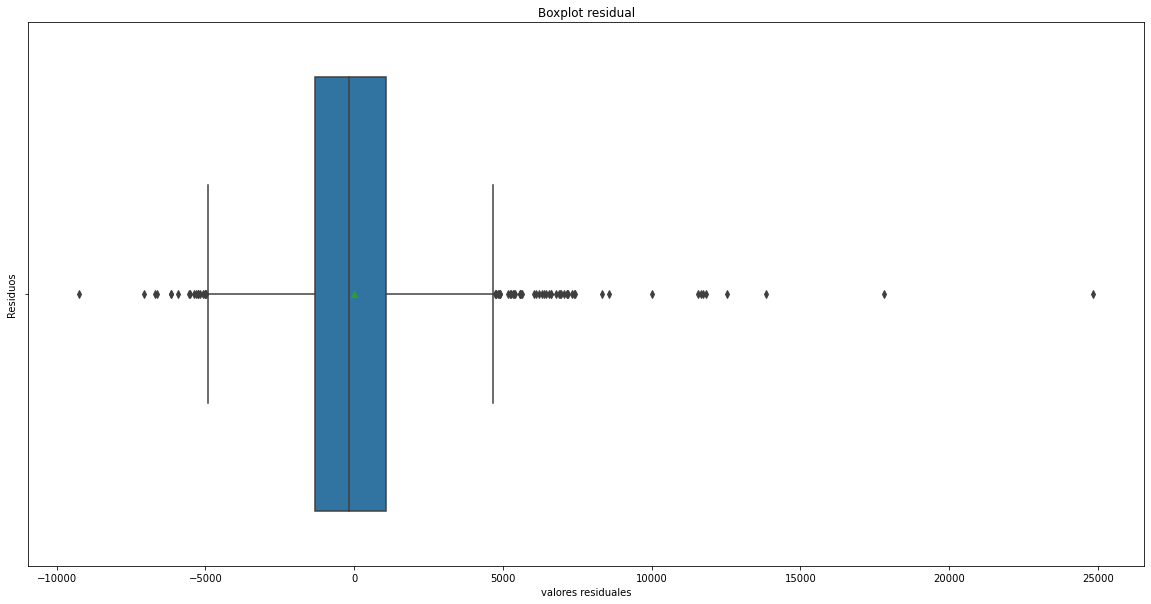



Q-Q plot de los residuos




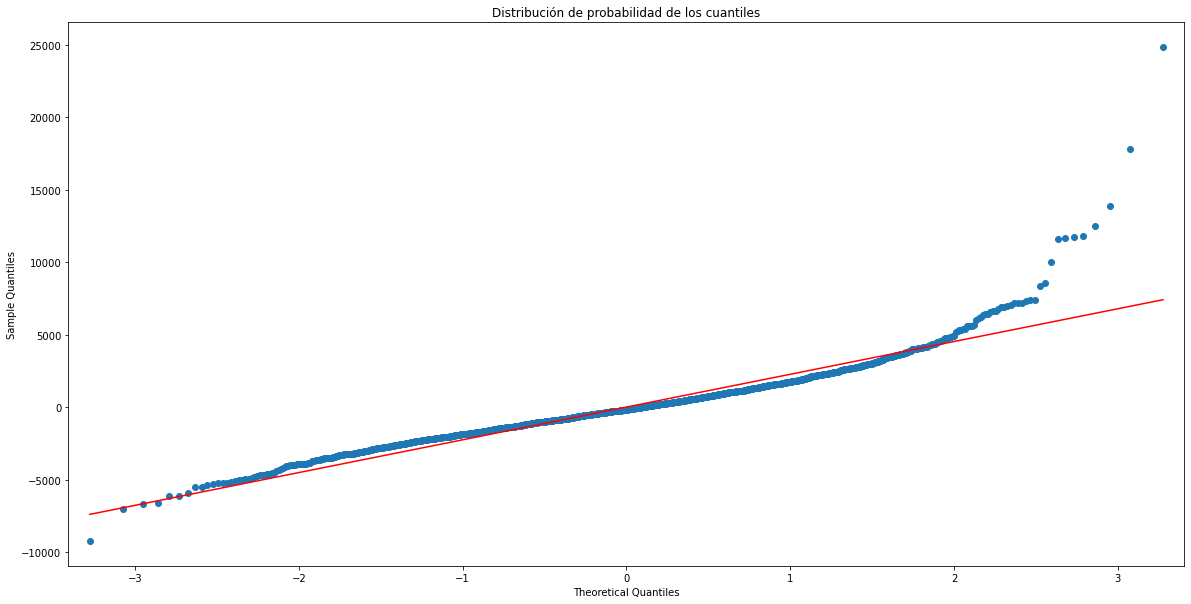



Pruebas estadisticas de la distribución de los residuos:


[('Jarque-Bera', 13375.54251318823), ('Chi^2 two-tail prob.', 0.0), ('Skew', 1.7207560959773498), ('Kurtosis', 15.527272469026757)]


Prueba Breusch-Pagan Lagrange Multiplier test for heteroscedasticity:


[('Lagrange multiplier statistic', 66.21735903364197), ('p-value', 4.599532140846254e-06), ('f-value', 2.94522412143043), ('f p-value', 3.603646323463654e-06)]


Goldfeld-Quandt test:


[('F statistic', 0.9533928973960347), ('p-value', 0.7661884630289252)]


 68 variables seleccionadas según su significancia estadistica:
Index(['PctKidsBornNeverMar', 'const', 'state_16', 'PopDens',
       'PctSpeakEnglOnly', 'householdsize', 'RentLowQ', 'state_17',
       'PctVacMore6Mos', 'state_2', 'state_21', 'PctLess9thGrade',
       'PctPersOwnOccup', 'state_5', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'MedOwnCostPctIncNoMtg', 'state_14', 'PctBSorMore',
       'PctEmplManu', 'state_13', 'state_3', 'state_29'],
      d

In [52]:
stats_regression(X3, Y)

 Variable: state_16
eval_env: 1




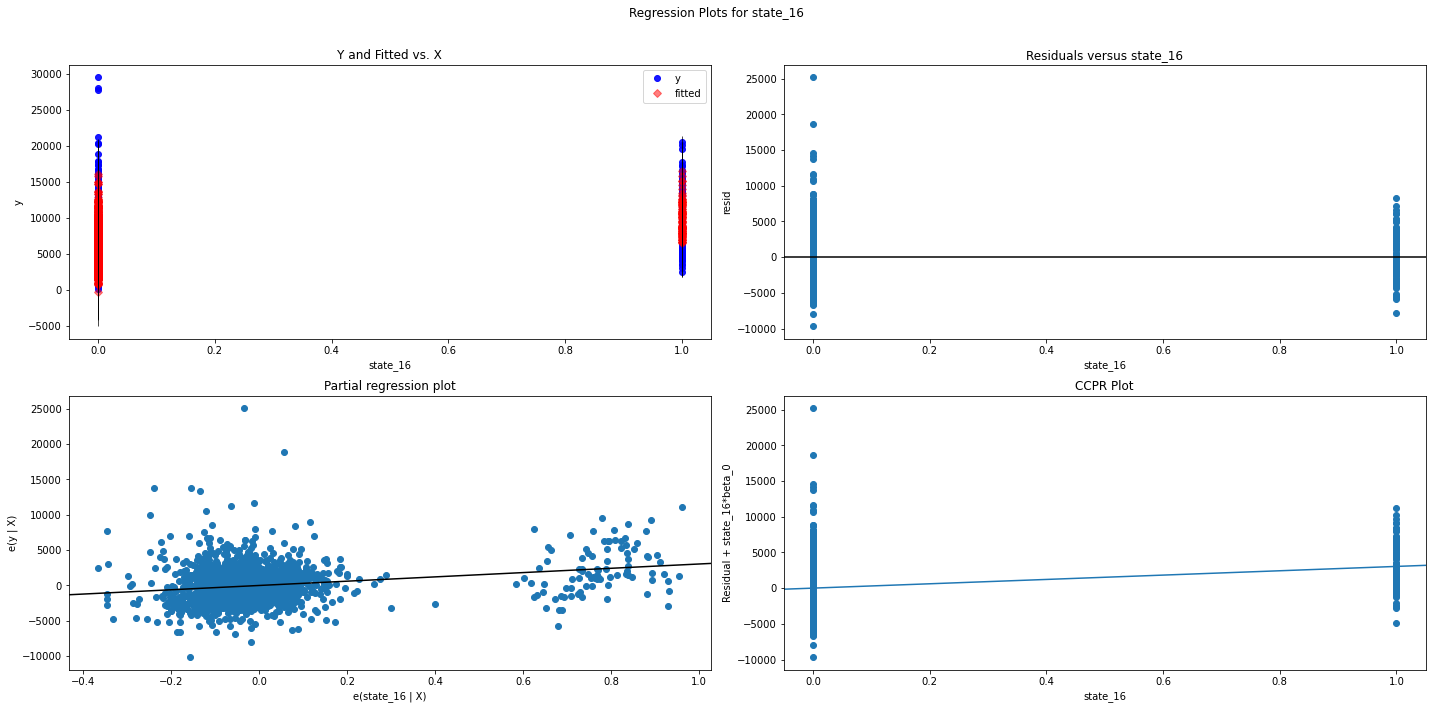

 Variable: state_17
eval_env: 1




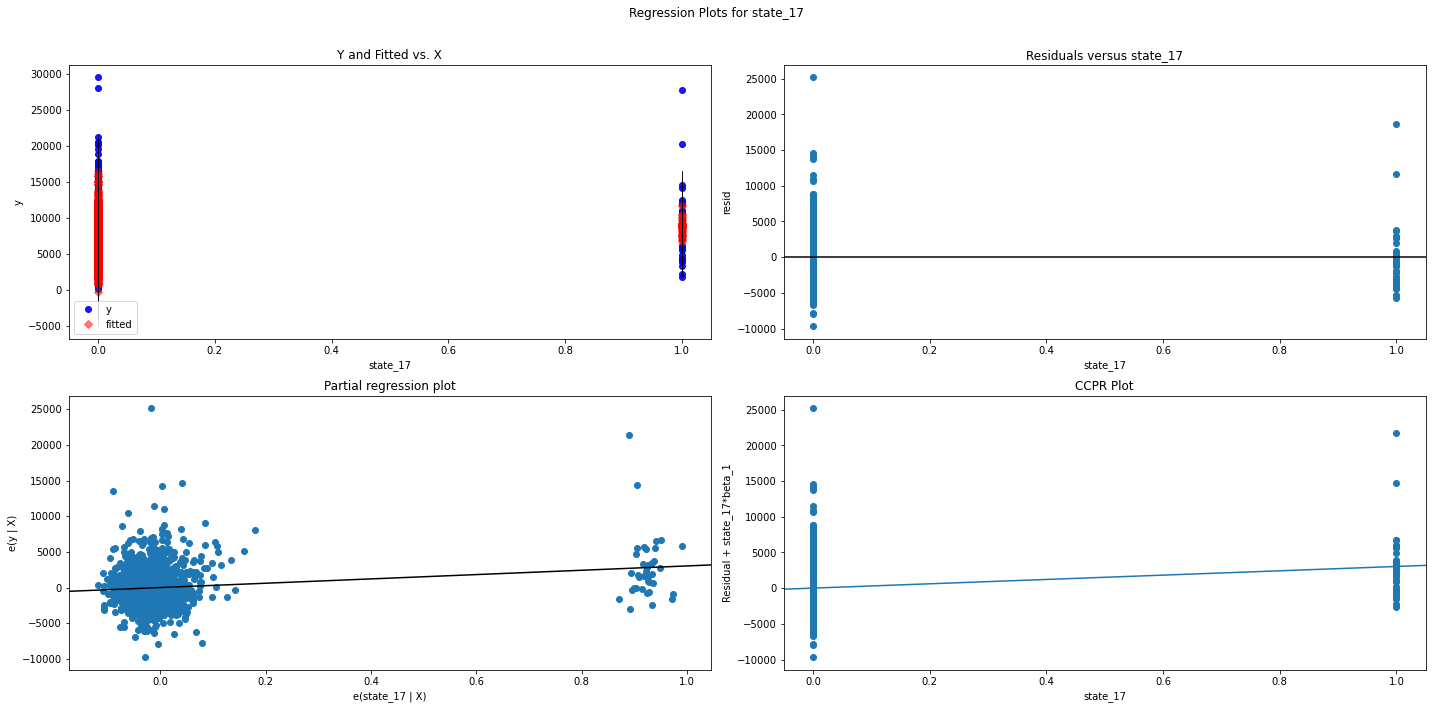

 Variable: PopDens
eval_env: 1




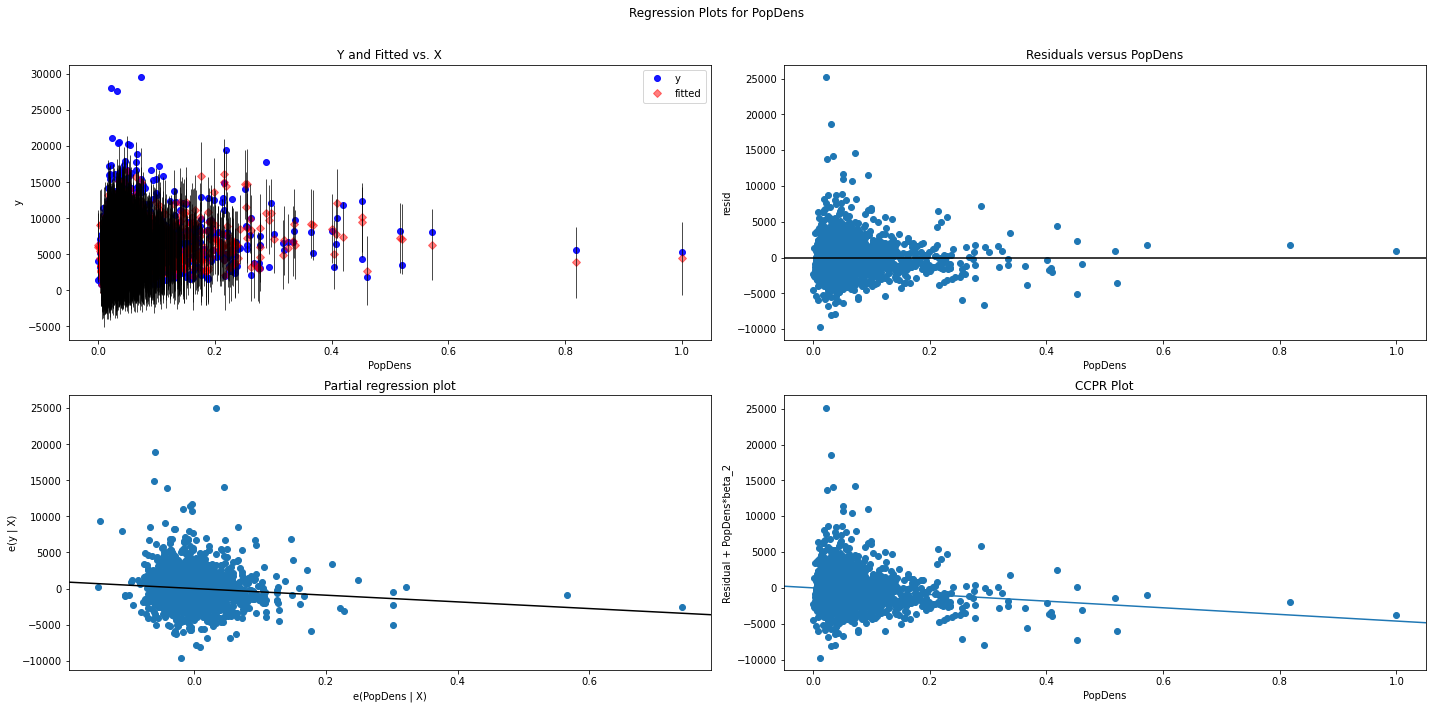

 Variable: state_2
eval_env: 1




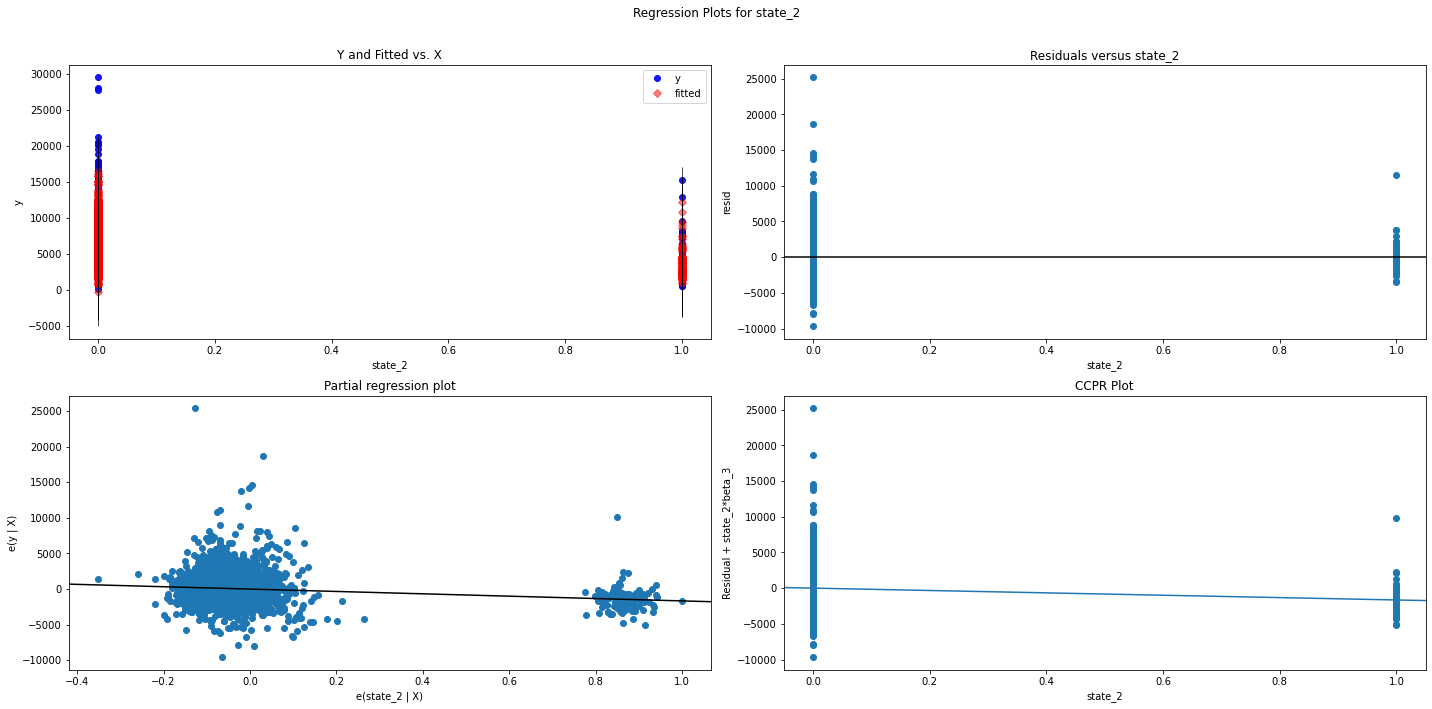

 Variable: PctKidsBornNeverMar
eval_env: 1




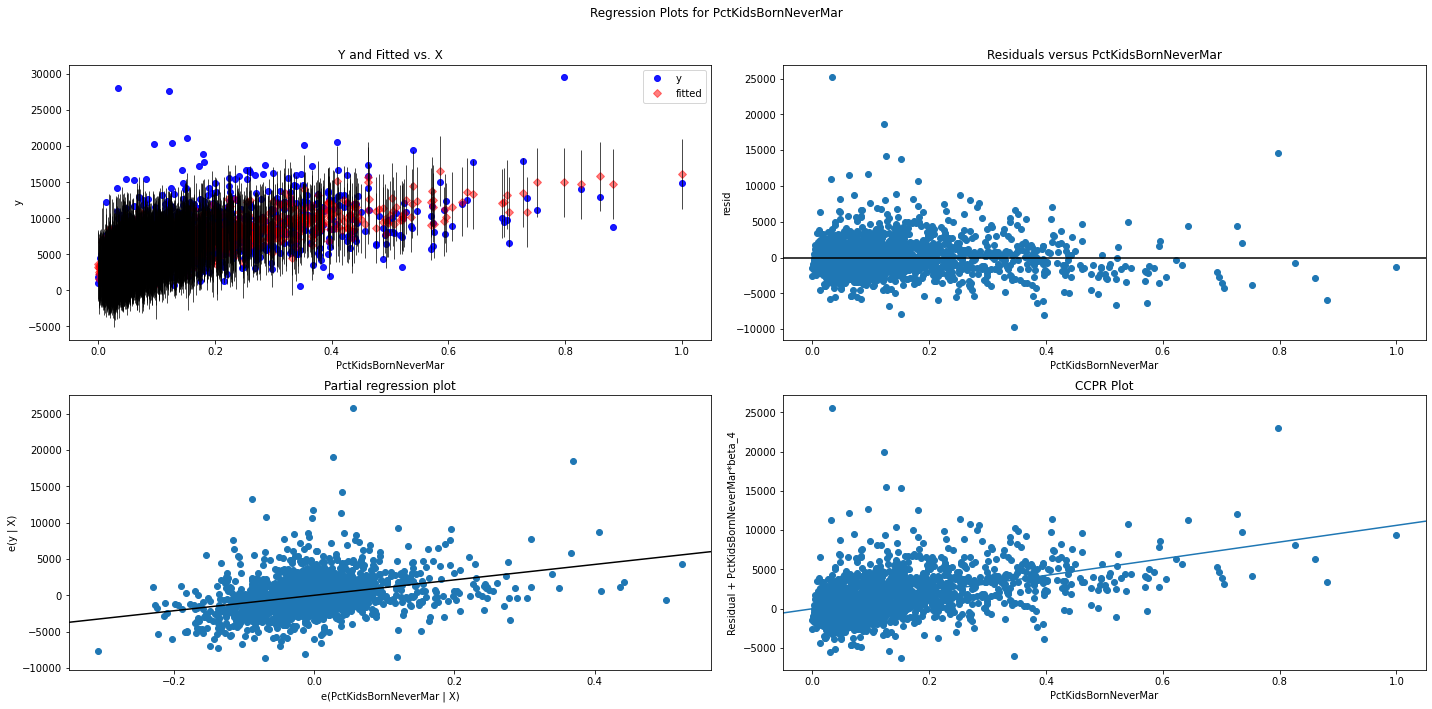

 Variable: PctVacMore6Mos
eval_env: 1




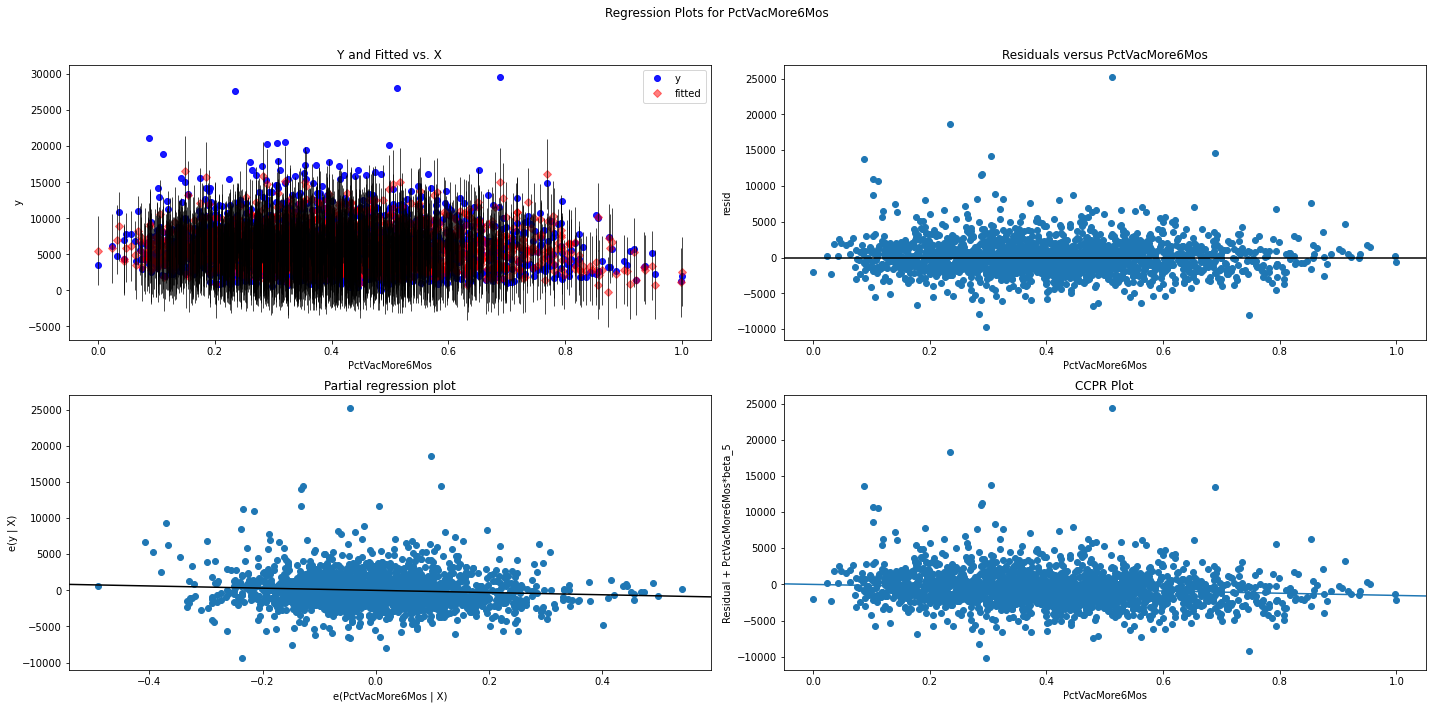

 Variable: PctLess9thGrade
eval_env: 1




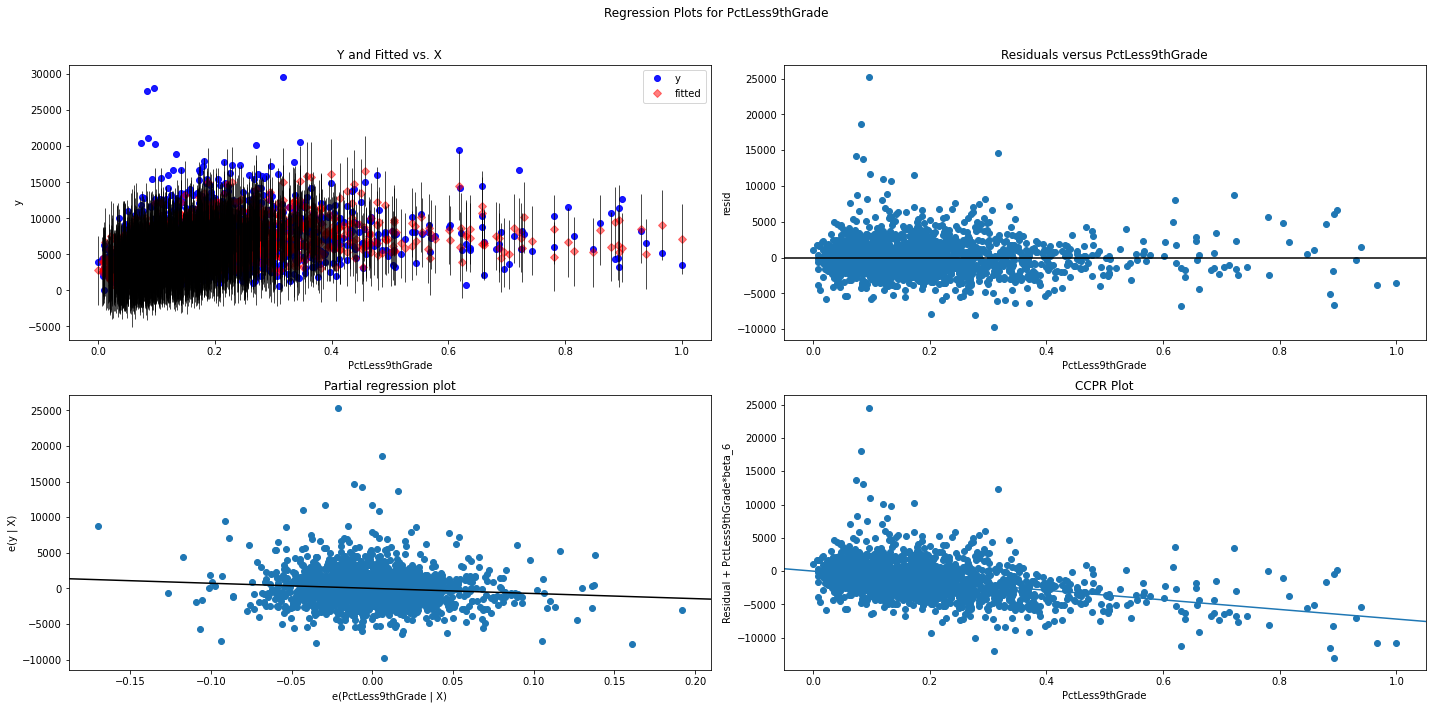

 Variable: householdsize
eval_env: 1




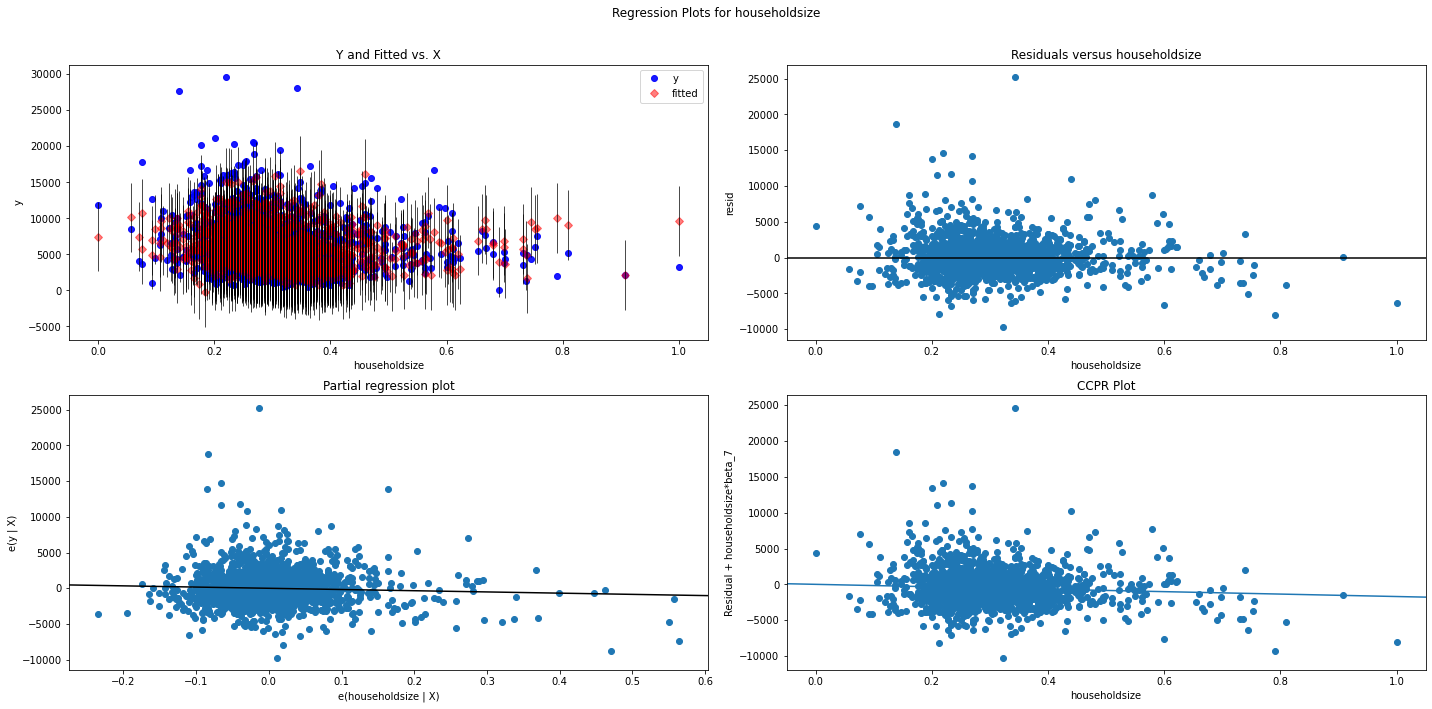

 Variable: state_13
eval_env: 1




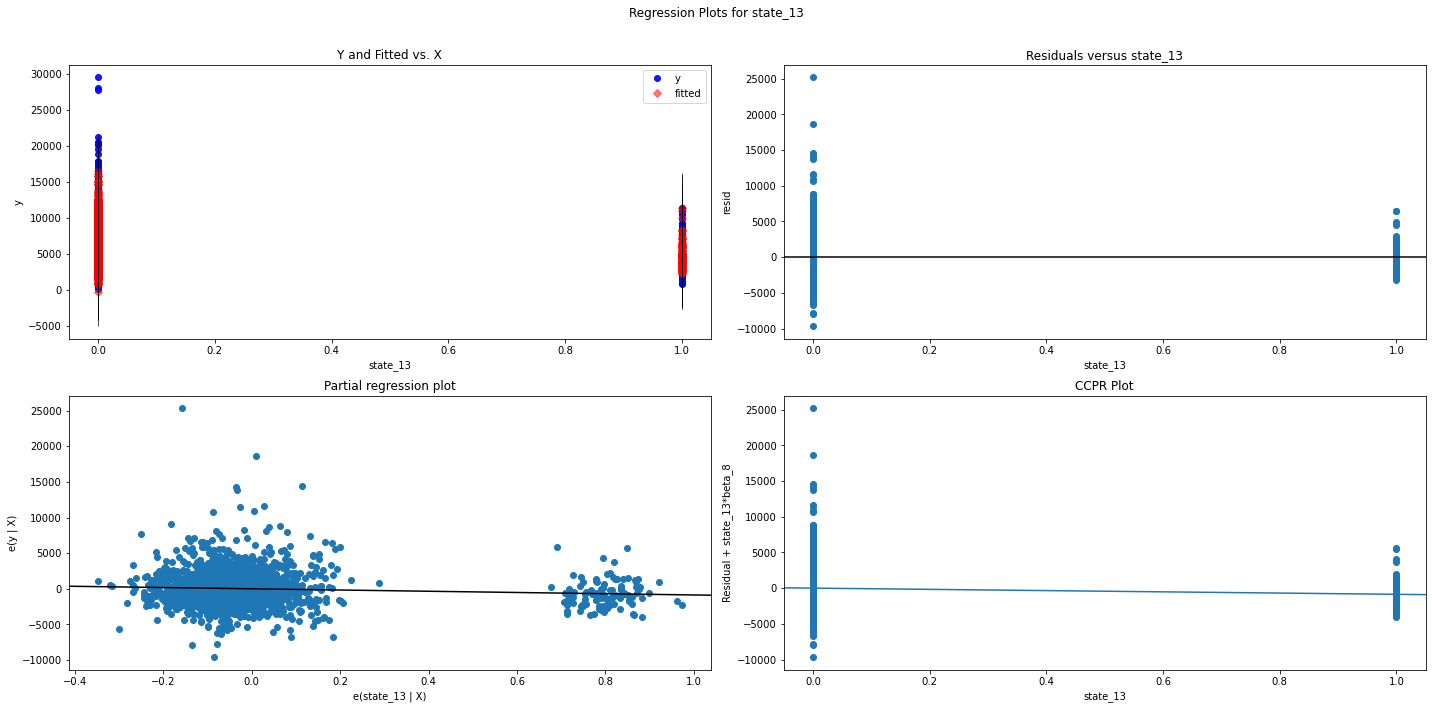

 Variable: MedOwnCostPctIncNoMtg
eval_env: 1




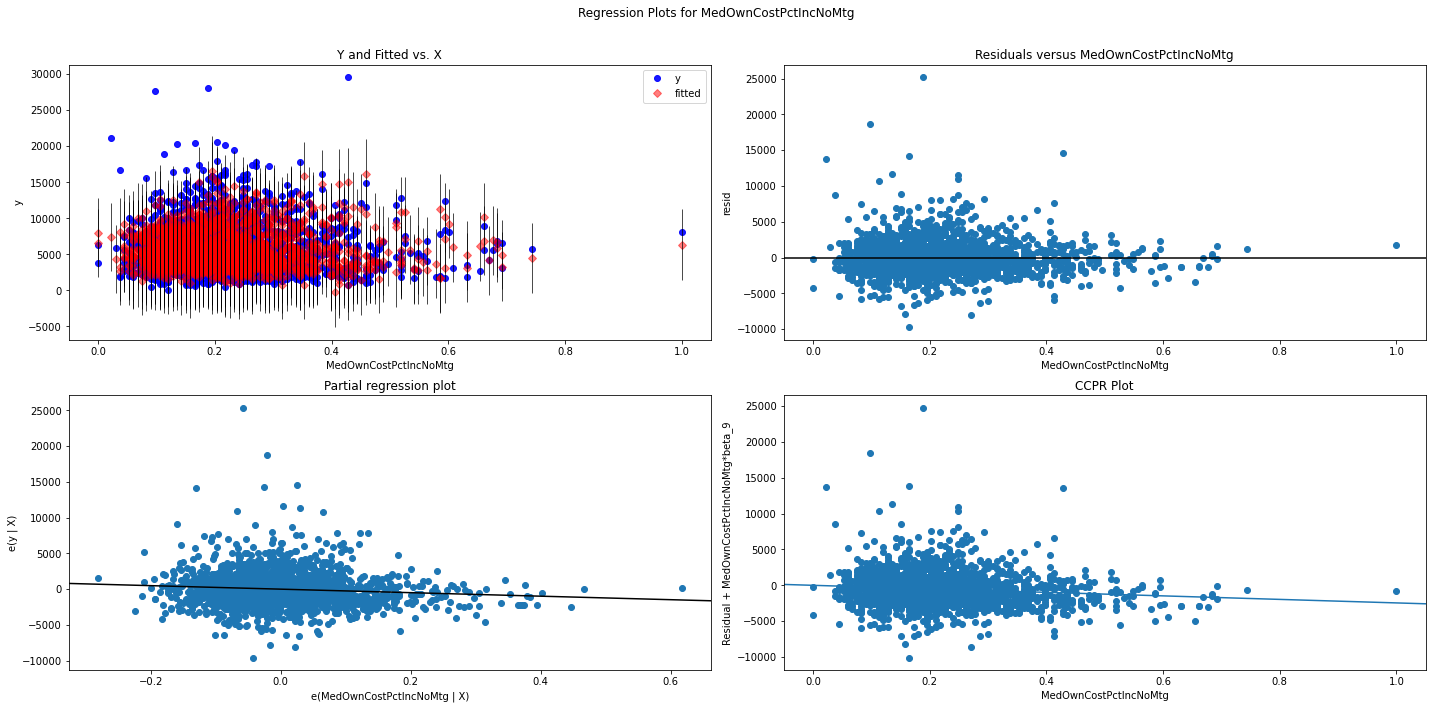

 Variable: state_5
eval_env: 1




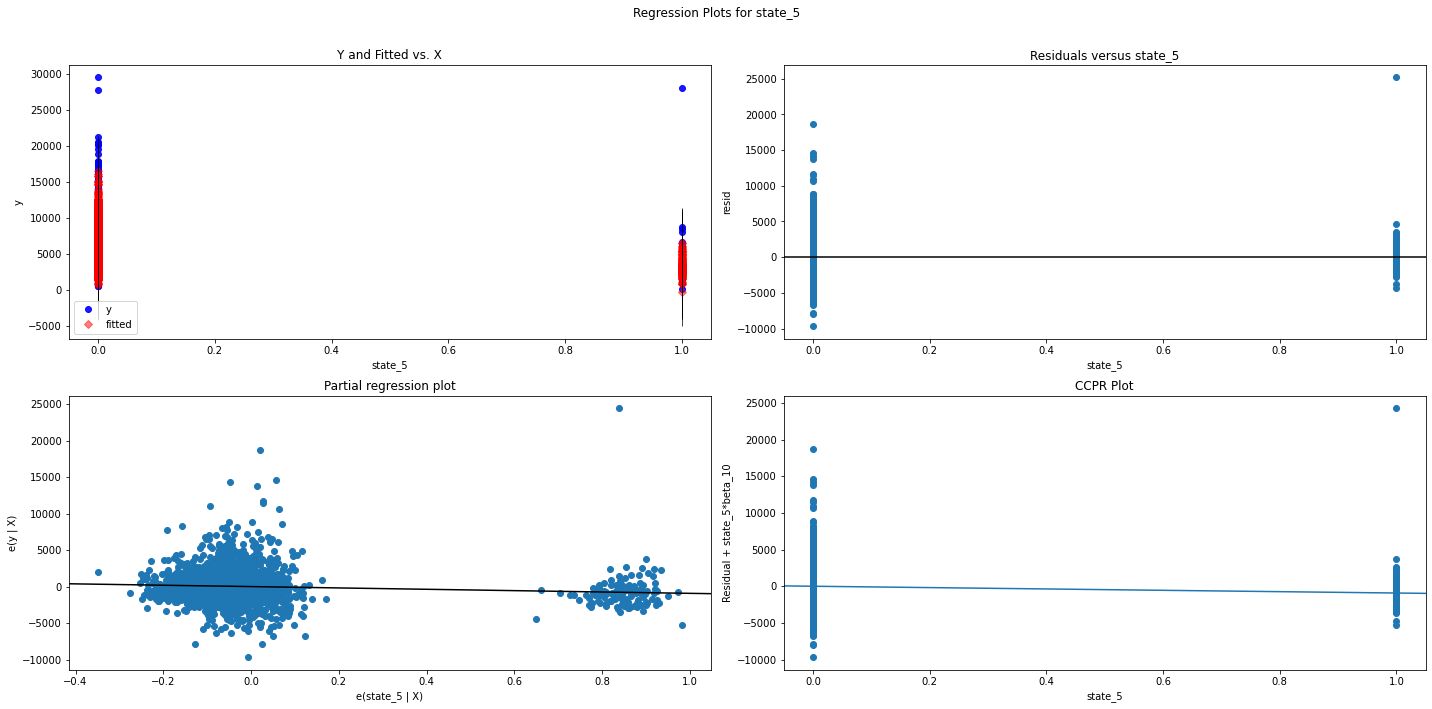

 Variable: state_14
eval_env: 1




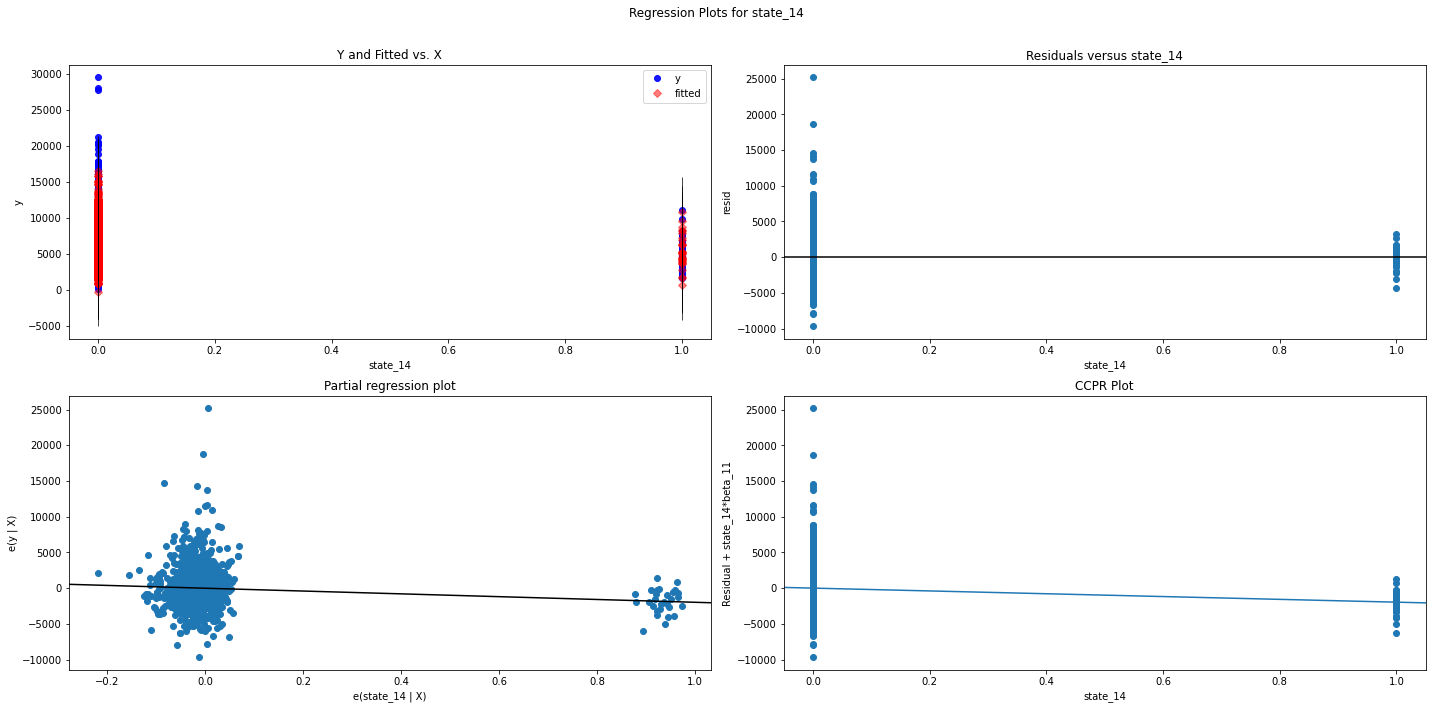

 Variable: PctPersOwnOccup
eval_env: 1




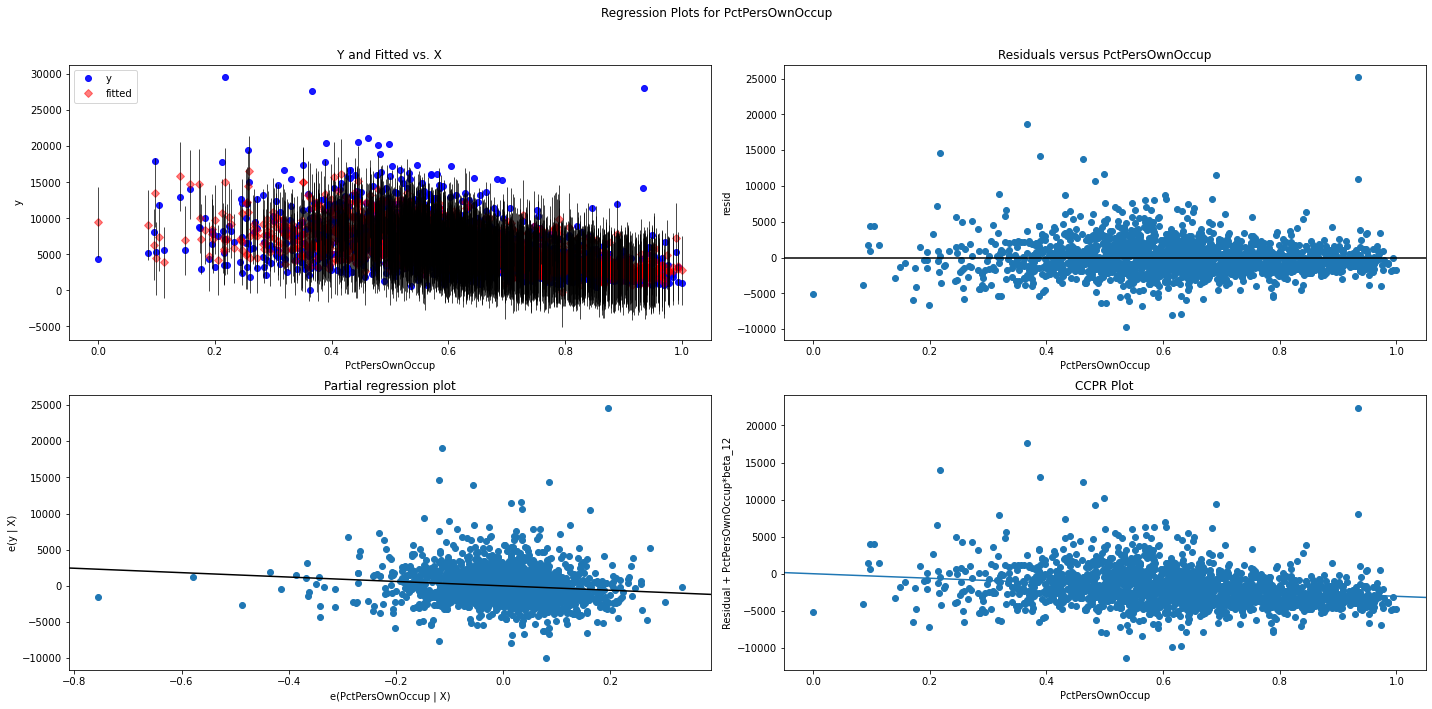

 Variable: PctHousOccup
eval_env: 1




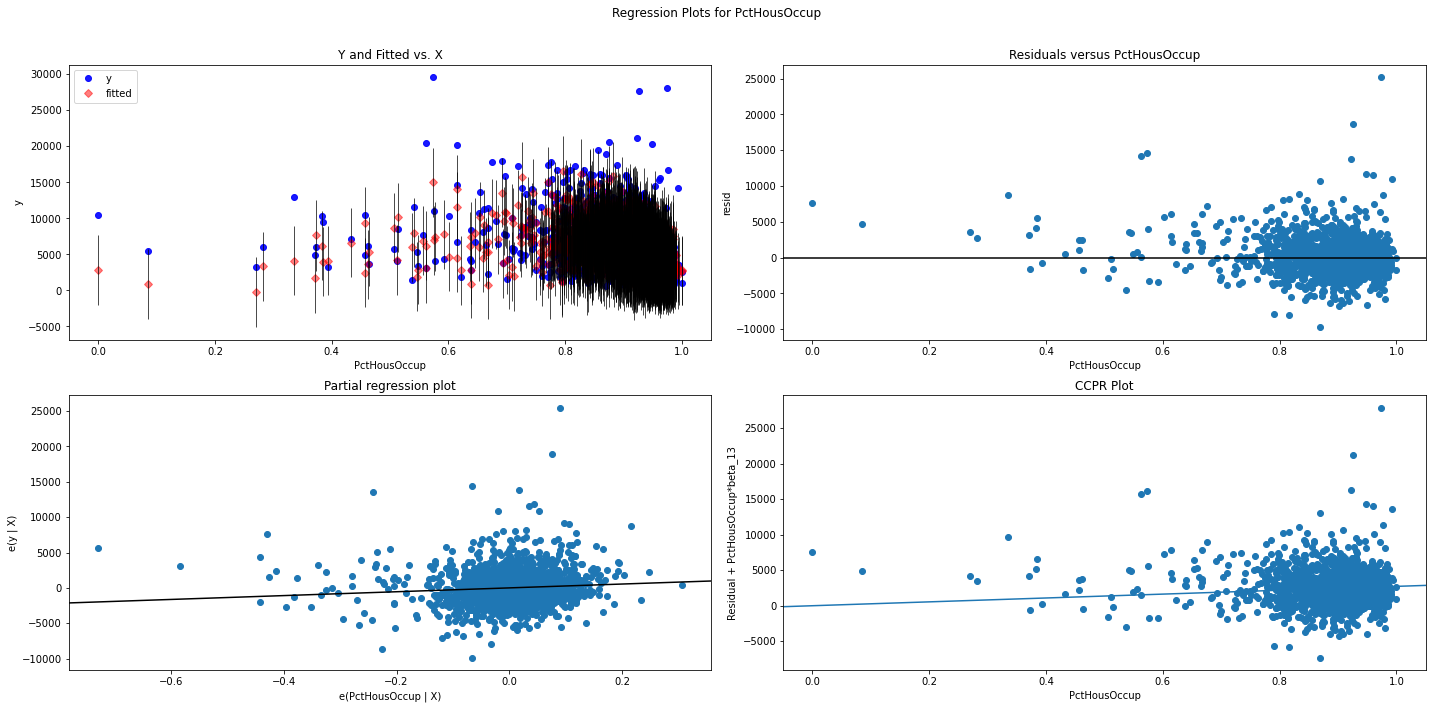

 Variable: PctNotHSGrad
eval_env: 1




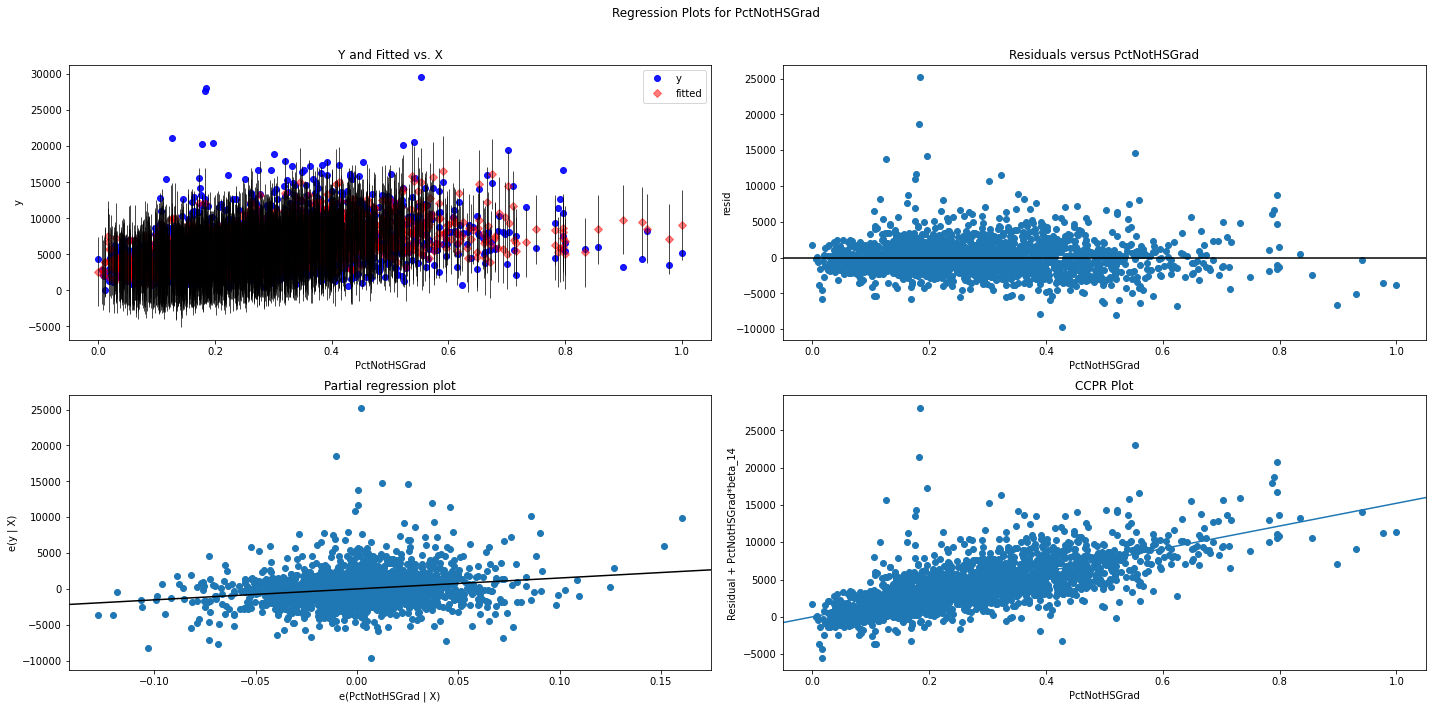

 Variable: PctOccupMgmtProf
eval_env: 1




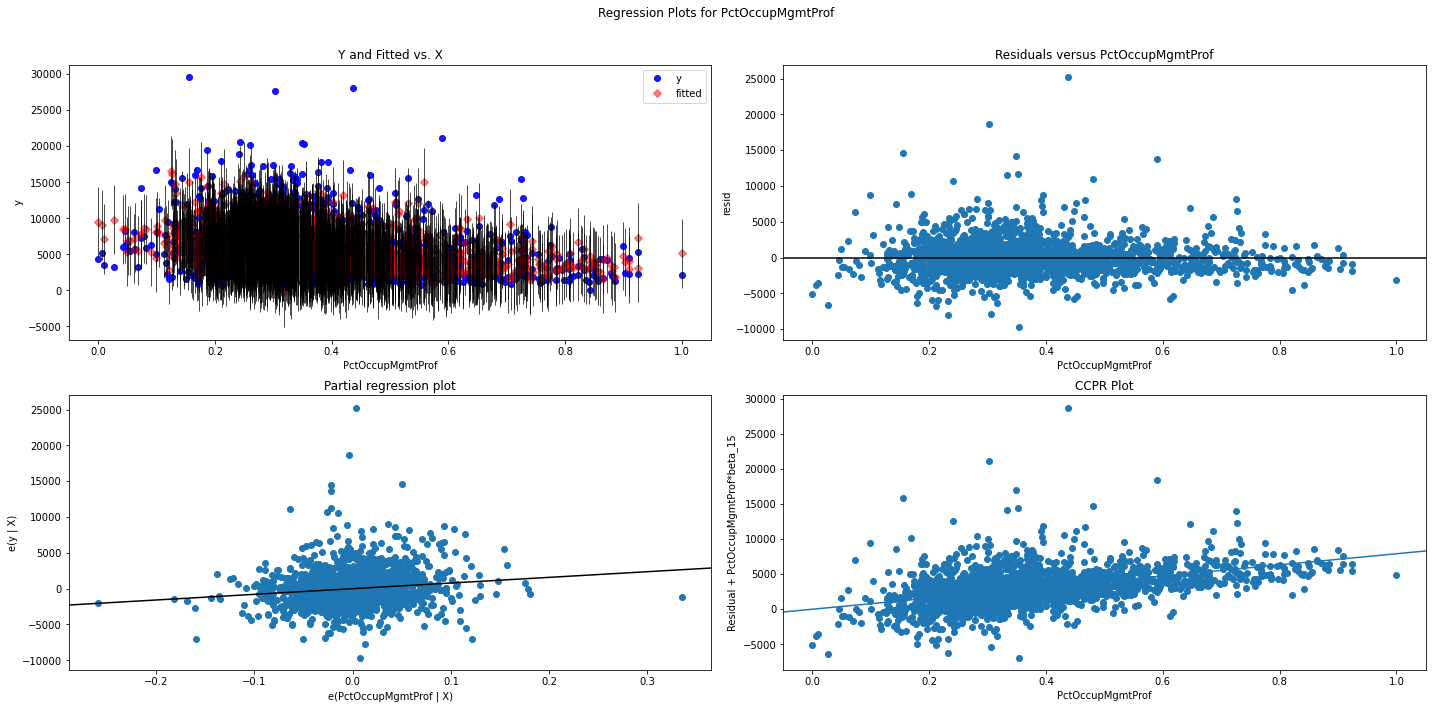

 Variable: state_29
eval_env: 1




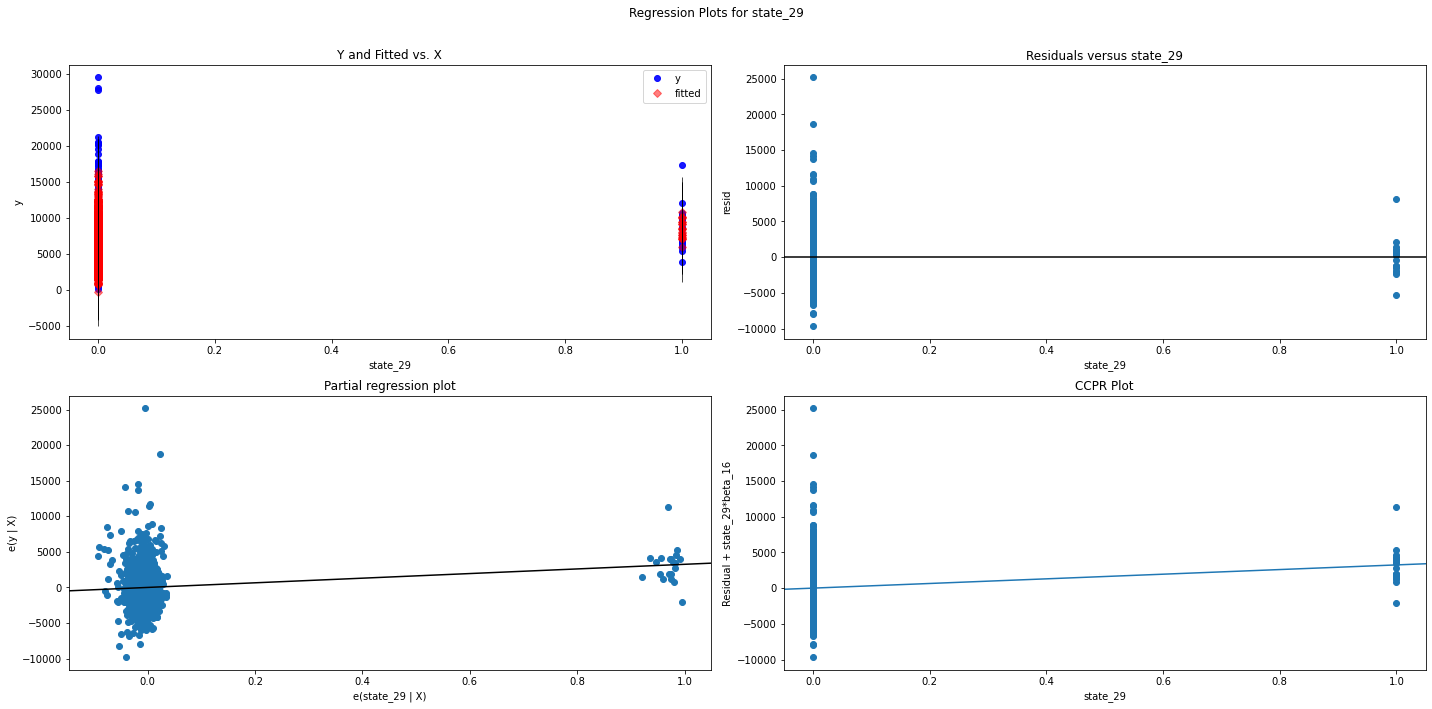

 Variable: state_21
eval_env: 1




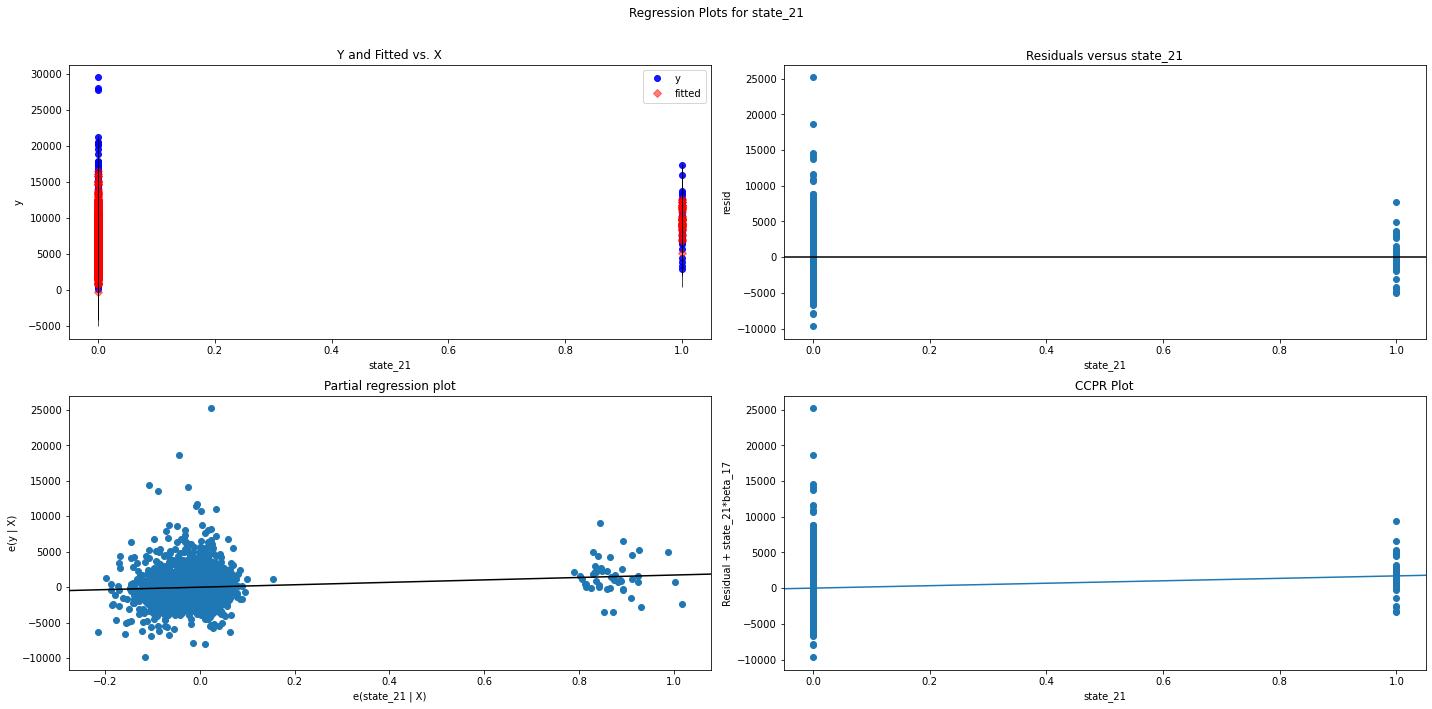

 Variable: RentLowQ
eval_env: 1




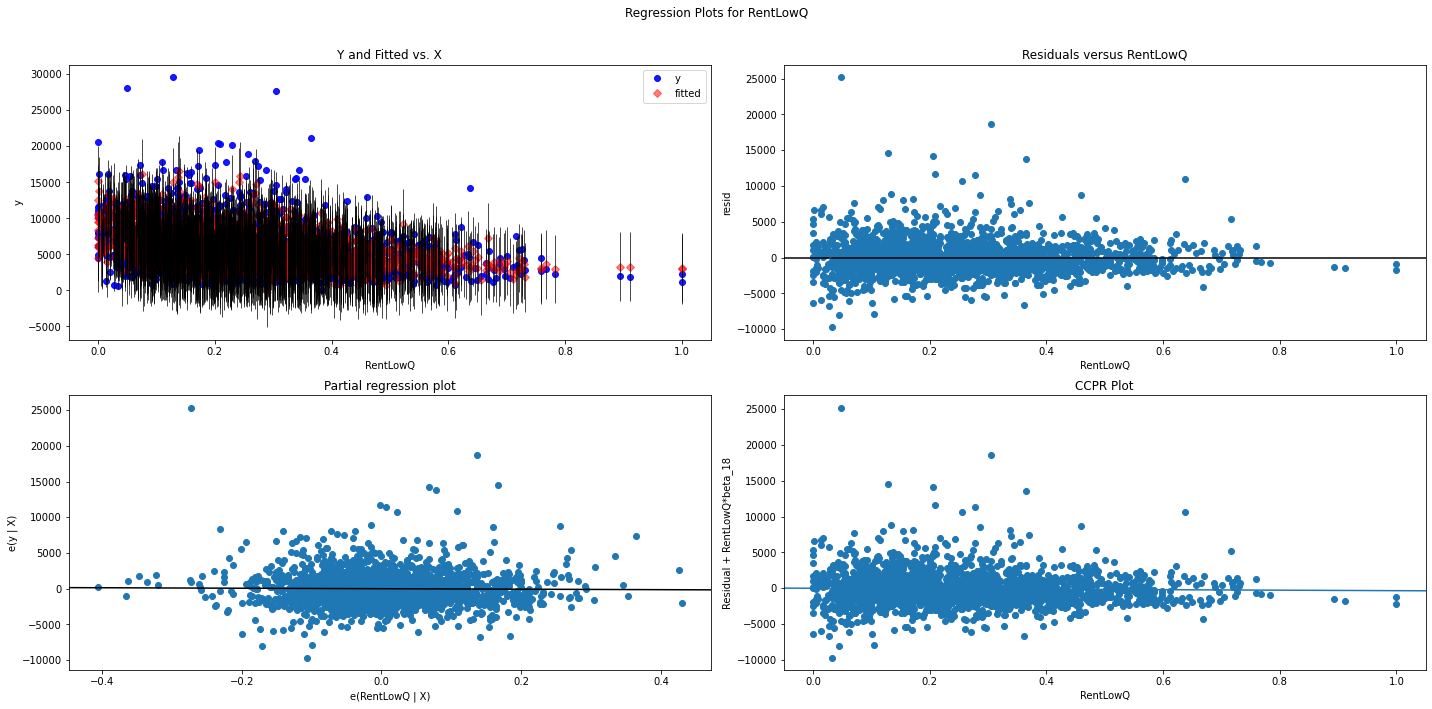

 Variable: PctBSorMore
eval_env: 1




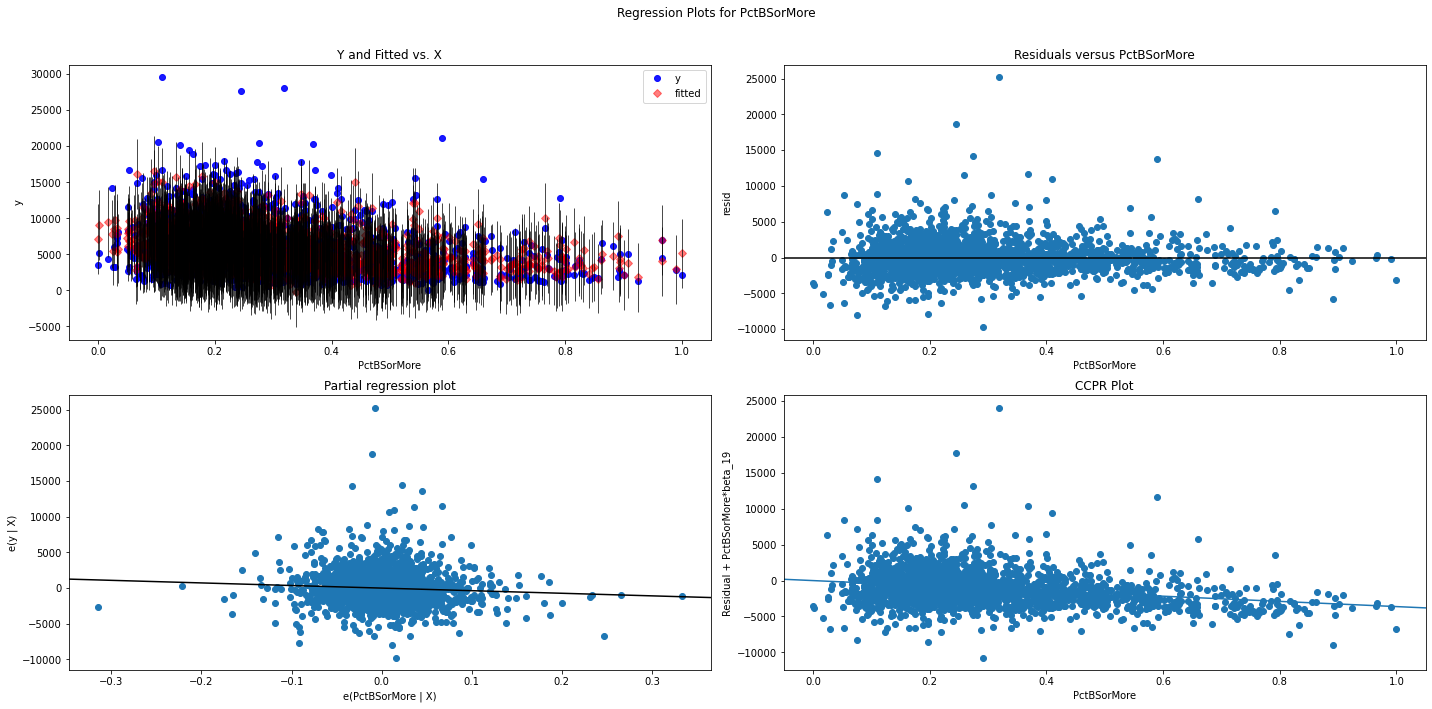

 Variable: state_3
eval_env: 1




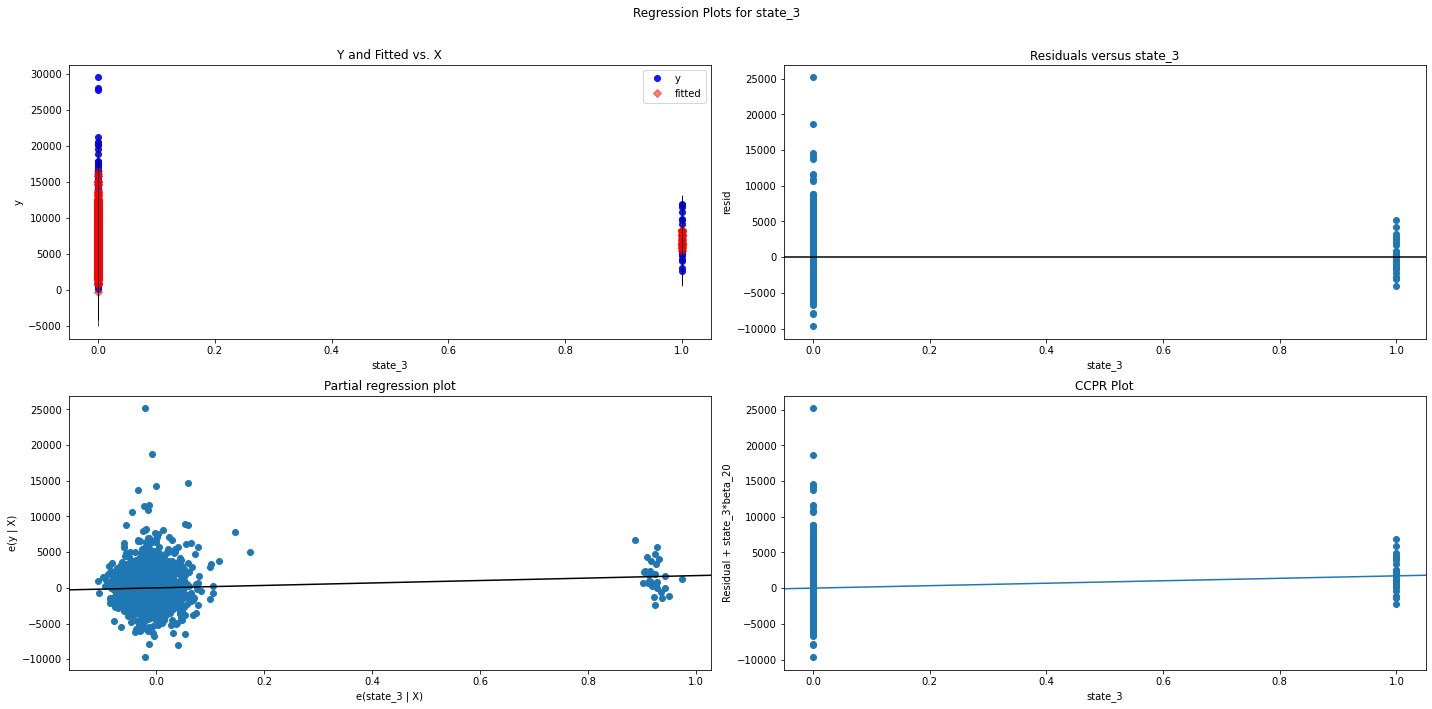

 Variable: PctSpeakEnglOnly
eval_env: 1




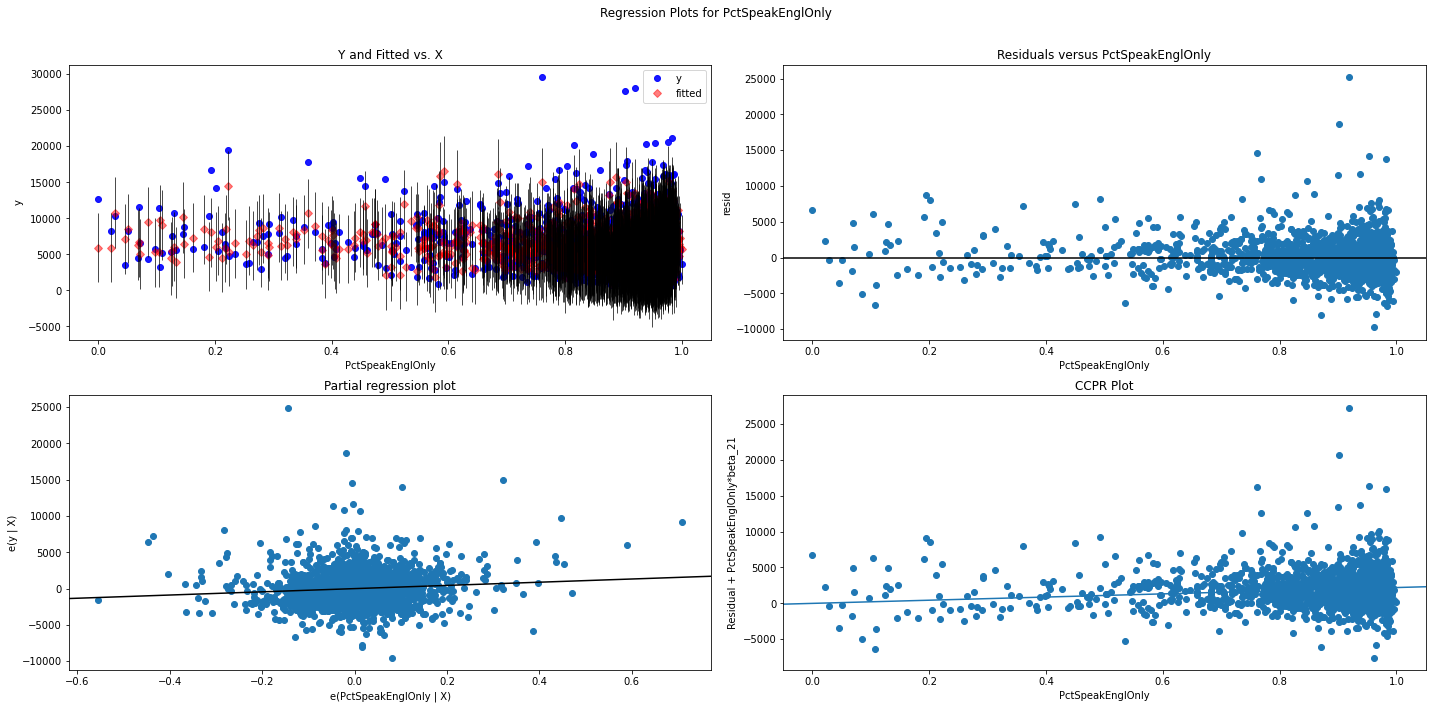

 Variable: PctEmplManu
eval_env: 1




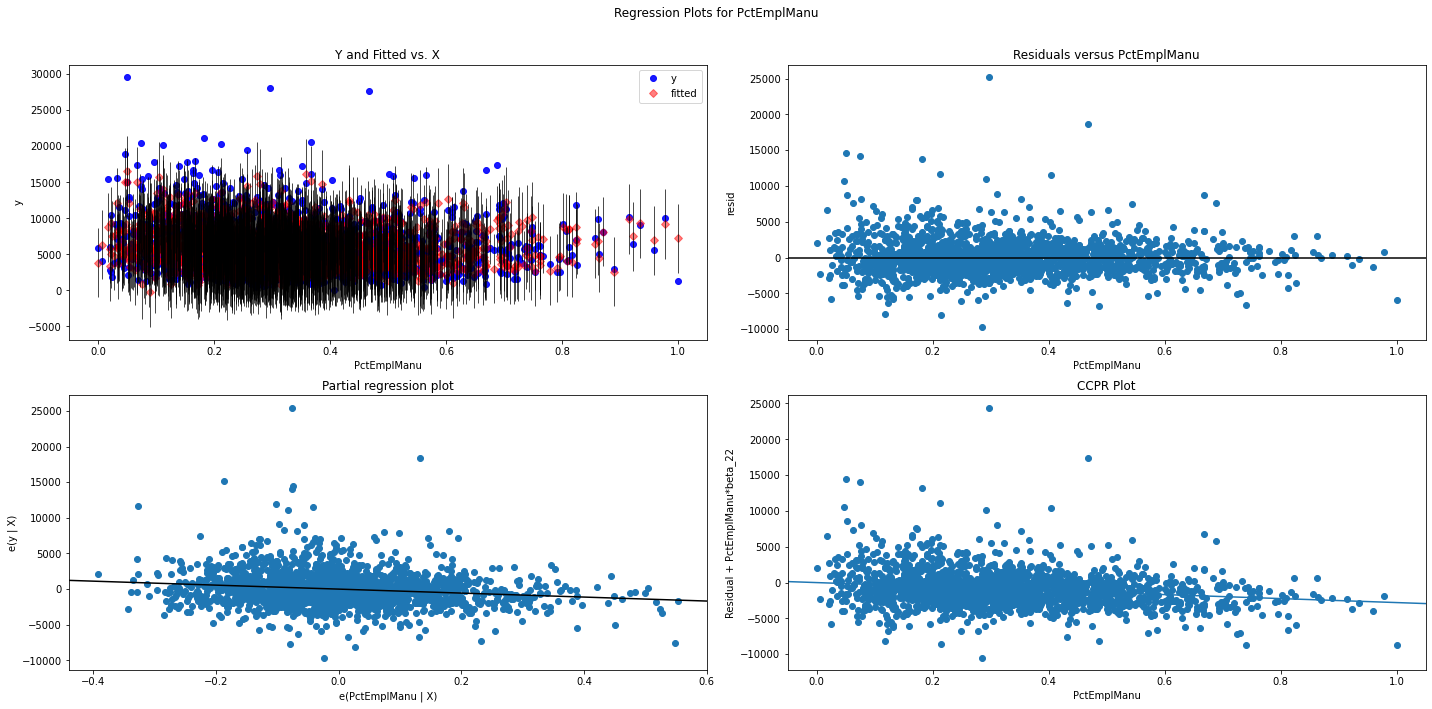

In [53]:
import statsmodels
M3 = sm.add_constant(X3)
model3 = sm.OLS(Y, X3)
result3 = model3.fit()

for i in X3:
    print(' Variable:', i )
    statsmodels.graphics.regressionplots.plot_regress_exog(result3, i, fig = None)
    print( '\n' ) 
    plt.show()

## MODELO 4: Regresión Polinomial (DEGREE = 1) 

In [56]:
# creamos la variable que transformará nuestras variables independientes polinomialmente
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 1, include_bias = False)
poly_features

PolynomialFeatures(degree=1, include_bias=False)

In [57]:
# almacenamos variable
X4 = poly_features.fit_transform(xscale[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']])


                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.566     
Dependent Variable: y                AIC:                34824.6061
Date:               2022-09-19 12:31 BIC:                34957.8220
No. Observations:   1902             Log-Likelihood:     -17388.   
Df Model:           23               F-statistic:        108.8     
Df Residuals:       1878             Prob (F-statistic): 0.00      
R-squared:          0.571            Scale:              5.1735e+06
-------------------------------------------------------------------
           Coef.     Std.Err.    t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const    16832.7762 1076.4407 15.6374 0.0000  14721.6307 18943.9218
x1        2034.4869  280.1302  7.2626 0.0000   1485.0877  2583.8860
x2        2404.2019  381.2642  6.3059 0.0000   1656.4558  3151.9479
x3       -7977.7033 1121.9533 -7.1105 0.0000 -10178.1095 -5777.297

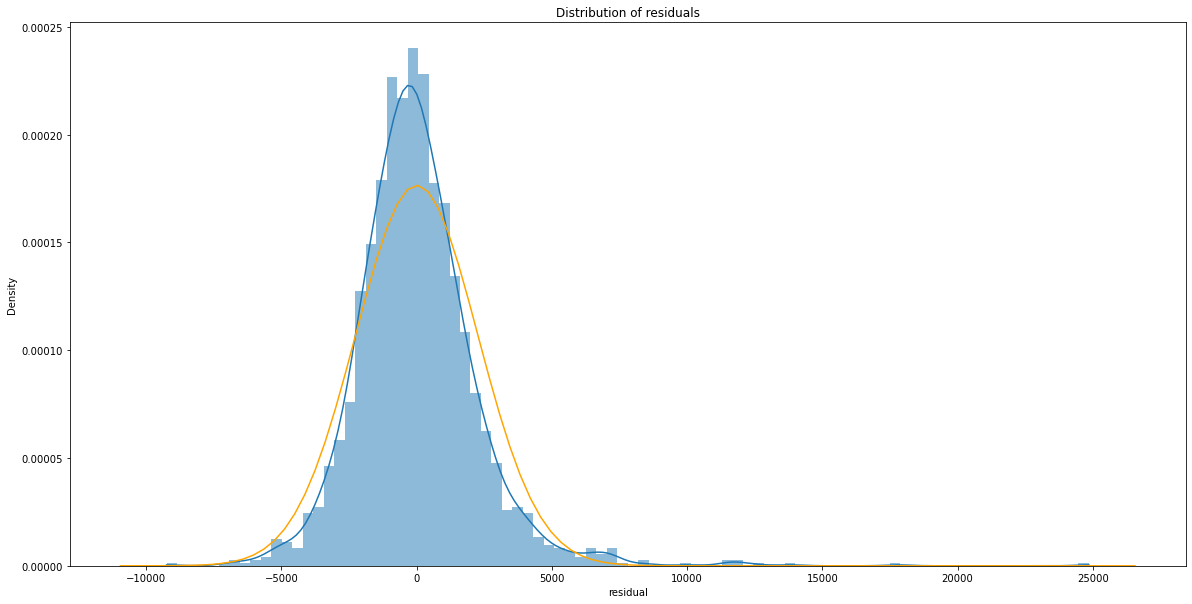

mu, std: 2.836934893101172e-11  2260.1278178656144


Boxplot de los residuos




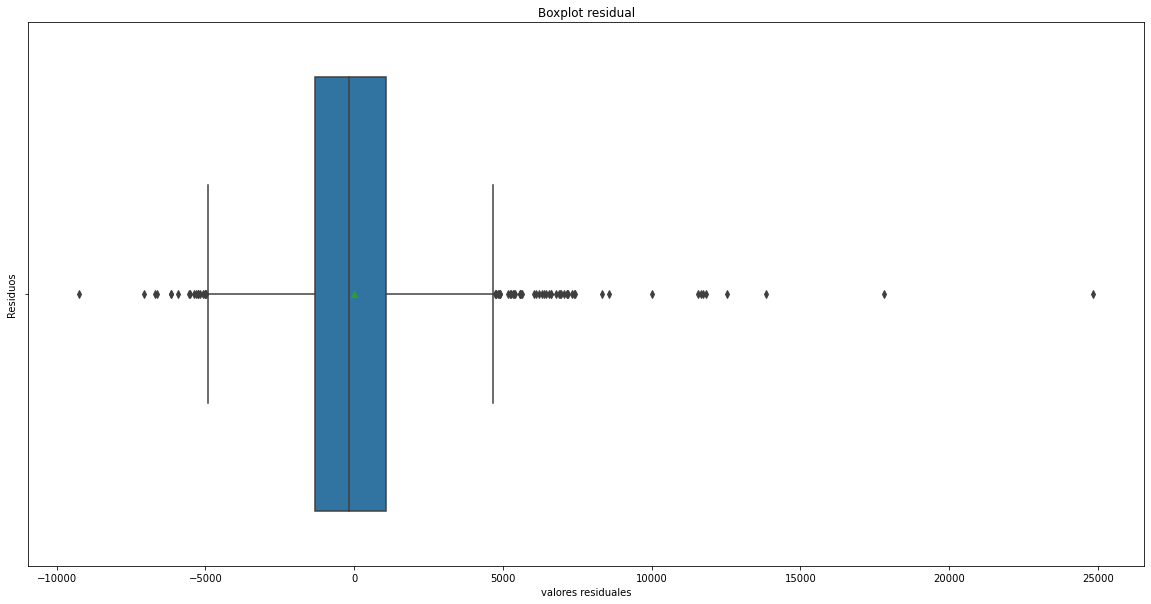



Q-Q plot de los residuos




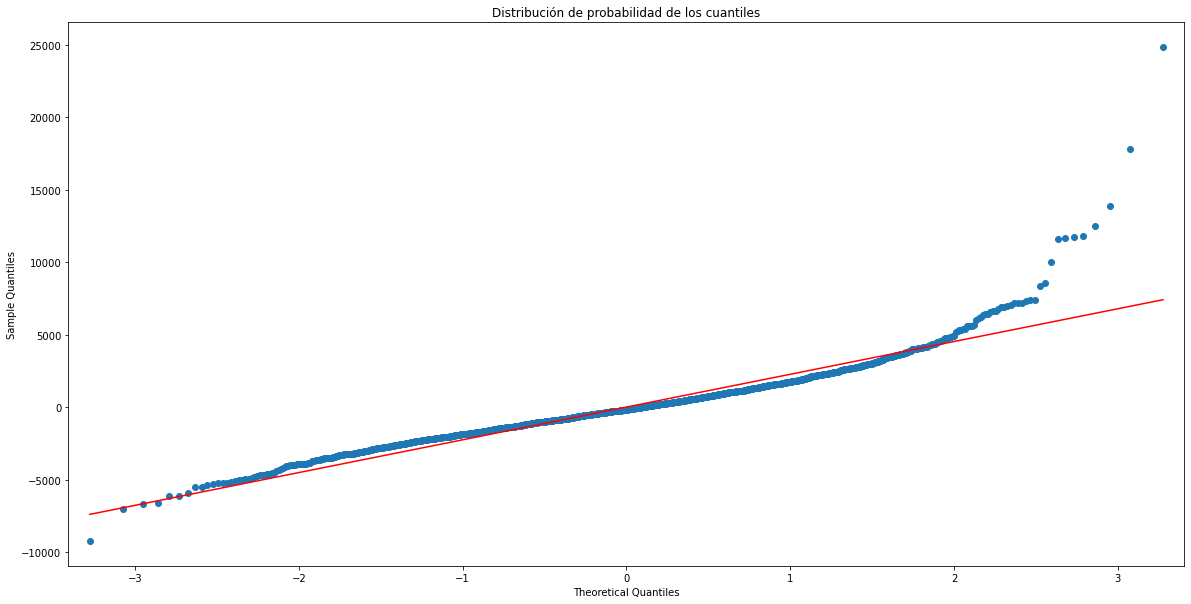



Pruebas estadisticas de la distribución de los residuos:


[('Jarque-Bera', 13375.54251318823), ('Chi^2 two-tail prob.', 0.0), ('Skew', 1.7207560959773494), ('Kurtosis', 15.527272469026757)]


Prueba Breusch-Pagan Lagrange Multiplier test for heteroscedasticity:


[('Lagrange multiplier statistic', 66.21735903364176), ('p-value', 4.599532140846603e-06), ('f-value', 2.9452241214304156), ('f p-value', 3.6036463234638654e-06)]


Goldfeld-Quandt test:


[('F statistic', 0.9533928973960353), ('p-value', 0.7661884630289226)]


 68 variables seleccionadas según su significancia estadistica:
Int64Index([ 5,  0,  1,  3, 22,  8, 19,  2,  6,  4, 18,  7, 13, 11, 14, 15, 16,
            10, 12, 20, 23,  9, 21, 17],
           dtype='int64')


 23 variables seleccionadas según su significancia estadistica:
Int64Index([ 5,  0,  1,  3, 22,  8, 19,  2,  6,  4, 18,  7, 13, 11, 14, 15, 16,
            10, 12, 20, 23,  9, 21, 17],
           dtype='int64')


In [58]:
stats_regression(X4, Y)

## MODELO 5: Modelo RIDGE

In [59]:
X5 = xscale[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]


In [60]:
from sklearn.linear_model import Ridge
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X5, Y, test_size=0.2, random_state=42)
ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge, parameters , scoring = 'neg_mean_squared_error' , cv = 5)
ridge_regressor.fit(X_train , y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20]},
             scoring='neg_mean_squared_error')

In [61]:
ridge_regressor.best_estimator_

Ridge(alpha=0.01)

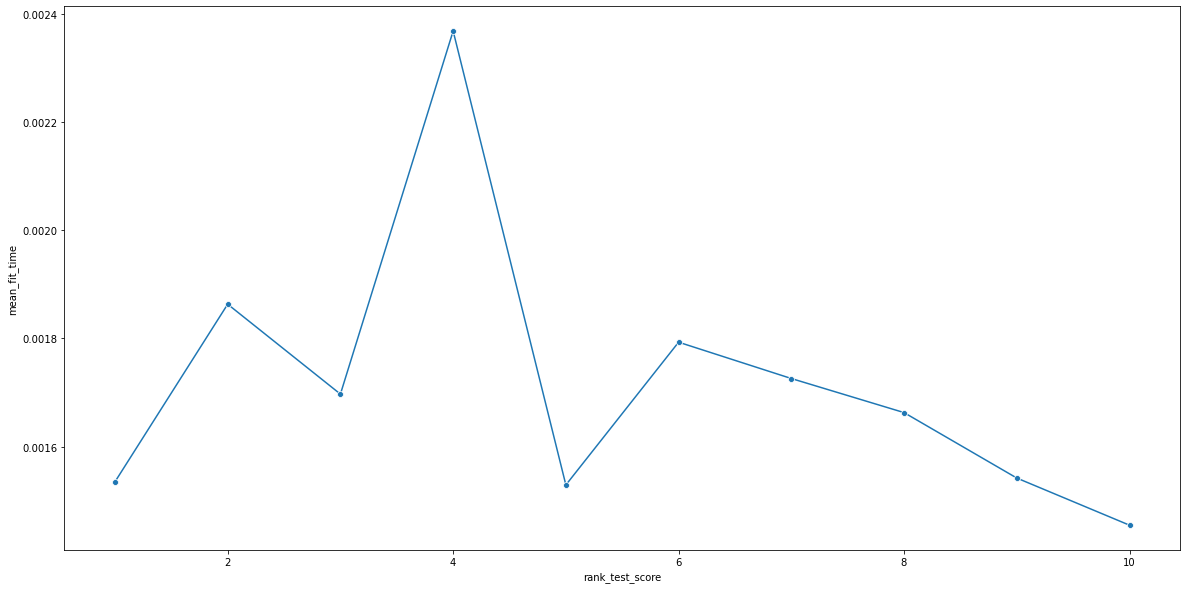

In [62]:
best_score_grid = pd.DataFrame(ridge_regressor.cv_results_).sort_values(by = 'rank_test_score')
sns.lineplot(y= best_score_grid['mean_fit_time'], x = best_score_grid['rank_test_score'], marker="o")
plt.show()

In [68]:
# https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html#statsmodels-regression-linear-model-ols-fit-regularized
# https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db
# https://github.com/Q-shick/fundamentals_of_data_science/blob/master/mathematical%20_model/Ridge%20and%20Lasso.ipynb
# https://towardsdatascience.com/the-power-of-ridge-regression-4281852a64d6
model5 = sm.OLS(Y, X5)
results_fu = model5.fit()
from statsmodels.regression import linear_model

statsmodels.regression.linear_model.OLS.fit_regularized

frames = []
for n in [1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]:
    results_fr = model5.fit_regularized(L1_wt=0, alpha=n, start_params=results_fu.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model5, 
                                                           results_fr.params, 
                                                           model5.normalized_cov_params)
    frames.append(np.append(results_fr.params, results_fr_fit.ssr))

    df5 = pd.DataFrame(frames, columns= ['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu'] + ['ssr*'])
df5.index=[1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]
df5.index.name = 'alpha*'
df5.T

alpha*                 1.000000e-15  1.000000e-10  1.000000e-08  1.000000e-04  \
state_16               3.039192e+03  3.039192e+03  3.039197e+03  3.082151e+03   
state_17               3.033852e+03  3.033852e+03  3.033849e+03  3.005973e+03   
PopDens               -4.634107e+03 -4.634106e+03 -4.634061e+03 -4.229885e+03   
state_2               -1.659257e+03 -1.659257e+03 -1.659256e+03 -1.652341e+03   
PctKidsBornNeverMar    1.061576e+04  1.061576e+04  1.061578e+04  1.074488e+04   
PctVacMore6Mos        -1.525328e+03 -1.525328e+03 -1.525321e+03 -1.468642e+03   
PctLess9thGrade       -7.203310e+03 -7.203308e+03 -7.203111e+03 -5.543147e+03   
householdsize         -1.700879e+03 -1.700879e+03 -1.700886e+03 -1.753271e+03   
state_13              -8.664925e+02 -8.664924e+02 -8.664868e+02 -8.191693e+02   
MedOwnCostPctIncNoMtg -2.454507e+03 -2.454507e+03 -2.454500e+03 -2.393195e+03   
state_5               -9.252445e+02 -9.252445e+02 -9.252442e+02 -9.239024e+02   
state_14              -1.967454e+03 -1.967454e+03 -1.967449e+03 -1.927017e+03   
PctPersOwnOccup       -3.044971e+03 -3.044971e+03 -3.044961e+03 -2.951000e+03   
PctHousOccup           2.727139e+03  2.727139e+03  2.727136e+03  2.697111e+03   
PctNotHSGrad           1.523166e+04  1.523166e+04  1.523146e+04  1.352606e+04   
PctOccupMgmtProf       7.898174e+03  7.898173e+03  7.898104e+03  7.264403e+03   
state_29               3.250311e+03  3.250311e+03  3.250308e+03  3.221392e+03   
state_21               1.712579e+03  1.712579e+03  1.712578e+03  1.710366e+03   
RentLowQ              -3.375346e+02 -3.375345e+02 -3.375246e+02 -2.581050e+02   
PctBSorMore           -3.623621e+03 -3.623621e+03 -3.623607e+03 -3.466797e+03   
state_3                1.718053e+03  1.718053e+03  1.718051e+03  1.694372e+03   
PctSpeakEnglOnly       2.206557e+03  2.206558e+03  2.206591e+03  2.493615e+03   
PctEmplManu           -2.789229e+03 -2.789229e+03 -2.789228e+03 -2.778861e+03   
ssr*                   1.098082e+10  1.098082e+10  1.098082e+10  1.098801e+10   

alpha*                 1.000000e-03  1.000000e-02  1.000000e+00  5.000000e+00  \
state_16               3.243555e+03  3.262577e+03  2.763866e+02  7.576032e+01   
state_17               2.844116e+03  2.049583e+03  9.827113e+01  2.824741e+01   
PopDens               -2.394017e+03  7.357476e+01  1.322888e+02  5.320119e+01   
state_2               -1.629561e+03 -1.503524e+03 -3.773681e+01  1.546932e+01   
PctKidsBornNeverMar    1.050789e+04  6.806372e+03  4.707898e+02  1.502676e+02   
PctVacMore6Mos        -1.258196e+03 -5.640984e+02  6.133608e+02  2.991227e+02   
PctLess9thGrade       -5.234091e+02  2.104825e+03  4.683848e+02  1.741167e+02   
householdsize         -1.626251e+03 -1.829197e+02  4.586366e+02  2.217145e+02   
state_13              -6.815000e+02 -6.508225e+02  1.842873e+01  2.838851e+01   
MedOwnCostPctIncNoMtg -1.985072e+03 -4.248616e+02  3.499071e+02  1.654706e+02   
state_5               -9.455684e+02 -1.136058e+03 -5.977496e+01  1.384283e+01   
state_14              -1.720386e+03 -9.561483e+02  1.717838e+01  1.016871e+01   
PctPersOwnOccup       -2.650785e+03 -2.457116e+03  7.194338e+02  4.143821e+02   
PctHousOccup           2.556404e+03  2.633559e+03  1.410130e+03  6.689741e+02   
PctNotHSGrad           8.302706e+03  4.462673e+03  6.974737e+02  2.641684e+02   
PctOccupMgmtProf       4.390226e+03  1.091480e+03  4.465778e+02  2.493343e+02   
state_29               2.987505e+03  1.730675e+03  4.942624e+01  1.398667e+01   
state_21               1.693963e+03  1.500624e+03  1.258397e+02  3.667435e+01   
RentLowQ              -1.635275e+02 -6.446240e+02  2.535256e+02  1.604158e+02   
PctBSorMore           -2.165506e+03 -2.766528e+02  3.181113e+02  1.909420e+02   
state_3                1.523962e+03  8.616358e+02  4.735125e+01  1.634348e+01   
PctSpeakEnglOnly       3.440928e+03  3.603763e+03  1.355939e+03  6.448608e+02   
PctEmplManu           -2.667892e+03 -1.656038e+03  4.675934e+02  2.371236e+02   
ssr*                   1.11455

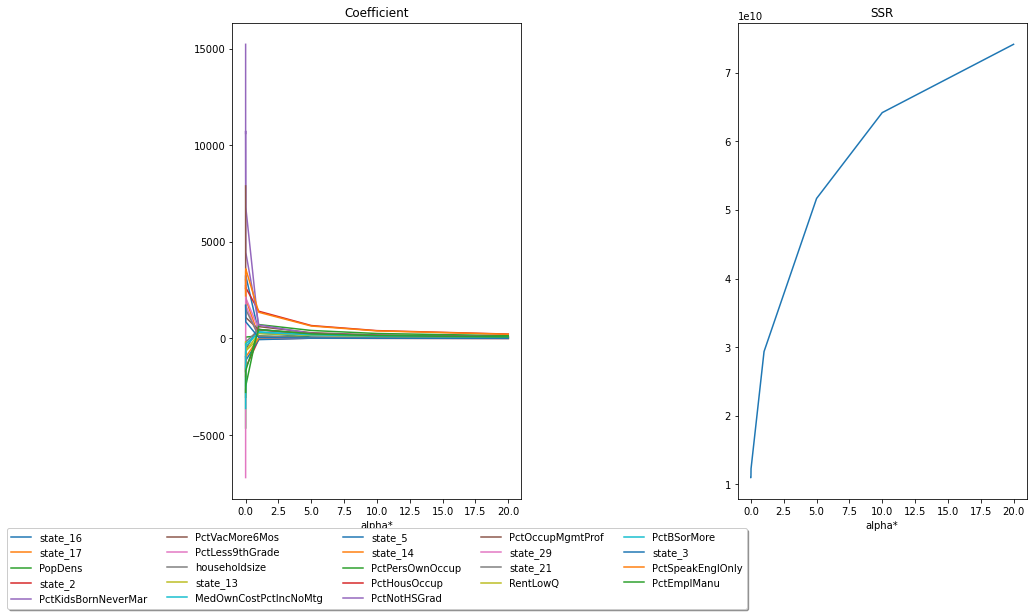

In [69]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(14, 8))

ax[0] = df5.iloc[:, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficient')
# Shrink current axis's height by 10% on the bottom
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)



ax[1] = df5.iloc[:, -1].plot(ax=ax[1])
ax[1].set_title('SSR') # https://www.statology.org/sst-ssr-sse-in-python/

plt.tight_layout()
plt.show()

In [70]:
results_fr = model5.fit_regularized(L1_wt=0, alpha=0.01, start_params=results_fu.params)
final = sm.regression.linear_model.OLSResults(model5, 
                                              results_fr.params, 
                                              model5.normalized_cov_params)

print(final.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.860     
Dependent Variable:     y                AIC:                         35268.6597
Date:                   2022-09-19 12:32 BIC:                         35396.3249
No. Observations:       1902             Log-Likelihood:              -17611.   
Df Model:               23               F-statistic:                 507.3     
Df Residuals:           1879             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.861            Scale:                       6.5373e+06
--------------------------------------------------------------------------------
                         Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
--------------------------------------------------------------------------------
state_16                3262.5772  306.5031 10.6445 0.0000  2661.4550  3863.6995
state_17                2049.5829  426.1866  4.8091 0

In [71]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html?highlight=olsresults#statsmodels.regression.linear_model.OLSResults
print('R2:', results_fr_fit.rsquared)
print('Akaikes information criteria:', results_fr_fit.aic)
print('Bayesian information criteria:', results_fr_fit.bic)
print('mean squared error (MSE) model', results_fr_fit.mse_model)
print('mean squared error (MSE) residuals', results_fr_fit.mse_resid)
print('log likelihood:', results_fr_fit.llf)
print('The uncentered total sum of squares divided by the number of observations:', results_fr_fit.mse_total)
print('The total (weighted) sum of squares centered about the mean:', results_fr_fit.centered_tss)
print('R2 ADJUSTED:', results_fr_fit.rsquared_adj)

R2: 0.16282687497095594
Akaikes information criteria: 38687.80572039565
Bayesian information criteria: 38815.47092898707
mean squared error (MSE) model 626934974.5721973
mean squared error (MSE) residuals 39455971.80451441
log likelihood: -19320.902860197824
The uncentered total sum of squares divided by the number of observations: 46560081.72231499
The total (weighted) sum of squares centered about the mean: 22661987092.437096
R2 ADJUSTED: 0.15257941255708263


### Análisis de los residuos

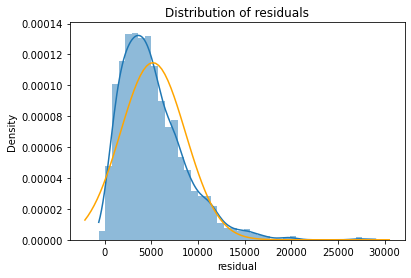

mu, std: 5184.110560672412  3479.0583225641512


In [72]:
mu, std = stats.norm.fit(results_fr_fit.resid)
fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=results_fr_fit.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()
print('mu, std:', mu, '', std)

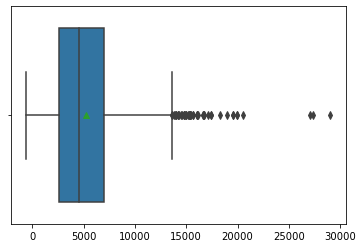

In [73]:
sns.boxplot(x=results_fr_fit.resid, showmeans=True);

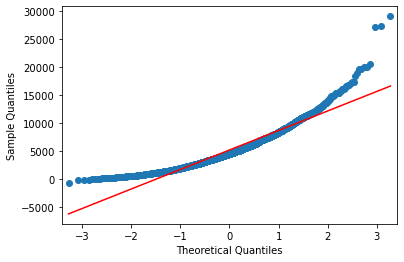

In [74]:
sm.qqplot(results_fr_fit.resid, line='s');

### Análisis de heterocedasticidad

In [75]:
# pruebas de heterocedasticidad 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
# Normalidad de los residuos
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(results_fr_fit.resid)
lzip(name, test)

[('Jarque-Bera', 1717.265167985761),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.3977316024427793),
 ('Kurtosis', 6.72214274046031)]

In [76]:
# Prueba de Breush-Pagan:
#  Si el test-F confirma que las variables independientes son significativas,
#  entonces se puede rechazar la hipótesis nula de homocedasticidad.
name = [ "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",]
test = sms.het_breuschpagan(results_fr_fit.resid, results_fr_fit.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 1081.7222477124537),
 ('p-value', 7.694538114829171e-215),
 ('f-value', 107.73424520103454),
 ('f p-value', 2.8e-322)]

In [77]:
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(results_fr_fit.resid, results_fr_fit.model.exog)
lzip(name, test)

[('F statistic', 0.9432378326570405), ('p-value', 0.8132080098931281)]

## MODELO 6: Regresión lineal ponderada

https://online.stat.psu.edu/stat501/lesson/13

Hasta ahora hemos utilizado mínimos cuadrados ordinarios para estimar la línea de regresión. Sin embargo, algunos aspectos de los datos (como la varianza no constante o los valores atípicos) pueden requerir un método diferente para estimar la línea de regresión. Esta lección proporciona una introducción a algunos de los otros métodos disponibles para estimar líneas de regresión.

https://towardsdatascience.com/weighted-linear-regression-2ef23b12a6d7

**Regresión lineal ponderada**
<br>La regresión lineal ponderada es una generalización de la regresión lineal donde la matriz de covarianza de errores se incorpora en el modelo. Por lo tanto, puede ser beneficioso cuando se trata de datos heteroscedásticos. Aquí, usamos el método de estimación de máxima verosimilitud (MLE) para derivar la solución de regresión lineal ponderada. MLE es un método para estimar parámetros desconocidos maximizando una función de probabilidad del modelo. La variable de respuesta y en el modelo de regresión lineal es una variable aleatoria normal multivariante. 

https://online.stat.psu.edu/stat501/lesson/13/13.1

El método de los mínimos cuadrados ordinarios supone que existe una varianza constante en los errores (lo que se denomina homocedasticidad). El método de mínimos cuadrados ponderados se puede utilizar cuando se viola el supuesto de mínimos cuadrados ordinarios de varianza constante en los errores (lo que se denomina heterocedasticidad).

In [78]:
# almacenamos variables
X6 = xscale[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]

In [321]:
# https://towardsdatascience.com/weighted-linear-regression-2ef23b12a6d7

In [79]:
# Definimos nuestro modelo
w = np.ones(len(X6)) 
mod_wls = sm.WLS(Y, X6, weights=1.0 / (w ** 2))
res_wls = mod_wls.fit() #  https://towardsdatascience.com/weighted-linear-regression-2ef23b12a6d7 para más información
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.876
Model:                            WLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              577.2
Date:                Mon, 19 Sep 2022   Prob (F-statistic):                        0.00
Time:                        12:32:39   Log-Likelihood:                         -17505.
No. Observations:                1902   AIC:                                  3.506e+04
Df Residuals:                    1879   BIC:                                  3.518e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [80]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.html?highlight=olsresults#statsmodels.regression.linear_model.OLSResults
print('R2:', res_wls.rsquared)
print('Akaikes information criteria:', res_wls.aic)
print('Bayesian information criteria:', res_wls.bic)
print('mean squared error (MSE) model', res_wls.mse_model)
print('mean squared error (MSE) residuals', res_wls.mse_resid)
print('log likelihood:', res_wls.llf)
print('The uncentered total sum of squares divided by the number of observations:', res_wls.mse_total)
print('The total (weighted) sum of squares centered about the mean:', res_wls.centered_tss)
print('R2 ADJUSTED:', res_wls.rsquared_adj)

R2: 0.876003215963872
Akaikes information criteria: 35055.41317784618
Bayesian information criteria: 35183.078386437606
mean squared error (MSE) model 3372889481.686825
mean squared error (MSE) residuals 5843968.7903385535
log likelihood: -17504.70658892309
The uncentered total sum of squares divided by the number of observations: 46560081.72231499
The total (weighted) sum of squares centered about the mean: 22661987092.437096
R2 ADJUSTED: 0.8744854266967985


### Análisis de los residuos

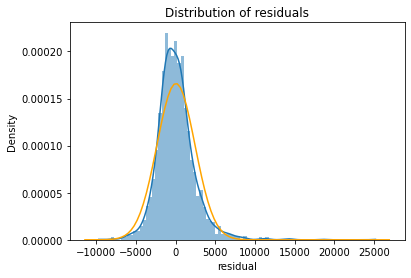

mu, std: 39.513543999663504  2402.444396415232


In [81]:
mu, std = stats.norm.fit(res_wls.resid)
fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=res_wls.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()
print('mu, std:', mu, '', std)

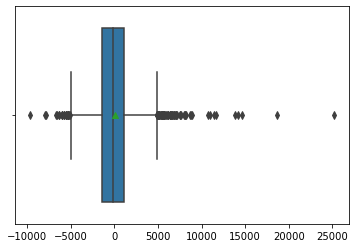

In [82]:
sns.boxplot(x=res_wls.resid, showmeans=True);

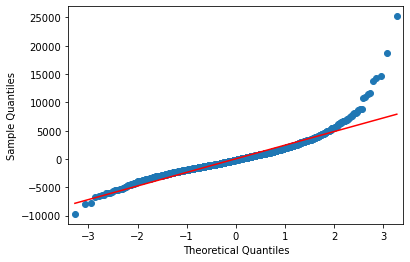

In [83]:
sm.qqplot(res_wls.resid, line='s');

In [84]:
# pruebas de heterocedasticidad 
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
# Normalidad de los residuos
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_wls.resid)
lzip(name, test)

[('Jarque-Bera', 10714.05257716969),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.657372003595802),
 ('Kurtosis', 14.144755027509005)]

### Análisis de heterocedasticidad

In [85]:
# Prueba de Breush-Pagan:
#  Si el test-F confirma que las variables independientes son significativas,
#  entonces se puede rechazar la hipótesis nula de homocedasticidad.
name = [ "Lagrange multiplier statistic",
    "p-value",
    "f-value",
    "f p-value",]
test = sms.het_breuschpagan(res_wls.resid, res_wls.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 192.43739779603717),
 ('p-value', 3.409341230568648e-29),
 ('f-value', 9.196094191186768),
 ('f p-value', 1.750156763515758e-30)]

In [86]:
# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(res_wls.resid, res_wls.model.exog)
lzip(name, test)

[('F statistic', 0.9432378326570408), ('p-value', 0.8132080098931281)]

## MODELO 7: Regresión de XG boost

Documentación consultada: 

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook

https://debuggercafe.com/a-guide-to-xgboost-in-python/

In [87]:
x_xgb = X[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]

In [88]:
# train_test_split
xtrain7, xtest7, ytrain7, ytest7 = train_test_split(x_xgb, Y, test_size=0.2, random_state=42)

**DMatrix**

DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data. 

In [89]:
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
dmatrix_data = xgb.DMatrix(x_xgb, Y)


In [90]:
xgb_model = xgb.XGBRegressor() # creamos el modelo

params = { #definimos variables
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)
# RSCV para encontrar los mejores parámetros 
search.fit(x_xgb, Y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.549 (std: 0.019)
Parameters: {'colsample_bytree': 0.7314607499597442, 'gamma': 0.36870260304690955, 'learning_rate': 0.0846851635427874, 'max_depth': 4, 'n_estimators': 116, 'subsample': 0.6845792027986178}



In [91]:
# almacenamos los parámetros
Parameters = {'colsample_bytree': 0.7314607499597442, 'gamma': 0.36870260304690955, 'learning_rate': 0.0846851635427874, 'max_depth': 4, 'n_estimators': 116, 'subsample': 0.6845792027986178}


In [92]:
# Entrenamos el modelo
xgb_model = xgb.XGBRegressor(objective = "reg:squarederror", colsample_bytree = 0.7412562832437979, gamma = 0.17053317552512925, learning_rate = 0.06404205637217672, max_depth = 4, subsample = 0.9509357413523924)
xgb_fit = xgb_model.fit(xtrain7, ytrain7, eval_set=[(xtrain7, ytrain7), (xtest7, ytest7)], 
            early_stopping_rounds=20)
preds = xgb_fit.predict(xtest7)

rmse = (mean_squared_error(ytest7, preds))


[0]	validation_0-rmse:6423.99414	validation_1-rmse:6556.32178
[1]	validation_0-rmse:6077.45557	validation_1-rmse:6219.12256
[2]	validation_0-rmse:5759.81055	validation_1-rmse:5909.73584
[3]	validation_0-rmse:5458.38916	validation_1-rmse:5620.06934
[4]	validation_0-rmse:5175.25488	validation_1-rmse:5363.82617
[5]	validation_0-rmse:4912.05420	validation_1-rmse:5113.60352
[6]	validation_0-rmse:4669.35840	validation_1-rmse:4893.03662
[7]	validation_0-rmse:4448.11816	validation_1-rmse:4683.33057
[8]	validation_0-rmse:4240.47119	validation_1-rmse:4490.56299
[9]	validation_0-rmse:4046.16992	validation_1-rmse:4316.51611
[10]	validation_0-rmse:3866.88940	validation_1-rmse:4150.75537
[11]	validation_0-rmse:3702.34814	validation_1-rmse:4004.51636
[12]	validation_0-rmse:3551.56738	validation_1-rmse:3874.61645
[13]	validation_0-rmse:3412.27197	validation_1-rmse:3752.59521
[14]	validation_0-rmse:3286.75122	validation_1-rmse:3641.01123
[15]	validation_0-rmse:3174.11719	validation_1-rmse:3542.68872
[1

In [93]:
#  Métricas de evaluación del modelo
print("Model Accuracy: %.3f" % xgb_fit.score(xtest7, ytest7))
mse = mean_squared_error(y_test, xgb_fit.predict(xtest7))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("RMSE %0.2f" % np.sqrt(rmse.mean()))

Model Accuracy: 0.568
The mean squared error (MSE) on test set: 5857863.4580
RMSE 2420.30


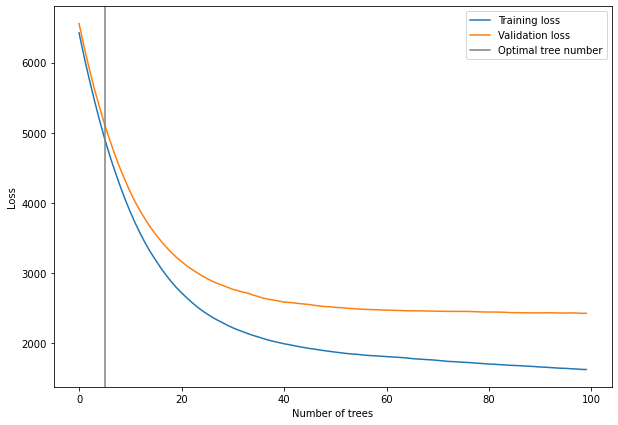

In [94]:
# Overfit

xgb_results = xgb_fit.evals_result()

plt.figure(figsize=(10,7))
plt.plot(xgb_results["validation_0"]["rmse"], label="Training loss")
plt.plot(xgb_results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(5, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [95]:
# Cross validation
cross_val = xgb.cv(params = Parameters,
    dtrain=dmatrix_data, 
    nfold=3,
    num_boost_round=50, 
    early_stopping_rounds=10, 
    metrics='error', 
    as_pandas=True, 
    seed=42)
print(cross_val.head())

[12:34:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:34:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:34:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "n_estimators" } might n

In [96]:
# !pip install graphviz
import graphviz

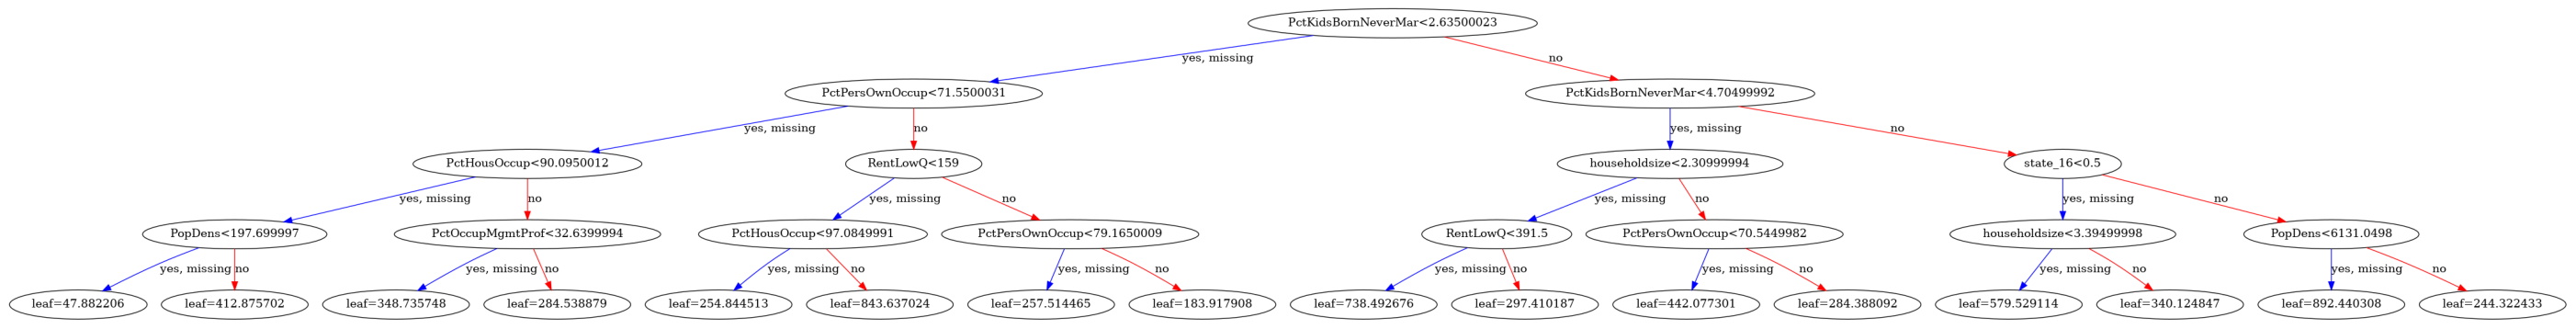

In [97]:
# plot xgboost 
fig, ax = plt.subplots(figsize=(50, 35))
xgb.plot_tree(xgb_fit, num_trees=0, ax=ax)
plt.show()

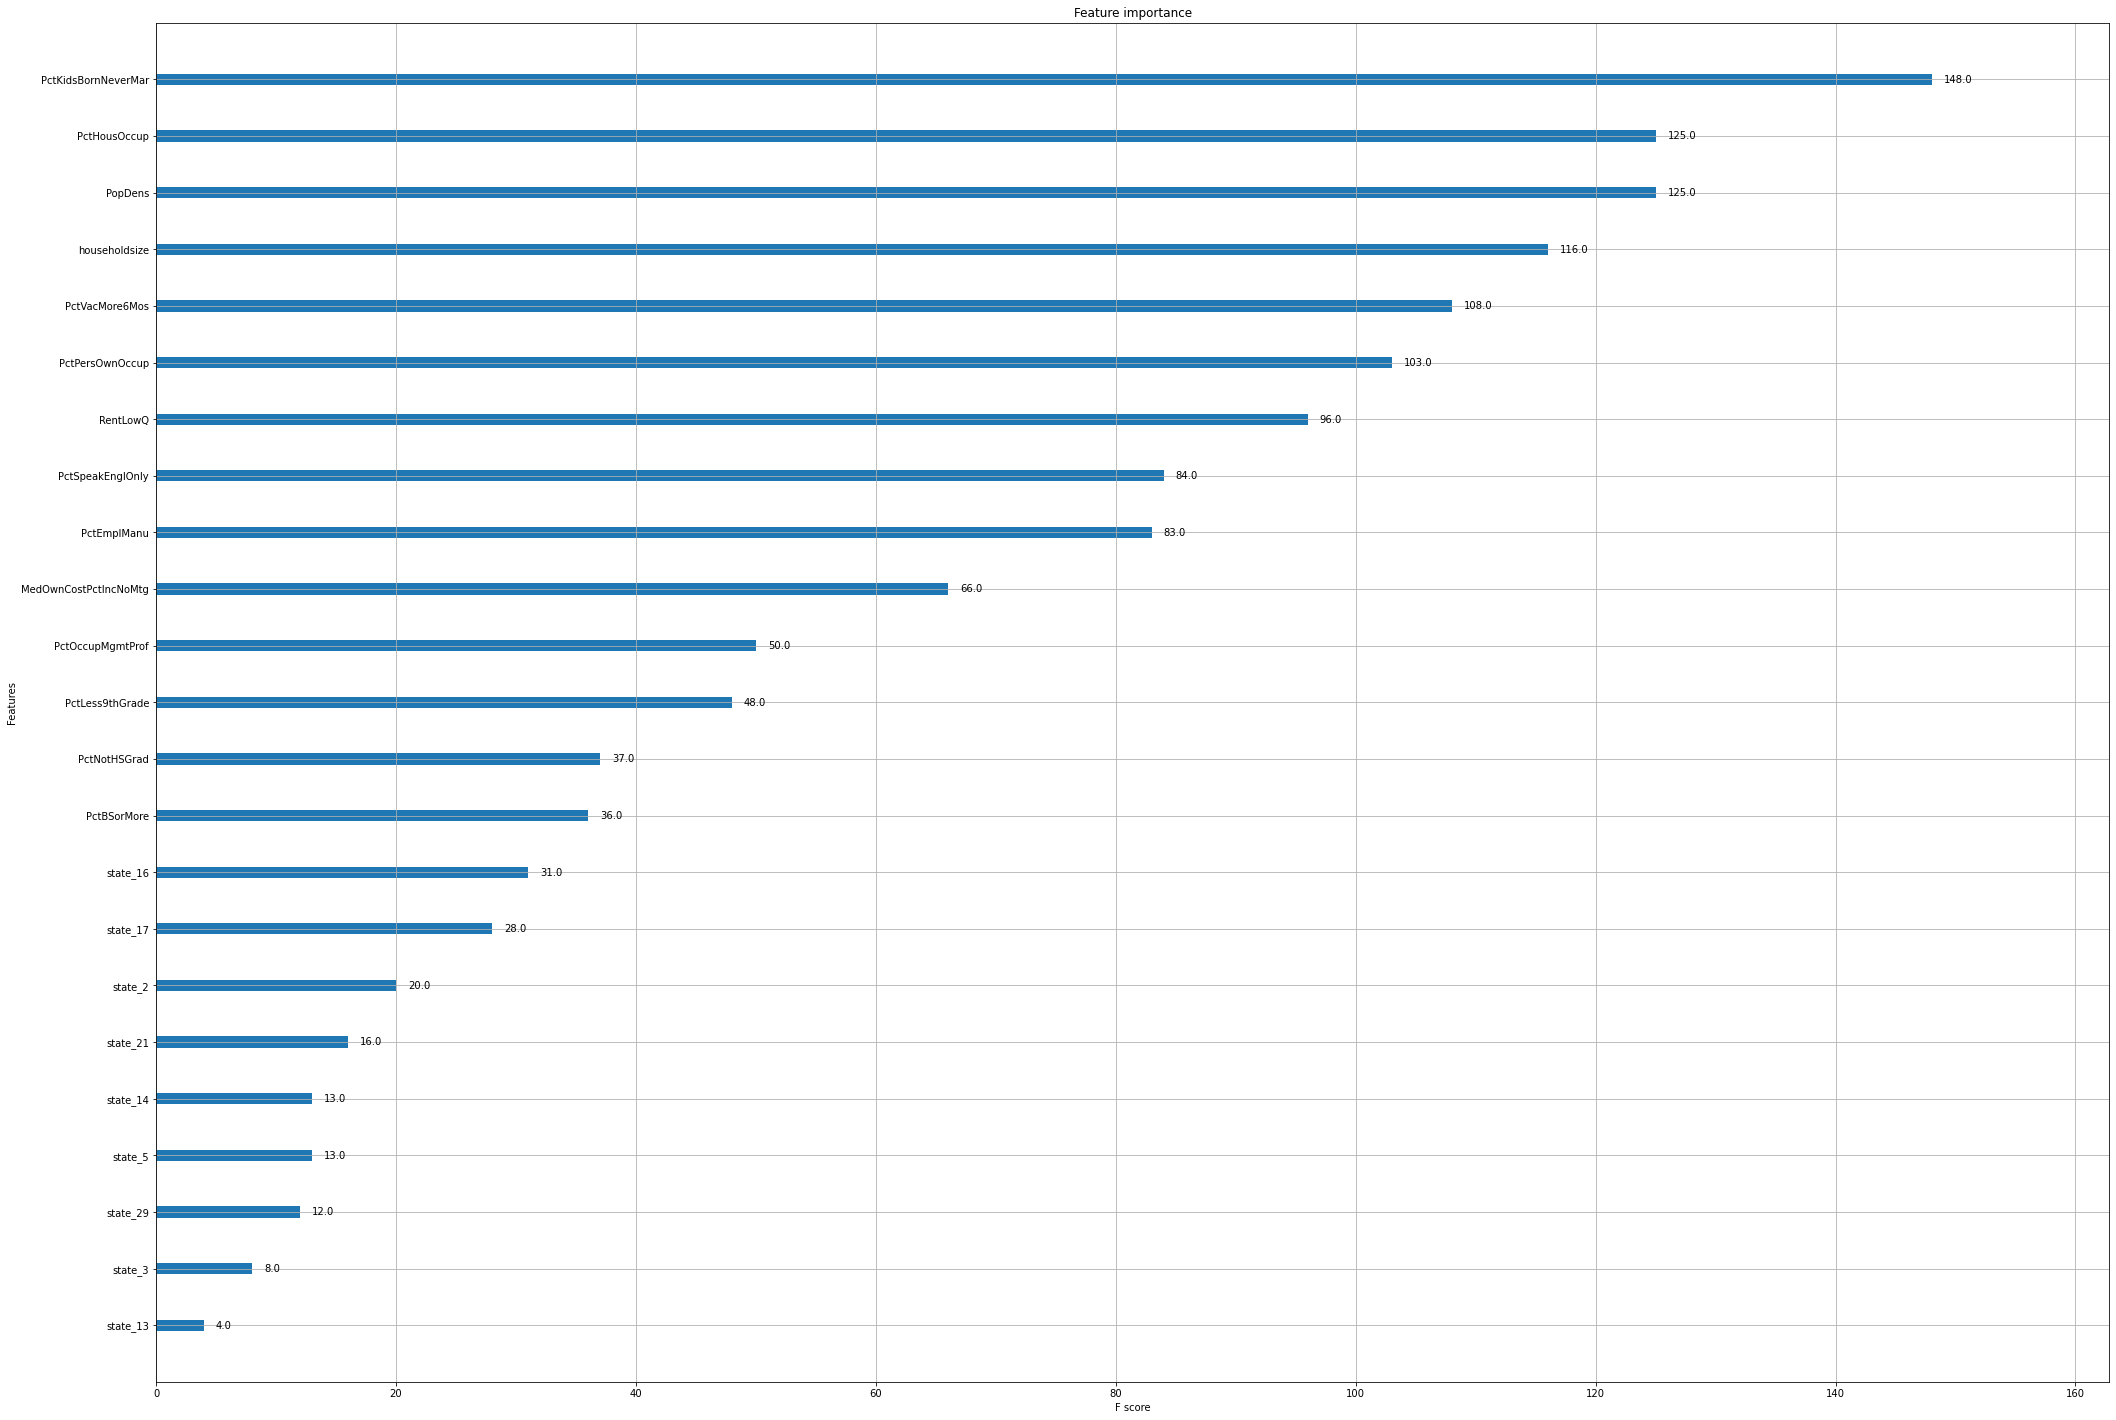

In [98]:
# plot las variables más importantes en el modelo
fig, ax = plt.subplots(figsize=(35, 25))
xgb.plot_importance(xgb_fit, ax = ax)
plt.show()

## MODELO 8: Gradient boosting

Documentación consultada:

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-10-gradient-boosting-c751538131achttps://medium.com/open-machine-learning-course/open-machine-learning-course-topic-10-gradient-boosting-c751538131ac

https://machine-learning.paperspace.com/wiki/gradient-boostinghttps://machine-learning.paperspace.com/wiki/gradient-boosting 

https://medium.com/towards-data-science/statistical-machine-learning-gradient-boosting-adaboost-from-scratch-8c4b5a9db9edhttps://medium.com/towards-data-science/statistical-machine-learning-gradient-boosting-adaboost-from-scratch-8c4b5a9db9ed

https://github.com/samtwl/Machine-Learning/blob/master/Large-scale%20Projects/Predicting%20Singapore%20Private%20Property%20Prices%20Report.pdfhttps://github.com/samtwl/Machine-Learning/blob/master/Large-scale%20Projects/Predicting%20Singapore%20Private%20Property%20Prices%20Report.pdf

In [164]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [165]:
# almacenamos variable
x_gb = X[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]

In [166]:
# train_test_split
xtrain8, xtest8, ytrain8, ytest8 = train_test_split(x_gb, Y, test_size=0.2, random_state=42)

In [168]:

from sklearn.model_selection import KFold
gbr_model = GradientBoostingRegressor()
params_grids = {'learning_rate'    : [0.01, 0.05, 0.07, 0.1, 0.3, 0.5 ],
                'n_estimators'     : [50,60,70,80,90,100],
                'max_depth'        : [1, 2, 3, 4],
                'min_samples_leaf' : [1,2,3,5,10,15],
                'min_samples_split': [2,3,4,5,10],  
                'criterion' : ['friedman_mse', 'mse']}
kf = KFold(n_splits=3, random_state=42, shuffle=True)
gs_gbr = GridSearchCV(estimator=gbr_model, param_grid = params_grids , cv = kf, n_jobs=-1, return_train_score=True, scoring='neg_mean_squared_error') 

In [169]:
#RSCV para escoger el mejor parámetro
search1 = RandomizedSearchCV(gbr_model, param_distributions=params_grids, random_state=42, n_iter=200, cv=kf, verbose=1, n_jobs=1, return_train_score=True)

search1.fit(x_gb, Y)

report_best_scores(search1.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.542 (std: 0.012)
Parameters: {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 4, 'learning_rate': 0.1, 'criterion': 'mse'}



In [170]:
# Parámetros
gbr_parameters = {'n_estimators': 60, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 4, 'learning_rate': 0.1, 'criterion': 'mse'}


In [183]:
# Entrenamos el modelo
gbr = GradientBoostingRegressor(**gbr_parameters)

gbr.fit(xtrain8, ytrain8)

# Métricas de evaluación del modelo
print("Model Accuracy: %.3f" % gbr.score(xtest8, ytest8))
mse = mean_squared_error(y_test, gbr.predict(xtest8))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.556
The mean squared error (MSE) on test set: 6018181.4504


In [184]:
pred_test_gb = gbr.predict(xtest8)
pred_train_gb = gbr.predict(xtrain8)

In [185]:
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gbr.score(xtrain8, ytrain8)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gbr.score(xtest8, ytest8)))

Precisión sobre los datos de entrenamiento: 66.38
Precisión sobre los datos de test: 55.63


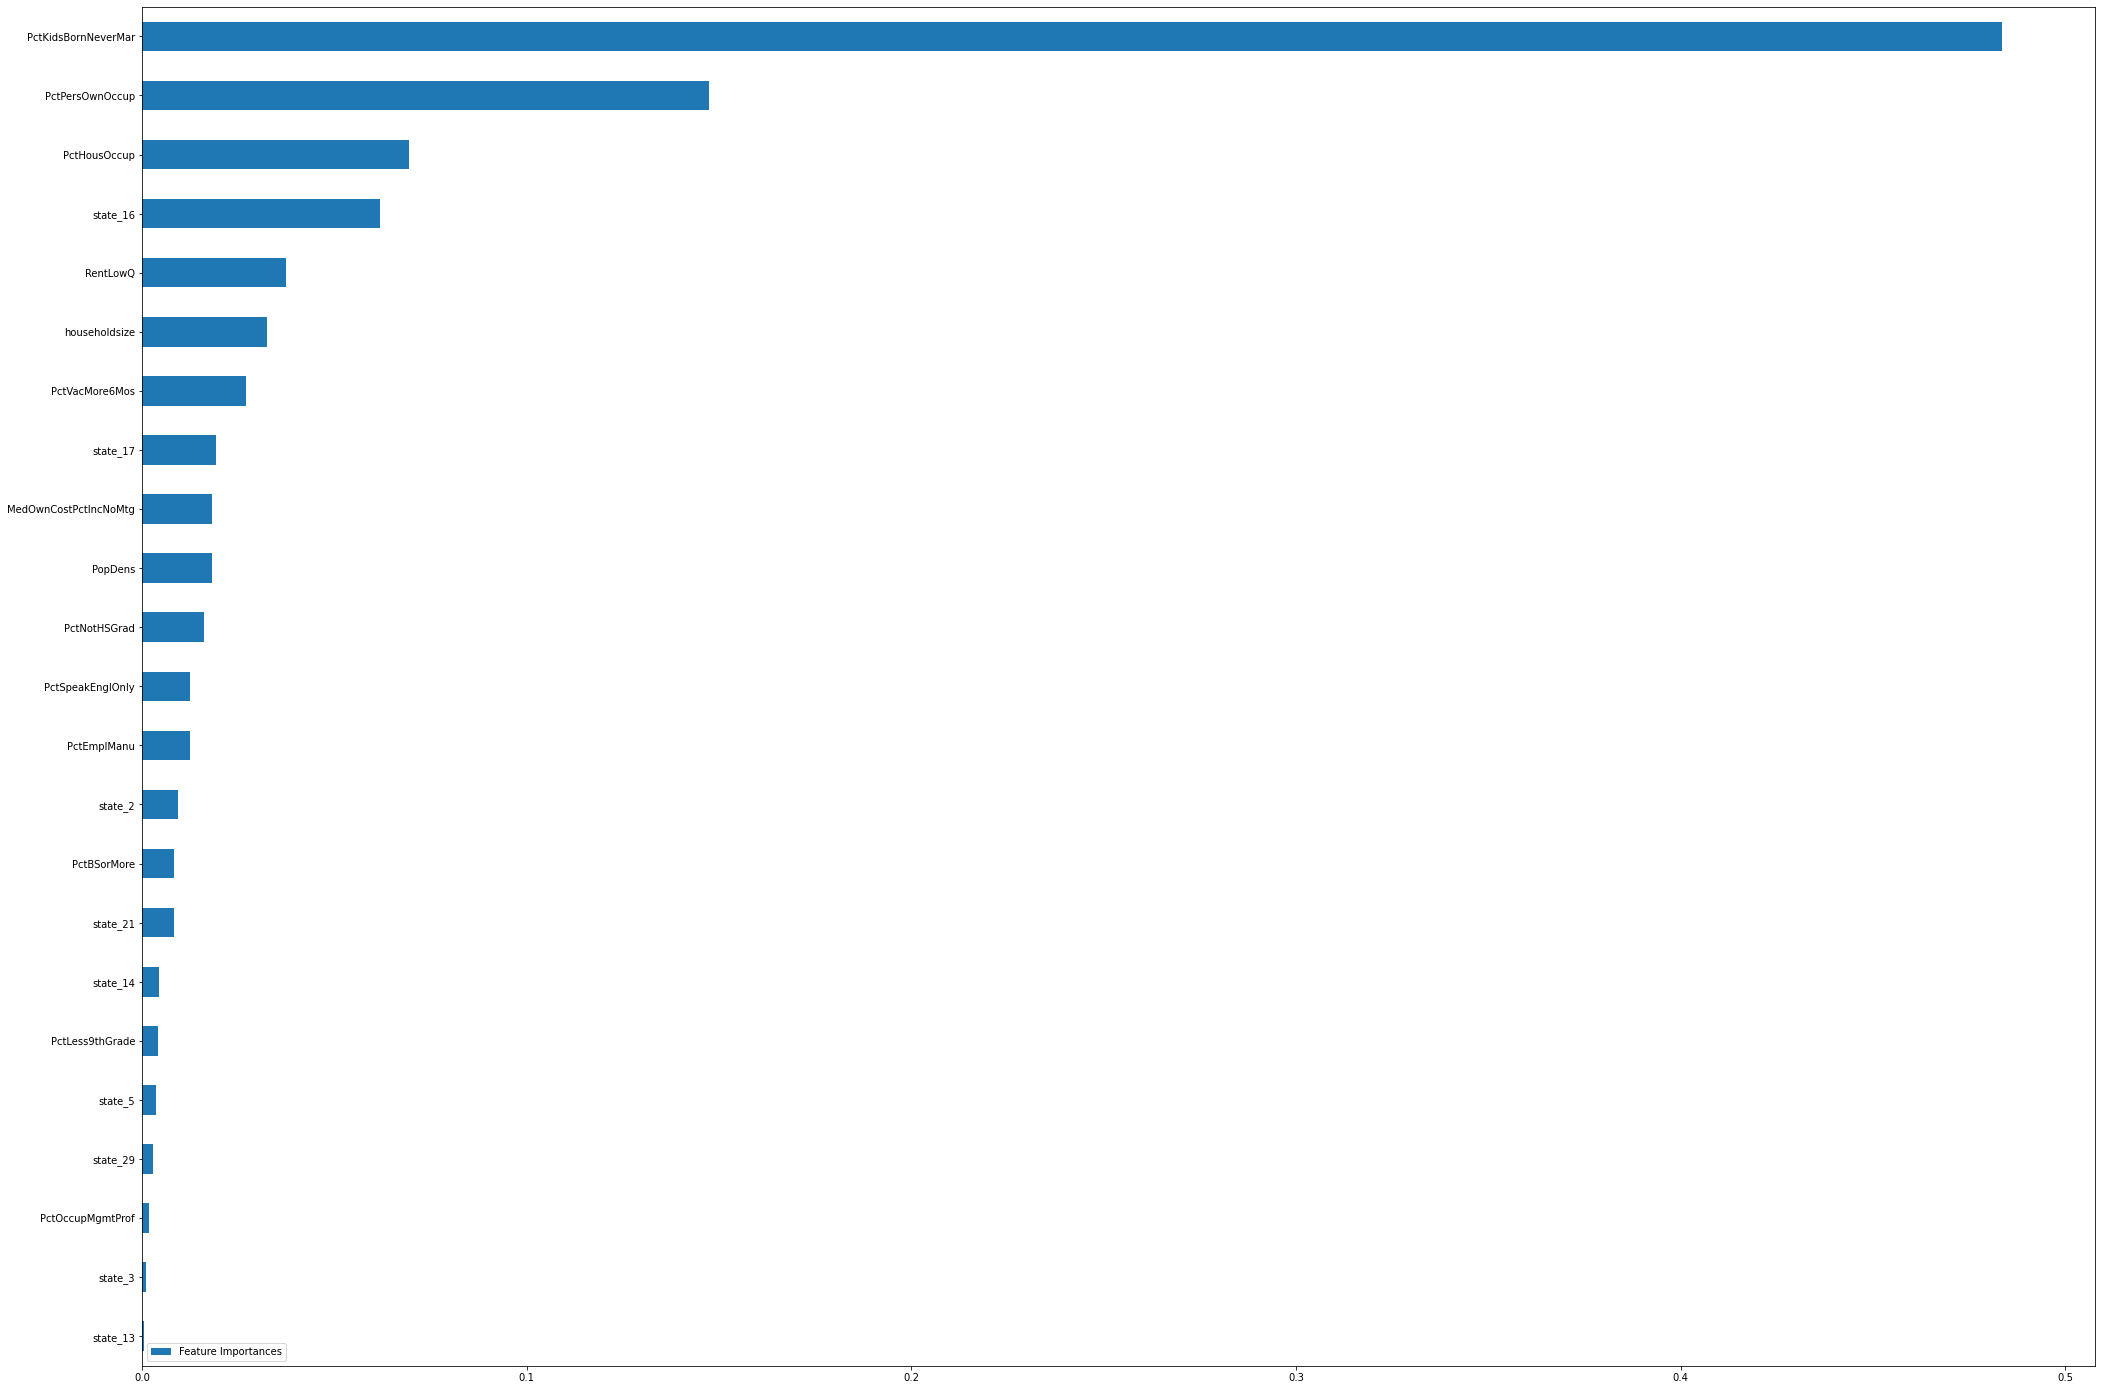

In [188]:
# Variables mas importantes
fig, ax = plt.subplots(figsize=(35, 25))
df_imp = pd.DataFrame(gbr.feature_importances_.reshape(1,-1), columns=xtrain8.columns, index=["Feature Importances"])
df_imp.T.sort_values(by = 'Feature Importances', ascending = True).plot.barh(ax = ax)
plt.legend()
plt.show();

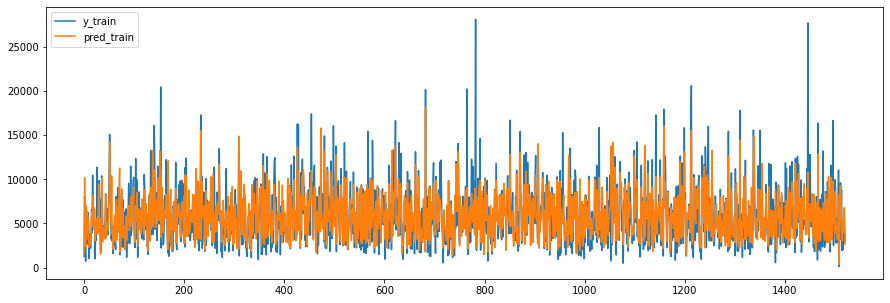

In [189]:
df_train_pred = pd.DataFrame({"y_train":ytrain8, "pred_train":pred_train_gb})
df_train_pred.plot(figsize=(15,5))
plt.show()

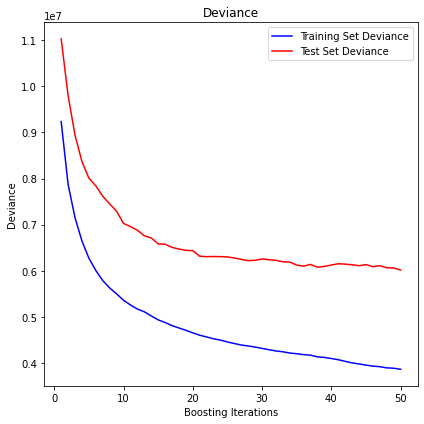

In [190]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html 
# Análisis del sobre entrenamiento del modelo
test_score = np.zeros((gbr_parameters["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(xtest8)):
    test_score[i] = gbr.loss_(ytest8, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(gbr_parameters["n_estimators"]) + 1,
    gbr.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(gbr_parameters["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## MODELO 9: LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

Recuperado de: https://lightgbm.readthedocs.io/en/v3.3.2/https://lightgbm.readthedocs.io/en/v3.3.2/

In [191]:
import lightgbm as lgb

In [192]:
# almacenamos las variables
x_lightGBM =  X[['state_16','state_17', 'PopDens', 'state_2',
       'PctKidsBornNeverMar', 'PctVacMore6Mos', 'PctLess9thGrade',
       'householdsize', 'state_13', 'MedOwnCostPctIncNoMtg', 'state_5',
       'state_14', 'PctPersOwnOccup', 'PctHousOccup', 'PctNotHSGrad',
       'PctOccupMgmtProf', 'state_29', 'state_21', 'RentLowQ', 'PctBSorMore',
       'state_3', 'PctSpeakEnglOnly', 'PctEmplManu']]

In [193]:
# train_test_split
xtrain9, xtest9, ytrain9, ytest9 = train_test_split(x_lightGBM, Y, test_size=0.2, random_state=42)

In [194]:
# Buscamos el mejor parámetro para neustro modelo 
lightGBM = lgb.LGBMRegressor()
params_grids = {'task' : ['predict', 'train'],
                'objective': ['root_mean_squared_error', 'regression'],
                #'num_iterations': [  1500, 2000,5000  ],
                'learning_rate':[  0.05, 0.005 ],
                'num_leaves':[ 7, 15, 31  ],
                'max_depth' :[ 10,15,25],}

kf = KFold(n_splits=3, random_state=42, shuffle=True)
gs_lightGBM = GridSearchCV(estimator=lightGBM, param_grid = params_grids , cv = kf, n_jobs=-1, return_train_score=True, scoring='neg_mean_squared_error') 


In [ ]:
search2 = RandomizedSearchCV(lightGBM, param_distributions=params_grids, random_state=42, n_iter=200, cv=kf, verbose=1, n_jobs=1, return_train_score=True)

search2.fit(x_gb, Y)

report_best_scores(search2.cv_results_, 1)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Model with rank: 1
Mean validation score: 0.537 (std: 0.022)
Parameters: {'task': 'predict', 'objective': 'root_mean_squared_error', 'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.05}

Model with rank: 1
Mean validation score: 0.537 (std: 0.022)
Parameters: {'task': 'train', 'objective': 'root_mean_squared_error', 'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.05}

Model with rank: 1
Mean validation score: 0.537 (std: 0.022)
Parameters: {'task': 'predict', 'objective': 'regression', 'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.05}

Model with rank: 1
Mean validation score: 0.537 (std: 0.022)
Parameters: {'task': 'train', 'objective': 'regression', 'num_leaves': 15, 'max_depth': 10, 'learning_rate': 0.05}



In [199]:
# Entrenamos nuestro modelo
lightGBM = lgb.LGBMRegressor(task = 'train', objective = 'root_mean_squared_error', num_leaves = 15, max_depth = 10, learning_rate = 0.05)
lightGBM_fit = lightGBM.fit(xtrain9, ytrain9)
pred_test_lightGBM = lightGBM.predict(xtest9)
pred_train_lightGBM = lightGBM.predict(xtrain9)

In [200]:
# Entrenamos nuestros datasets y volvemos a entrenar
lgb_train = lgb.Dataset(xtrain9, ytrain9)
lgb_eval = lgb.Dataset(xtest9, ytest9, reference=lgb_train)

# fitting the model
model = lgb.train(lightGBM_parameters,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=30)

# prediction
y_pred = model.predict(xtest9)



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 1521, number of used features: 22
[LightGBM] [Info] Start training from score 5895.773345
[1]	valid_0's l2: 1.29932e+07
Training until validation scores don't improve for 30 rounds
[2]	valid_0's l2: 1.24867e+07
[3]	valid_0's l2: 1.20392e+07
[4]	valid_0's l2: 1.16401e+07
[5]	valid_0's l2: 1.12198e+07
[6]	valid_0's l2: 1.08937e+07
[7]	valid_0's l2: 1.05715e+07
[8]	valid_0's l2: 1.02833e+07
[9]	valid_0's l2: 1.00156e+07
[10]	valid_0's l2: 9.78711e+06
[11]	valid_0's l2: 9.56216e+06
[12]	valid_0's l2: 9.36693e+06
[13]	valid_0's l2: 9.1912e+06
[14]	valid_0's l2: 9.01194e+06
[15]	valid_0's l2: 8.86164e+06
[16]	valid_0's l2: 8.71512e+06
[17]	valid_0's l2: 8.54158e+06
[18]	valid_0's l2: 8.41463e+06
[19]	valid_0's l2: 8.26871e+06
[20]	valid_0'

In [201]:
pred_test_gb = model.predict(xtest9)
pred_train_gb = model.predict(xtrain9)

In [202]:
# Métricas de evaluación del modelo
print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*lightGBM.score(xtrain9, ytrain9)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*lightGBM.score(xtest9, ytest9)))
mse9 = mean_squared_error(ytest9, lightGBM.predict(xtest9))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse9))

Precisión sobre los datos de entrenamiento: 75.21
Precisión sobre los datos de test: 55.25
The mean squared error (MSE) on test set: 6069660.2373


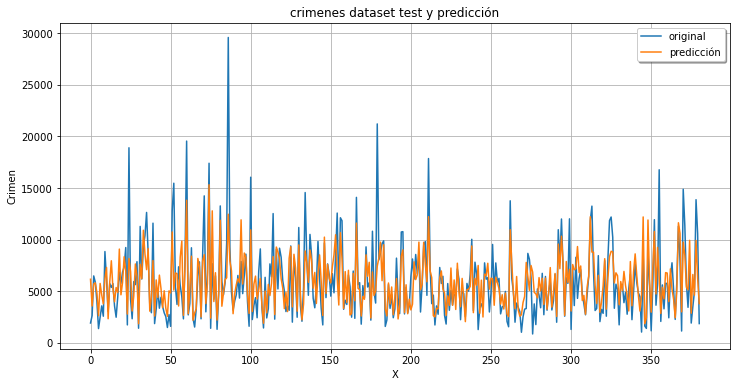

In [203]:
# visualizing in a plot
x_ax = range(len(ytest9))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicción")
plt.title("crimenes dataset test y predicción")
plt.xlabel('X')
plt.ylabel('Crimen')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

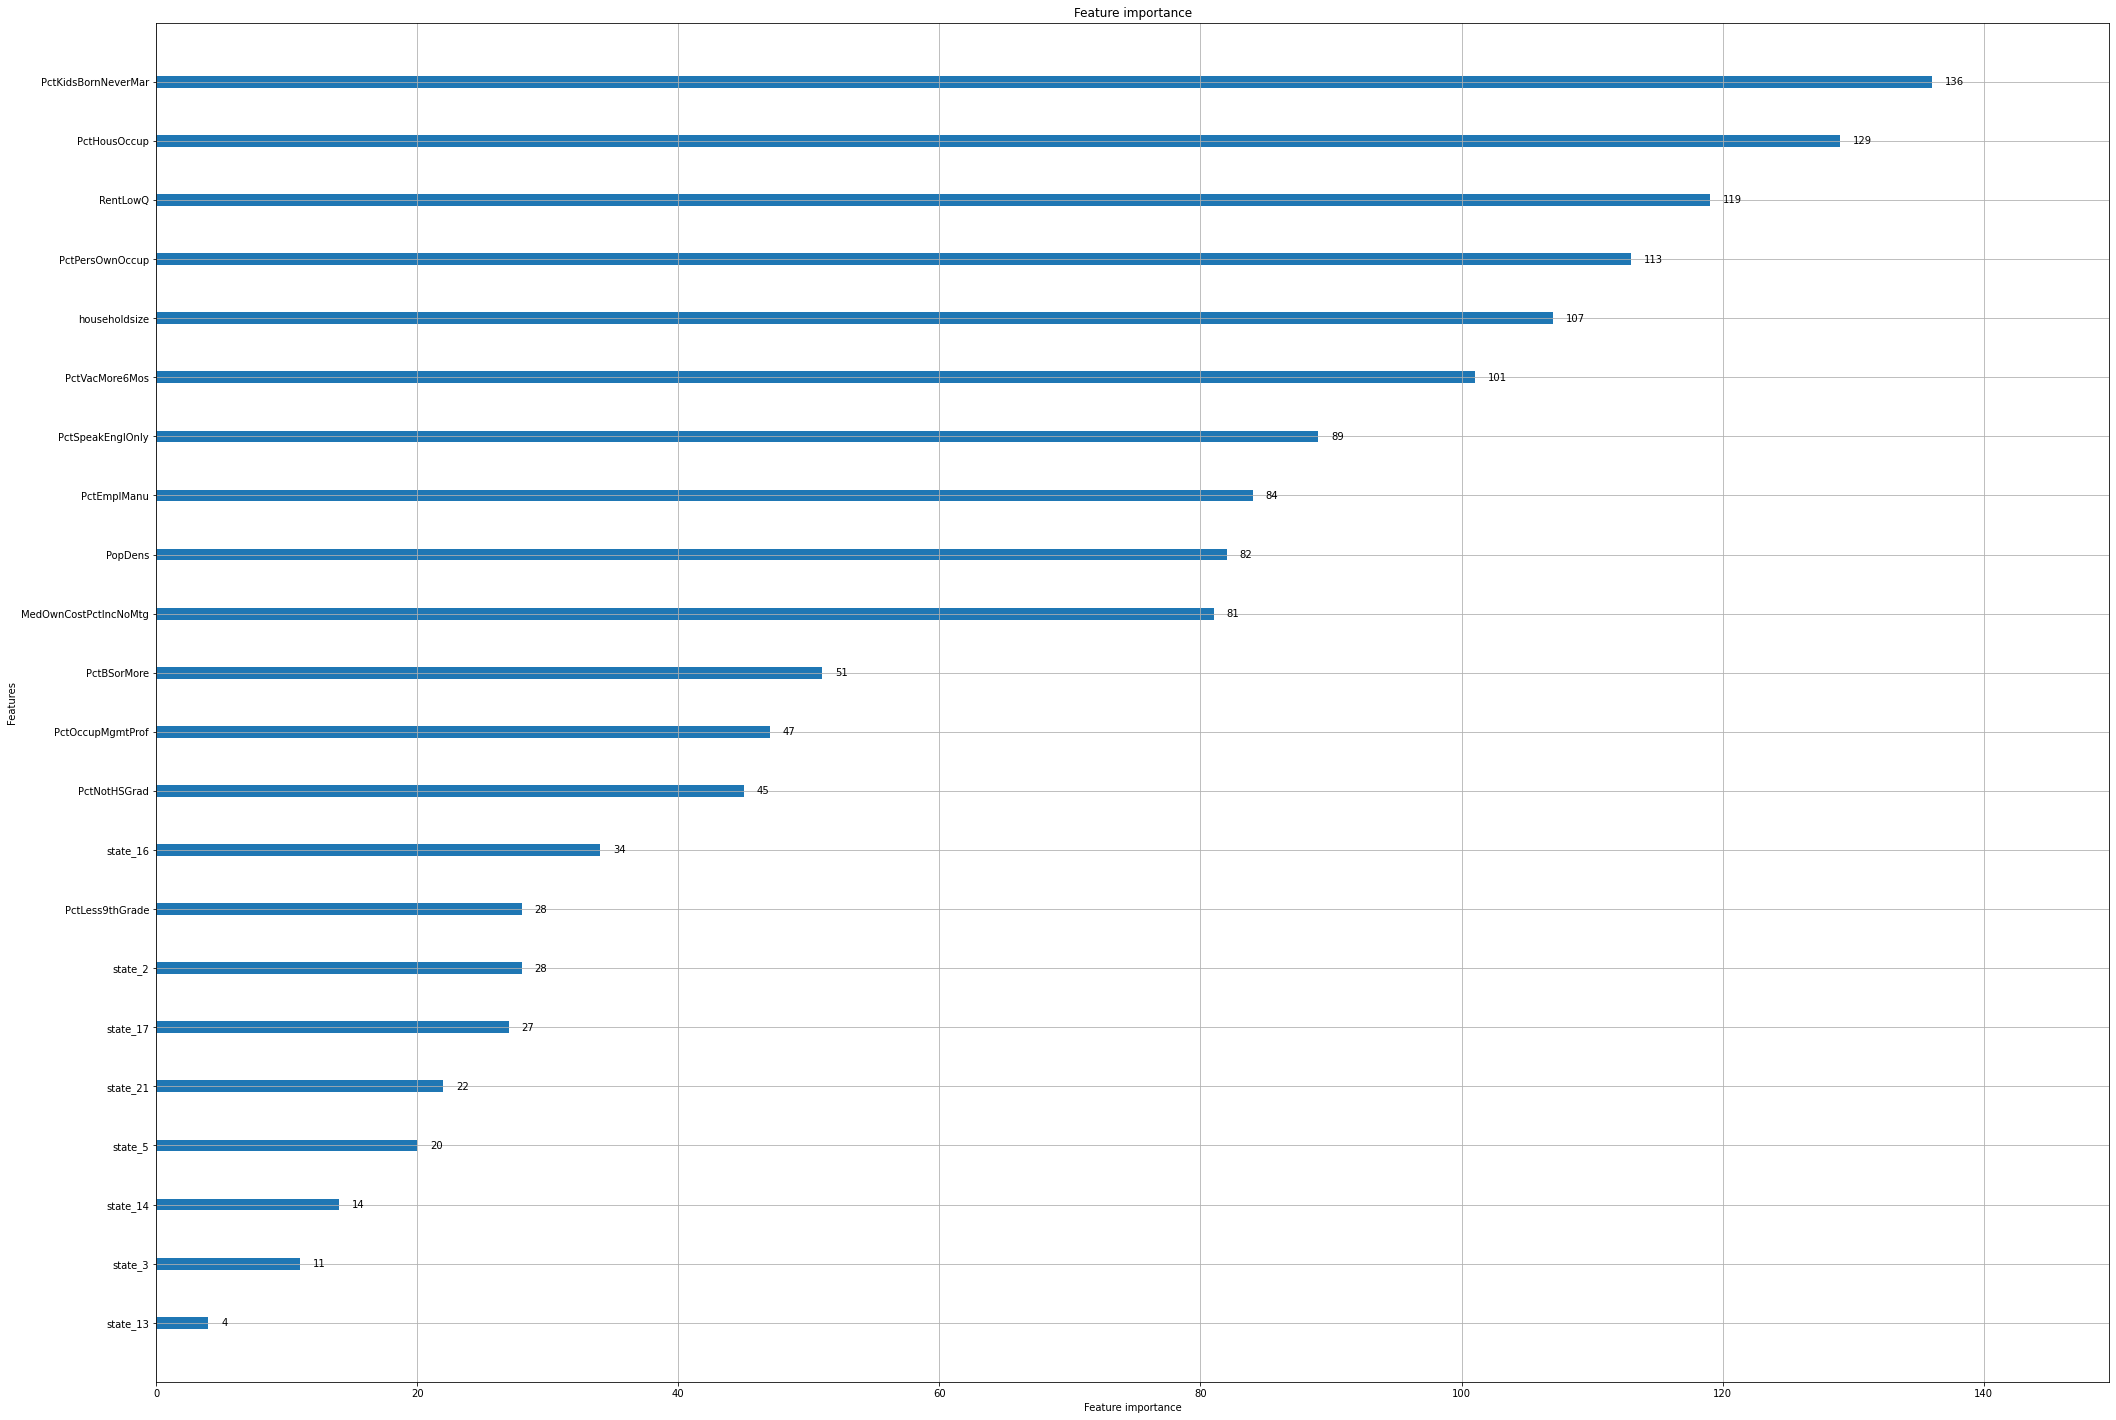

In [205]:
# Caracteristicas o variables más importantes del modelo 
fig, ax = plt.subplots(figsize=(35, 25))
lgb.plot_importance(model, ax = ax)
plt.show()